In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader,TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
import time
from torch.nn import init
from thop import profile


In [2]:
# Remember to install CUDA and cuDNN
# Determine if your system supports CUDA.
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
#%% Read data
data=pd.read_hdf("D:/conda/FallAllD.h5") #
data = data.drop(columns = ['Gyr','Mag','Bar'])
#%% Label
data_waist = []
label_waist = []
subject_waist = []
PATH = "D:/conda/111_1117/FullAll_3LayerModel_CNNSmall.pt"
for i in range(len(data)):
    if(data['Device'][i] == 'Waist'):
        a = data['Acc'][i]*0.000244
        # Normalize each data between 0 and 1
        b = b = (a-np.amin(a))/(np.amax(a)-np.amin(a)) 
        data_waist.append(b) 
        subject_waist.append(data['SubjectID'][i])
        # Class: fall = 0 ,ADL = 1 
        if (data['ActivityID'][i] > 100): 
            label_waist.append(1)
        else:
            label_waist.append(0)

# Change list to array
data_waist = np.array(data_waist)            
label_waist = np.array(label_waist)
subject_waist = np.array(subject_waist)

# Downsampling 1/128
down_data = []
# (start:size:step)
down_data = data_waist[::1,::128,::1]           
#%% Sliding_window
sliding_waist_data =[]
sliding_waist_label =[]
sliding_waist_subject =[]   

# The signal of each second 
per_sec = 38/20
sec = 7

In [3]:
for num in range(len(down_data)):
    if label_waist[num] ==1:
        # Data[index][start:end,axis]
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5)+1),:])
        # Label each window with class and subject
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        
    else:
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        
sliding_waist_data = np.array(sliding_waist_data)
sliding_waist_label = np.array(sliding_waist_label)
sliding_waist_subject = np.array(sliding_waist_subject) 

np.save('FallALLD_SW_data',sliding_waist_data)
np.save('FallALLD_SW_label',sliding_waist_label)
np.save('FallALLD_SW_subject',sliding_waist_subject)

In [4]:
#%% Show Teacher confusion matrix
def show_CM_teacher(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher) SubjectID' + str(sub) + '.png')

#%% Show Student confusion matrix
def show_CM_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Student) SubjectID' + str(sub) + '.png')
    
#%% Show Teacher-Student confusion matrix
def show_CM_teacher_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher-Student) SubjectID' + str(sub) + '.png')
def show_loss_teacher(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher) SubjectID' + str(sub) + '.png')
def show_Acc_teacher(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher) SubjectID' + str(sub) + '.png')
#Loss_student
def show_loss_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (Student) SubjectID' + str(sub) + '.png')   
def show_Acc_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (student) SubjectID' + str(sub) + '.png')
def show_loss_teacher_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher_Student) SubjectID' + str(sub) + '.png')   
def show_Acc_teacher_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher_student) SubjectID' + str(sub) + '.png')

In [5]:
def loss_fn_kd(outputs, labels, teacher_outputs, T=20, alpha=0.5):
    # 一般的Cross Entropy
    labels=labels.type(torch.cuda.LongTensor)
    hard_loss = F.cross_entropy(outputs, labels) * (1. - alpha)
    # 讓logits的log_softmax對目標機率(teacher的logits/T後softmax)做KL Divergence。
    soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T)
    return hard_loss + soft_loss

In [6]:
class hswish(nn.Module):
    def forward(self, x):
        out = x * F.relu6(x + 3, inplace=True) / 6
        return out


class hsigmoid(nn.Module):
    def forward(self, x):
        out = F.relu6(x + 3, inplace=True) / 6
        return out


class SeModule(nn.Module):
    def __init__(self, in_size, reduction=4):
        super(SeModule, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_size, in_size // reduction, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size // reduction),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_size // reduction, in_size, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size),
            hsigmoid()
        )

    def forward(self, x):
        return x * self.se(x)


class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, kernel_size, in_size, expand_size, out_size, nolinear, semodule, stride):
        super(Block, self).__init__()
        self.stride = stride
        self.se = semodule

        self.conv1 = nn.Conv2d(in_size, expand_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(expand_size)
        self.nolinear1 = nolinear
        self.conv2 = nn.Conv2d(expand_size, expand_size, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=expand_size, bias=False)
        self.bn2 = nn.BatchNorm2d(expand_size)
        self.nolinear2 = nolinear
        self.conv3 = nn.Conv2d(expand_size, out_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_size)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_size != out_size:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_size, out_size, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_size),
            )

    def forward(self, x):
        out = self.nolinear1(self.bn1(self.conv1(x)))
        out = self.nolinear2(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.se != None:
            out = self.se(out)
        out = out + self.shortcut(x) if self.stride==1 else out
        return out

In [7]:
#%% This is the config object which contains all relevant settings.    
config = {
    'nb_filters': 64,
    'filter_width': 1,
    'drop_prob': 0.5,
    'epochs': 200,#200
    'batch_size': 64,
    'learning_rate': 1e-3,#1e-3
    'weight_decay': 2e-6,
    'gpu_name': 'cuda:0',
    'print_counts': False,
    'lr_factor' : 2,
    'lr_warmup' : 40
}

In [8]:
class MobileNetV3_Small(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Small, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), SeModule(16), 2),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 96, 40, hswish(), SeModule(40), 2),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 120, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 144, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 288, 96, hswish(), SeModule(96), 2),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(576, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [9]:
class MobileNetV3_Large(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Large, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), None, 1),
            Block(3, 16, 64, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 72, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 72, 40, nn.ReLU(inplace=True), SeModule(40), 2),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(3, 40, 240, 80, hswish(), None, 2),
            Block(3, 80, 200, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 480, 112, hswish(), SeModule(112), 1),
            Block(3, 112, 672, 112, hswish(), SeModule(112), 1),
            Block(5, 112, 672, 160, hswish(), SeModule(160), 1),
            Block(5, 160, 672, 160, hswish(), SeModule(160), 2),
            Block(5, 160, 960, 160, hswish(), SeModule(160), 1),
        )


        self.conv2 = nn.Conv2d(160, 960, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(960)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(960, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [10]:
class MobileNetV3_Small_KD(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Small_KD, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), SeModule(16), 2),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 96, 40, hswish(), SeModule(40), 2),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 120, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 144, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 288, 96, hswish(), SeModule(96), 2),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(576, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [11]:
#%% Define teacher neural network
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
      super(block, self).__init__()
      self.expansion = 4
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1,bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
      self.relu = nn.ReLU()
      self.identity_downsample = identity_downsample
      self.stride = stride

  def forward(self, x):
      identity = x.clone()
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.bn3(x)

      if self.identity_downsample is not None:
          identity = self.identity_downsample(identity)

      x += identity
      x = self.relu(x)
      return x

class Net_Teacher(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

#%% Define student neural network
class Net_Student(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Student, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        print("device:", device)
        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

#%% Define student neural network
class Net_Teacher_Student(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher_Student, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [12]:
#%% Define teacher training loop
def training_teacher(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []

        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        train_acc.append(100 * (correct_train / total_train).cpu())
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
        
    eval_table = evaluation(train_preds, train_gt)

    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

#%% Define teacher testing loop
#def testing_teacher(testloader,optimizer,criterion,model):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)

                test_output = model(inputs)
                
                optimizer.zero_grad()

                # Compute loss
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step() 
                test_losses.append(loss.item())        
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)                

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher.append(eval_table[0])
#         Recall_teacher.append(eval_table[1])
#         Precision_teacher.append(eval_table[2])
#         F1score_teacher.append(eval_table[3])
    #Plot train_loss
        teacher_train_preds.extend(test_preds)
        teacher_train_gt.extend(test_gt)

    show_loss_teacher(loss_train, loss_test)
    show_Acc_teacher(train_acc, test_acc)
    #return Accuracy_teacher, Recall_teacher, Precision_teacher, F1score_teacher
    return teacher_train_preds, teacher_train_gt

In [13]:
#%% Define student training loop
def training_student(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(100 * (correct_train / total_train).cpu())
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval()
    #start_time = time.time()
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):            
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()                
                # Compute loss                

                test_output = model(inputs)
                
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step()
                test_losses.append(loss.item())                
                
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))
                
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
            elapsed = time.time() - start_time
            #print('| epoch {:3d} | {:5.4f} s/epoch | test loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))    
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nTest Val Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_student(test_gt, test_preds)
        #Store each result
#         Accuracy_student.append(eval_table[0])
#         Recall_student.append(eval_table[1])
#         Precision_student.append(eval_table[2])
#         F1score_student.append(eval_table[3])
        
        student_train_preds.extend(test_preds)
        student_train_gt.extend(test_gt)
    #Plot train_loss
    show_loss_student(loss_train, loss_test)
    show_Acc_student(train_acc, test_acc)
    
    #return Accuracy_student, Recall_student, Precision_student, F1score_student
    return student_train_preds, student_train_gt

In [14]:
def training_teacher_student(trainloader,optimizer,criterion,model_teacher,model_student,alpha,testloader,Layer,lis):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    total_num, total_hit = 0, 0
    # Freeze the Teacher model
    model_teacher.eval()
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds_student = []
        train_preds_teacher = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()

            # Forward pass (compute output)
            output_student = model_student(inputs)
            output_teacher = model_teacher(inputs)

            # Use softmax to normalize the output to a probability distribution over predicted output classes
            output_student_soft = F.softmax(output_student, dim =1)
            y_preds_student = np.argmax(output_student_soft.cpu().detach().numpy(), axis=-1)

            output_teacher_soft = F.softmax(output_teacher, dim =1)
            y_preds_teacher = np.argmax(output_teacher_soft.cpu().detach().numpy(), axis=-1)

            # Compute loss
            loss = loss_fn_kd(output_student, labels, output_teacher, 20, alpha)
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            total_hit += torch.sum(torch.argmax(output_student, dim=1) == labels).item()
            total_num += len(inputs)
            y_true = labels.cpu().numpy().flatten()
            train_preds_student = np.concatenate((np.array(train_preds_student, int), np.array(y_preds_student, int)))
            train_preds_teacher = np.concatenate((np.array(train_preds_teacher, int), np.array(y_preds_teacher, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(total_hit/total_num)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds_student, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')
    

#%% Define Teacher-Student testing loop
#def testing_teacher_student(testloader,optimizer,criterion,model_teacher,model_student):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_num, total_hit = 0, 0
    # Sets network to eval mod
    model_teacher.eval()
    model_student.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):            
            for i, (x, y) in enumerate(testloader):
                inputs ,targets = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()
                
                test_output = model_student(inputs)
                test_teacher = model_teacher(inputs)
                # Compute loss
                #loss = loss_fn_kd(test_output, labels, output_teacher, 20, alpha)                
                loss = loss_fn_kd(test_output, targets, test_teacher, 20, alpha)                
                # Backpropagaton
                #loss.backward() 
                # Update parameter
                #optimizer.step() 
                test_losses.append(loss.item())     
                
                test_output = F.softmax(test_output, dim=1)                
                total_hit += torch.sum(torch.argmax(test_output, dim=1) == targets).item()
                total_num += len(inputs)
                
                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = targets.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            #eval_table = evaluation(test_preds,test_gt)
            test_acc.append(total_hit/total_num)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher_student(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher_student.append(eval_table[0])
#         Recall_teacher_student.append(eval_table[1])
#         Precision_teacher_student.append(eval_table[2])
#         F1score_teacher_student.append(eval_table[3])      
        teacher_student_train_preds.extend(test_preds)
        teacher_student_train_gt.extend(test_gt)
    show_loss_teacher_student(loss_train, loss_test)
    show_Acc_teacher_student(train_acc,test_acc)
    #return Accuracy_teacher_student, Recall_teacher_student, Precision_teacher_student, F1score_teacher_student
    if (Layer==False) and (lis == 15):
            save(config['epochs'], model_student, optimizer, loss)  
            #return teacher_student_train_preds, teacher_student_train_gt, teacher_student_model, teacher_student_optimizer, teacher_student_loss
    if (Layer==False) and (lis == 1):
            save(config['epochs'], model_student, optimizer, loss)
    return teacher_student_train_preds, teacher_student_train_gt

In [15]:
def save(epoch, student, optimizer, loss):
#     trial_id = self.config['trial_id']
#     if name is None:
        torch.save({
        'epoch': epoch,
        'model_state_dict': student.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        #'loss_state_dict': loss.state_dice()
        'loss_state_dict': loss.item()
        }, PATH)
#     else:
#         torch.save({
#         'model_state_dict': self.student.state_dict(),
#         'optimizer_state_dict': self.optimizer.state_dict(),
#         'epoch': epoch,
#         }, name)

        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")

In [16]:
def load_checkpoint(model, checkpoint_path):
        """
        Loads weights from checkpoint
        :param model: a pytorch nn student
        :param str checkpoint_path: address/path of a file
        :return: pytorch nn student with weights loaded from checkpoint
        """
        model_ckp = torch.load(checkpoint_path)
        model.load_state_dict(model_ckp['model_state_dict'])
        return model


Subject 1
device: cuda
| epoch   0 | 0.3395 s/epoch | train loss 0.5000
| epoch   1 | 0.2735 s/epoch | train loss 0.3779
| epoch   2 | 0.2718 s/epoch | train loss 0.3852
| epoch   3 | 0.2741 s/epoch | train loss 0.3470
| epoch   4 | 0.2699 s/epoch | train loss 0.3371
| epoch   5 | 0.2768 s/epoch | train loss 0.2917
| epoch   6 | 0.2835 s/epoch | train loss 0.4280
| epoch   7 | 0.2670 s/epoch | train loss 0.3635
| epoch   8 | 0.2674 s/epoch | train loss 0.3329
| epoch   9 | 0.2751 s/epoch | train loss 0.3063
| epoch  10 | 0.2856 s/epoch | train loss 0.3020
| epoch  11 | 0.2807 s/epoch | train loss 0.3024
| epoch  12 | 0.2756 s/epoch | train loss 0.2849
| epoch  13 | 0.2790 s/epoch | train loss 0.2952
| epoch  14 | 0.2767 s/epoch | train loss 0.2649
| epoch  15 | 0.2806 s/epoch | train loss 0.2610
| epoch  16 | 0.2785 s/epoch | train loss 0.2642
| epoch  17 | 0.2817 s/epoch | train loss 0.2536
| epoch  18 | 0.2800 s/epoch | train loss 0.2559
| epoch  19 | 0.2797 s/epoch | train loss 0.2

| epoch 167 | 0.2906 s/epoch | train loss 0.0501
| epoch 168 | 0.2899 s/epoch | train loss 0.0595
| epoch 169 | 0.2889 s/epoch | train loss 0.0557
| epoch 170 | 0.2899 s/epoch | train loss 0.0582
| epoch 171 | 0.2914 s/epoch | train loss 0.0578
| epoch 172 | 0.2884 s/epoch | train loss 0.0627
| epoch 173 | 0.2890 s/epoch | train loss 0.0489
| epoch 174 | 0.2893 s/epoch | train loss 0.0527
| epoch 175 | 0.2880 s/epoch | train loss 0.0786
| epoch 176 | 0.2893 s/epoch | train loss 0.0435
| epoch 177 | 0.2889 s/epoch | train loss 0.0497
| epoch 178 | 0.2881 s/epoch | train loss 0.0513
| epoch 179 | 0.2885 s/epoch | train loss 0.0471
| epoch 180 | 0.2909 s/epoch | train loss 0.0299
| epoch 181 | 0.2865 s/epoch | train loss 0.0494
| epoch 182 | 0.2914 s/epoch | train loss 0.1866
| epoch 183 | 0.2880 s/epoch | train loss 0.2569
| epoch 184 | 0.2913 s/epoch | train loss 0.2217
| epoch 185 | 0.2872 s/epoch | train loss 0.1265
| epoch 186 | 0.2892 s/epoch | train loss 0.1042
| epoch 187 | 0.2894

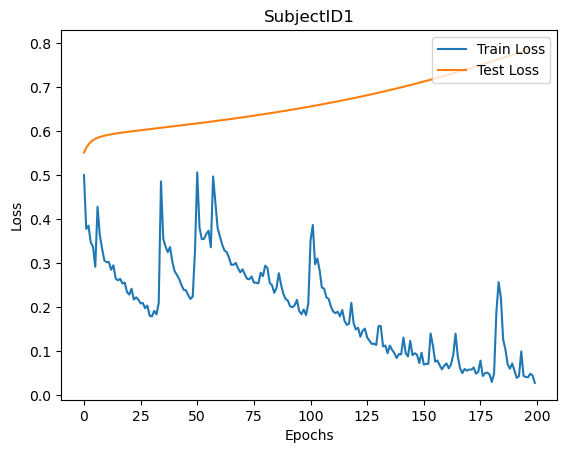

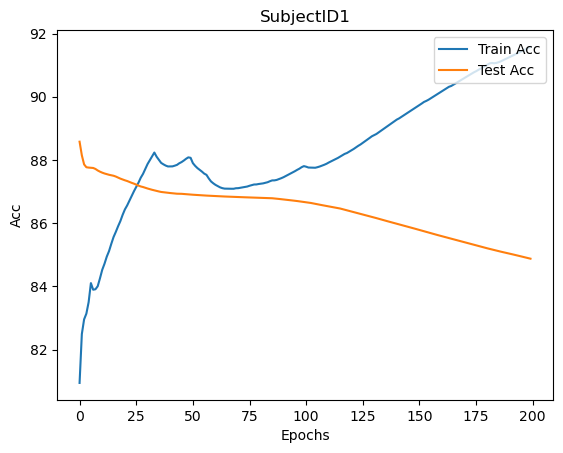

| epoch   0 | 0.2882 s/epoch | train loss 0.4526
| epoch   1 | 0.2894 s/epoch | train loss 0.3470
| epoch   2 | 0.2892 s/epoch | train loss 0.3388
| epoch   3 | 0.2888 s/epoch | train loss 0.3223
| epoch   4 | 0.2911 s/epoch | train loss 0.3121
| epoch   5 | 0.2888 s/epoch | train loss 0.2842
| epoch   6 | 0.2886 s/epoch | train loss 0.2619
| epoch   7 | 0.2902 s/epoch | train loss 0.2885
| epoch   8 | 0.2895 s/epoch | train loss 0.3204
| epoch   9 | 0.2919 s/epoch | train loss 0.2748
| epoch  10 | 0.2902 s/epoch | train loss 0.2520
| epoch  11 | 0.2897 s/epoch | train loss 0.2680
| epoch  12 | 0.2890 s/epoch | train loss 0.2472
| epoch  13 | 0.2896 s/epoch | train loss 0.2519
| epoch  14 | 0.2880 s/epoch | train loss 0.2606
| epoch  15 | 0.2908 s/epoch | train loss 0.2306
| epoch  16 | 0.2874 s/epoch | train loss 0.2427
| epoch  17 | 0.2895 s/epoch | train loss 0.2165
| epoch  18 | 0.2910 s/epoch | train loss 0.2158
| epoch  19 | 0.2890 s/epoch | train loss 0.4028
| epoch  20 | 0.2908

| epoch 168 | 0.2922 s/epoch | train loss 0.0583
| epoch 169 | 0.2929 s/epoch | train loss 0.0441
| epoch 170 | 0.2911 s/epoch | train loss 0.0548
| epoch 171 | 0.2913 s/epoch | train loss 0.0655
| epoch 172 | 0.2903 s/epoch | train loss 0.0617
| epoch 173 | 0.2931 s/epoch | train loss 0.3236
| epoch 174 | 0.2889 s/epoch | train loss 0.1754
| epoch 175 | 0.2893 s/epoch | train loss 0.1311
| epoch 176 | 0.2930 s/epoch | train loss 0.0850
| epoch 177 | 0.2918 s/epoch | train loss 0.0750
| epoch 178 | 0.2923 s/epoch | train loss 0.0560
| epoch 179 | 0.2947 s/epoch | train loss 0.0595
| epoch 180 | 0.2904 s/epoch | train loss 0.0562
| epoch 181 | 0.2929 s/epoch | train loss 0.0539
| epoch 182 | 0.2925 s/epoch | train loss 0.0818
| epoch 183 | 0.2929 s/epoch | train loss 0.0545
| epoch 184 | 0.2923 s/epoch | train loss 0.0738
| epoch 185 | 0.2917 s/epoch | train loss 0.3267
| epoch 186 | 0.2924 s/epoch | train loss 0.2647
| epoch 187 | 0.2928 s/epoch | train loss 0.2266
| epoch 188 | 0.2914

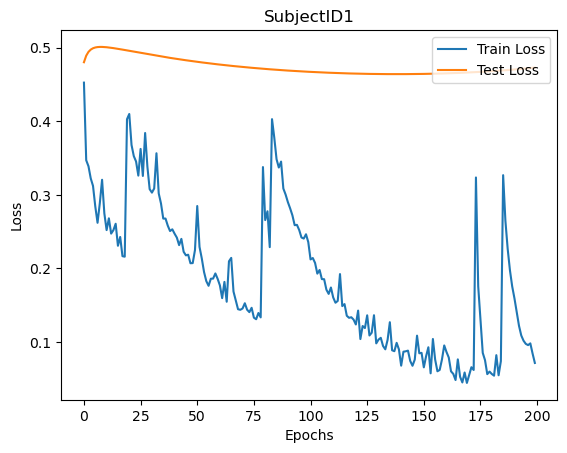

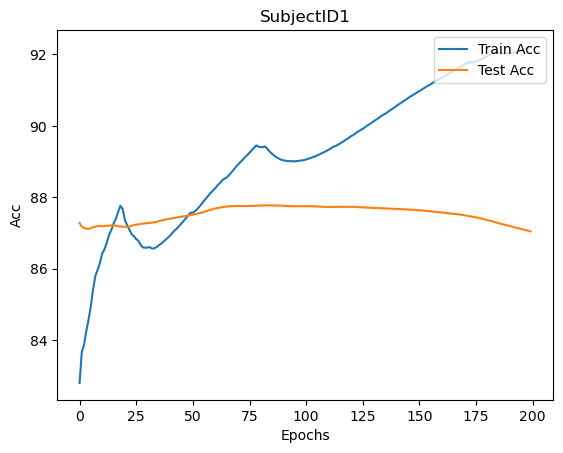


Subject 2
device: cuda
| epoch   0 | 0.2814 s/epoch | train loss 0.5170
| epoch   1 | 0.2820 s/epoch | train loss 0.4185
| epoch   2 | 0.2839 s/epoch | train loss 0.3761
| epoch   3 | 0.2829 s/epoch | train loss 0.3292
| epoch   4 | 0.2849 s/epoch | train loss 0.3106
| epoch   5 | 0.2819 s/epoch | train loss 0.2966
| epoch   6 | 0.2827 s/epoch | train loss 0.3385
| epoch   7 | 0.2834 s/epoch | train loss 0.3775
| epoch   8 | 0.2814 s/epoch | train loss 0.3393
| epoch   9 | 0.2831 s/epoch | train loss 0.3161
| epoch  10 | 0.2827 s/epoch | train loss 0.4230
| epoch  11 | 0.2824 s/epoch | train loss 0.3387
| epoch  12 | 0.2831 s/epoch | train loss 0.3126
| epoch  13 | 0.2833 s/epoch | train loss 0.3045
| epoch  14 | 0.2831 s/epoch | train loss 0.3864
| epoch  15 | 0.2843 s/epoch | train loss 0.3351
| epoch  16 | 0.2805 s/epoch | train loss 0.3192
| epoch  17 | 0.2820 s/epoch | train loss 0.3041
| epoch  18 | 0.2795 s/epoch | train loss 0.3043
| epoch  19 | 0.2822 s/epoch | train loss 0.3

| epoch 167 | 0.2944 s/epoch | train loss 0.1452
| epoch 168 | 0.2961 s/epoch | train loss 0.1399
| epoch 169 | 0.2926 s/epoch | train loss 0.1209
| epoch 170 | 0.2929 s/epoch | train loss 0.1075
| epoch 171 | 0.2931 s/epoch | train loss 0.1030
| epoch 172 | 0.2942 s/epoch | train loss 0.0956
| epoch 173 | 0.2976 s/epoch | train loss 0.0854
| epoch 174 | 0.2933 s/epoch | train loss 0.0933
| epoch 175 | 0.2924 s/epoch | train loss 0.0923
| epoch 176 | 0.2947 s/epoch | train loss 0.1269
| epoch 177 | 0.2958 s/epoch | train loss 0.0966
| epoch 178 | 0.2958 s/epoch | train loss 0.0885
| epoch 179 | 0.2916 s/epoch | train loss 0.1197
| epoch 180 | 0.2933 s/epoch | train loss 0.3017
| epoch 181 | 0.2968 s/epoch | train loss 0.2015
| epoch 182 | 0.2957 s/epoch | train loss 0.1785
| epoch 183 | 0.2938 s/epoch | train loss 0.1571
| epoch 184 | 0.2936 s/epoch | train loss 0.1568
| epoch 185 | 0.2936 s/epoch | train loss 0.1247
| epoch 186 | 0.2913 s/epoch | train loss 0.1145
| epoch 187 | 0.2968

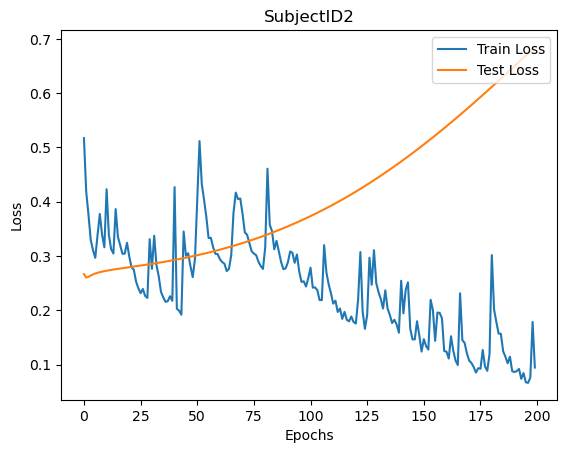

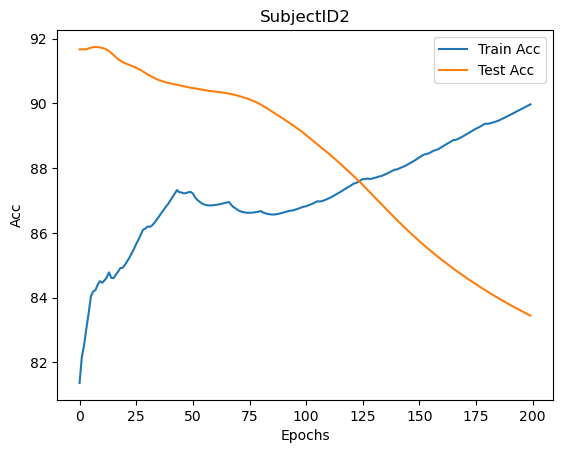

| epoch   0 | 0.2941 s/epoch | train loss 0.5241
| epoch   1 | 0.2901 s/epoch | train loss 0.4198
| epoch   2 | 0.2949 s/epoch | train loss 0.4112
| epoch   3 | 0.2941 s/epoch | train loss 0.3624
| epoch   4 | 0.2957 s/epoch | train loss 0.3731
| epoch   5 | 0.2958 s/epoch | train loss 0.3424
| epoch   6 | 0.2906 s/epoch | train loss 0.3275
| epoch   7 | 0.2939 s/epoch | train loss 0.3870
| epoch   8 | 0.2907 s/epoch | train loss 0.3928
| epoch   9 | 0.2955 s/epoch | train loss 0.3530
| epoch  10 | 0.2923 s/epoch | train loss 0.3508
| epoch  11 | 0.2942 s/epoch | train loss 0.3269
| epoch  12 | 0.2923 s/epoch | train loss 0.5189
| epoch  13 | 0.2954 s/epoch | train loss 0.5135
| epoch  14 | 0.2945 s/epoch | train loss 0.3898
| epoch  15 | 0.2922 s/epoch | train loss 0.3536
| epoch  16 | 0.2937 s/epoch | train loss 0.3663
| epoch  17 | 0.2942 s/epoch | train loss 0.4178
| epoch  18 | 0.2952 s/epoch | train loss 0.3842
| epoch  19 | 0.2899 s/epoch | train loss 0.3805
| epoch  20 | 0.2931

| epoch 168 | 0.2950 s/epoch | train loss 0.2916
| epoch 169 | 0.2916 s/epoch | train loss 0.2481
| epoch 170 | 0.2943 s/epoch | train loss 0.2303
| epoch 171 | 0.2950 s/epoch | train loss 0.2098
| epoch 172 | 0.2922 s/epoch | train loss 0.2049
| epoch 173 | 0.2952 s/epoch | train loss 0.1979
| epoch 174 | 0.2930 s/epoch | train loss 0.2027
| epoch 175 | 0.2933 s/epoch | train loss 0.2308
| epoch 176 | 0.2937 s/epoch | train loss 0.2210
| epoch 177 | 0.2933 s/epoch | train loss 0.2242
| epoch 178 | 0.2927 s/epoch | train loss 0.2019
| epoch 179 | 0.2912 s/epoch | train loss 0.2105
| epoch 180 | 0.2908 s/epoch | train loss 0.3490
| epoch 181 | 0.2947 s/epoch | train loss 0.3271
| epoch 182 | 0.2940 s/epoch | train loss 0.2842
| epoch 183 | 0.2919 s/epoch | train loss 0.3717
| epoch 184 | 0.2926 s/epoch | train loss 0.2849
| epoch 185 | 0.2976 s/epoch | train loss 0.2655
| epoch 186 | 0.2951 s/epoch | train loss 0.2514
| epoch 187 | 0.2949 s/epoch | train loss 0.2340
| epoch 188 | 0.2959

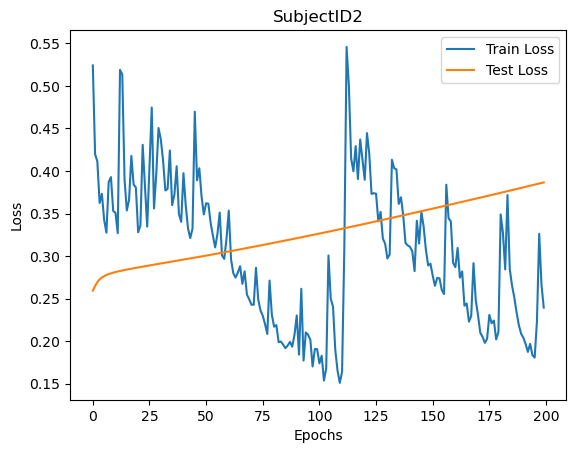

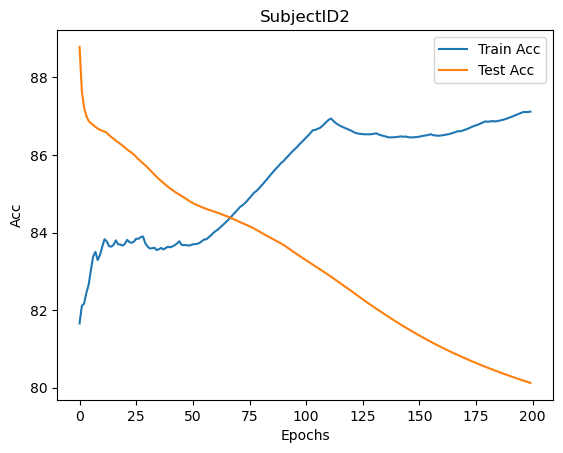


Subject 3
device: cuda
| epoch   0 | 0.2939 s/epoch | train loss 0.4976
| epoch   1 | 0.2924 s/epoch | train loss 0.3394
| epoch   2 | 0.2904 s/epoch | train loss 0.3044
| epoch   3 | 0.2930 s/epoch | train loss 0.2842
| epoch   4 | 0.2952 s/epoch | train loss 0.3047
| epoch   5 | 0.2938 s/epoch | train loss 0.3168
| epoch   6 | 0.2948 s/epoch | train loss 0.3071
| epoch   7 | 0.2934 s/epoch | train loss 0.2749
| epoch   8 | 0.2933 s/epoch | train loss 0.3165
| epoch   9 | 0.2937 s/epoch | train loss 0.2823
| epoch  10 | 0.2942 s/epoch | train loss 0.2683
| epoch  11 | 0.2937 s/epoch | train loss 0.2790
| epoch  12 | 0.2961 s/epoch | train loss 0.2774
| epoch  13 | 0.2948 s/epoch | train loss 0.2660
| epoch  14 | 0.2907 s/epoch | train loss 0.2491
| epoch  15 | 0.2922 s/epoch | train loss 0.2424
| epoch  16 | 0.2910 s/epoch | train loss 0.2455
| epoch  17 | 0.2929 s/epoch | train loss 0.2289
| epoch  18 | 0.2951 s/epoch | train loss 0.2170
| epoch  19 | 0.2932 s/epoch | train loss 0.2

| epoch 167 | 0.2948 s/epoch | train loss 0.0319
| epoch 168 | 0.2956 s/epoch | train loss 0.0377
| epoch 169 | 0.2964 s/epoch | train loss 0.0390
| epoch 170 | 0.2935 s/epoch | train loss 0.0380
| epoch 171 | 0.2922 s/epoch | train loss 0.0360
| epoch 172 | 0.2953 s/epoch | train loss 0.0469
| epoch 173 | 0.2931 s/epoch | train loss 0.0319
| epoch 174 | 0.2944 s/epoch | train loss 0.0364
| epoch 175 | 0.2949 s/epoch | train loss 0.0350
| epoch 176 | 0.2952 s/epoch | train loss 0.0320
| epoch 177 | 0.2911 s/epoch | train loss 0.0366
| epoch 178 | 0.2941 s/epoch | train loss 0.0349
| epoch 179 | 0.2951 s/epoch | train loss 0.0281
| epoch 180 | 0.2962 s/epoch | train loss 0.0454
| epoch 181 | 0.2927 s/epoch | train loss 0.0364
| epoch 182 | 0.2957 s/epoch | train loss 0.0371
| epoch 183 | 0.2944 s/epoch | train loss 0.0374
| epoch 184 | 0.2930 s/epoch | train loss 0.0287
| epoch 185 | 0.2958 s/epoch | train loss 0.0500
| epoch 186 | 0.2954 s/epoch | train loss 0.0426
| epoch 187 | 0.2952

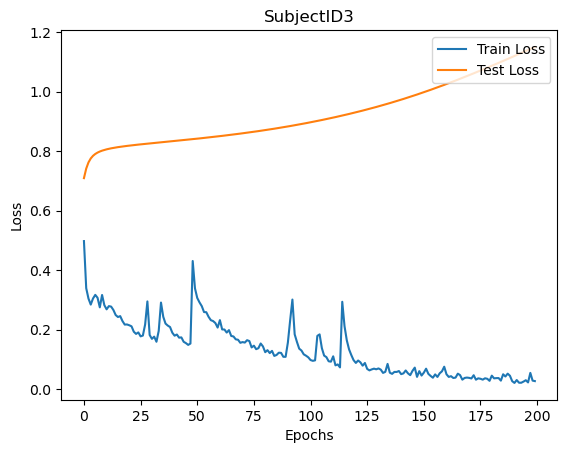

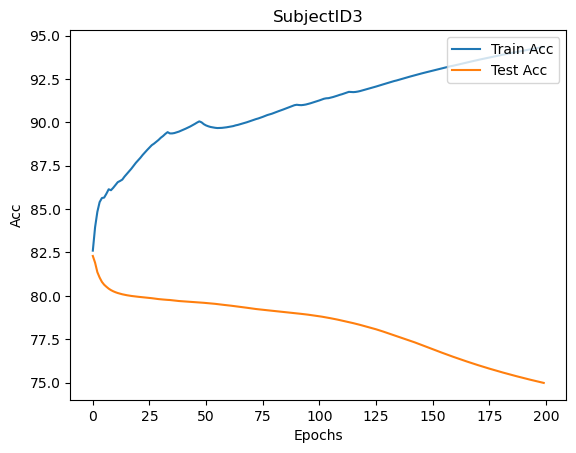

| epoch   0 | 0.2928 s/epoch | train loss 0.5062
| epoch   1 | 0.2926 s/epoch | train loss 0.4292
| epoch   2 | 0.2923 s/epoch | train loss 0.3442
| epoch   3 | 0.2942 s/epoch | train loss 0.3051
| epoch   4 | 0.2917 s/epoch | train loss 0.3274
| epoch   5 | 0.2930 s/epoch | train loss 0.4245
| epoch   6 | 0.2931 s/epoch | train loss 0.4216
| epoch   7 | 0.2925 s/epoch | train loss 0.3296
| epoch   8 | 0.2931 s/epoch | train loss 0.3011
| epoch   9 | 0.2927 s/epoch | train loss 0.2895
| epoch  10 | 0.2924 s/epoch | train loss 0.2732
| epoch  11 | 0.2930 s/epoch | train loss 0.2658
| epoch  12 | 0.2949 s/epoch | train loss 0.2872
| epoch  13 | 0.2926 s/epoch | train loss 0.2690
| epoch  14 | 0.2949 s/epoch | train loss 0.2591
| epoch  15 | 0.2925 s/epoch | train loss 0.2395
| epoch  16 | 0.2950 s/epoch | train loss 0.2547
| epoch  17 | 0.2954 s/epoch | train loss 0.2222
| epoch  18 | 0.2940 s/epoch | train loss 0.2119
| epoch  19 | 0.2958 s/epoch | train loss 0.2203
| epoch  20 | 0.2925

| epoch 168 | 0.2946 s/epoch | train loss 0.0461
| epoch 169 | 0.2933 s/epoch | train loss 0.0631
| epoch 170 | 0.2957 s/epoch | train loss 0.0393
| epoch 171 | 0.2940 s/epoch | train loss 0.0361
| epoch 172 | 0.2966 s/epoch | train loss 0.0489
| epoch 173 | 0.2927 s/epoch | train loss 0.1089
| epoch 174 | 0.2927 s/epoch | train loss 0.0439
| epoch 175 | 0.2941 s/epoch | train loss 0.0372
| epoch 176 | 0.2935 s/epoch | train loss 0.0303
| epoch 177 | 0.2942 s/epoch | train loss 0.0339
| epoch 178 | 0.2964 s/epoch | train loss 0.0292
| epoch 179 | 0.2951 s/epoch | train loss 0.0425
| epoch 180 | 0.2930 s/epoch | train loss 0.0377
| epoch 181 | 0.2945 s/epoch | train loss 0.0606
| epoch 182 | 0.2969 s/epoch | train loss 0.0696
| epoch 183 | 0.2916 s/epoch | train loss 0.0422
| epoch 184 | 0.2950 s/epoch | train loss 0.0383
| epoch 185 | 0.2964 s/epoch | train loss 0.0310
| epoch 186 | 0.2963 s/epoch | train loss 0.0315
| epoch 187 | 0.2959 s/epoch | train loss 0.0281
| epoch 188 | 0.2946

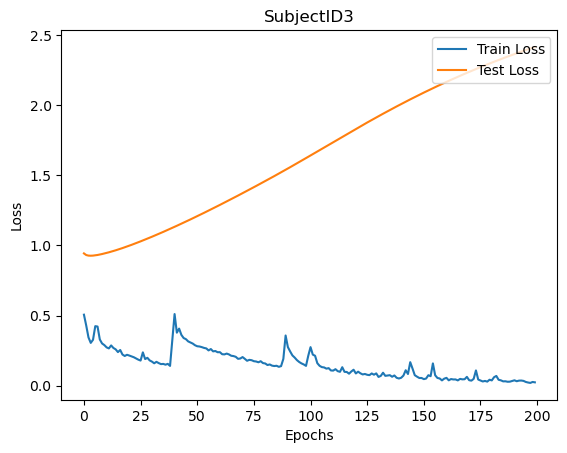

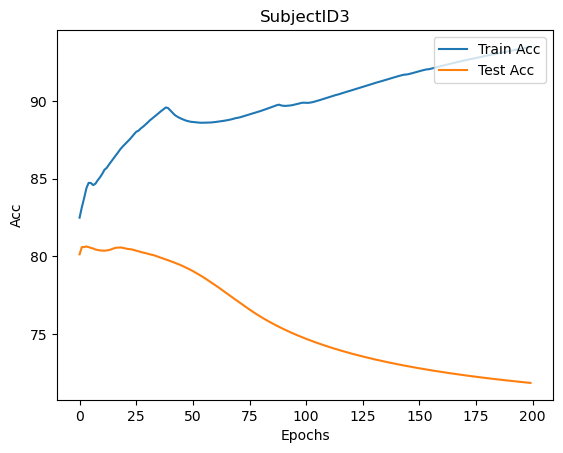


Subject 4
device: cuda
| epoch   0 | 0.3106 s/epoch | train loss 0.5285
| epoch   1 | 0.3106 s/epoch | train loss 0.3585
| epoch   2 | 0.3100 s/epoch | train loss 0.3075
| epoch   3 | 0.3079 s/epoch | train loss 0.3059
| epoch   4 | 0.3077 s/epoch | train loss 0.2832
| epoch   5 | 0.3080 s/epoch | train loss 0.2723
| epoch   6 | 0.3075 s/epoch | train loss 0.2579
| epoch   7 | 0.3087 s/epoch | train loss 0.2587
| epoch   8 | 0.3093 s/epoch | train loss 0.3141
| epoch   9 | 0.3079 s/epoch | train loss 0.3608
| epoch  10 | 0.3088 s/epoch | train loss 0.3296
| epoch  11 | 0.3098 s/epoch | train loss 0.3001
| epoch  12 | 0.3087 s/epoch | train loss 0.2838
| epoch  13 | 0.3096 s/epoch | train loss 0.2858
| epoch  14 | 0.3074 s/epoch | train loss 0.2719
| epoch  15 | 0.3124 s/epoch | train loss 0.2568
| epoch  16 | 0.3107 s/epoch | train loss 0.2452
| epoch  17 | 0.3093 s/epoch | train loss 0.2536
| epoch  18 | 0.3071 s/epoch | train loss 0.2419
| epoch  19 | 0.3087 s/epoch | train loss 0.2

| epoch 167 | 0.3067 s/epoch | train loss 0.0821
| epoch 168 | 0.3108 s/epoch | train loss 0.0976
| epoch 169 | 0.3076 s/epoch | train loss 0.1581
| epoch 170 | 0.3104 s/epoch | train loss 0.1002
| epoch 171 | 0.3084 s/epoch | train loss 0.0874
| epoch 172 | 0.3100 s/epoch | train loss 0.0839
| epoch 173 | 0.3061 s/epoch | train loss 0.0812
| epoch 174 | 0.3076 s/epoch | train loss 0.0827
| epoch 175 | 0.3093 s/epoch | train loss 0.0718
| epoch 176 | 0.3092 s/epoch | train loss 0.0871
| epoch 177 | 0.3078 s/epoch | train loss 0.0769
| epoch 178 | 0.3119 s/epoch | train loss 0.0820
| epoch 179 | 0.3125 s/epoch | train loss 0.0670
| epoch 180 | 0.3118 s/epoch | train loss 0.0831
| epoch 181 | 0.3102 s/epoch | train loss 0.0761
| epoch 182 | 0.3076 s/epoch | train loss 0.0893
| epoch 183 | 0.3125 s/epoch | train loss 0.0776
| epoch 184 | 0.3063 s/epoch | train loss 0.0665
| epoch 185 | 0.3101 s/epoch | train loss 0.0849
| epoch 186 | 0.3081 s/epoch | train loss 0.0609
| epoch 187 | 0.3089

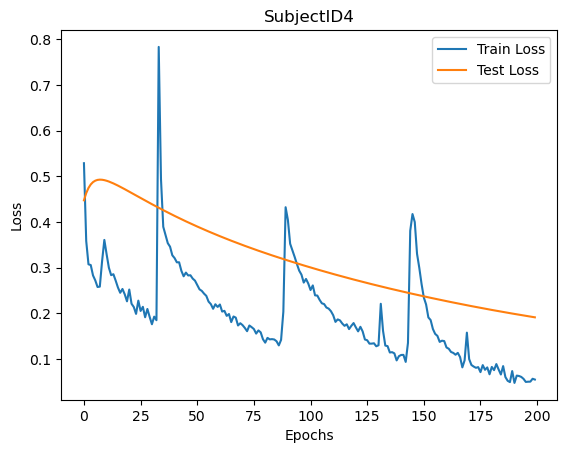

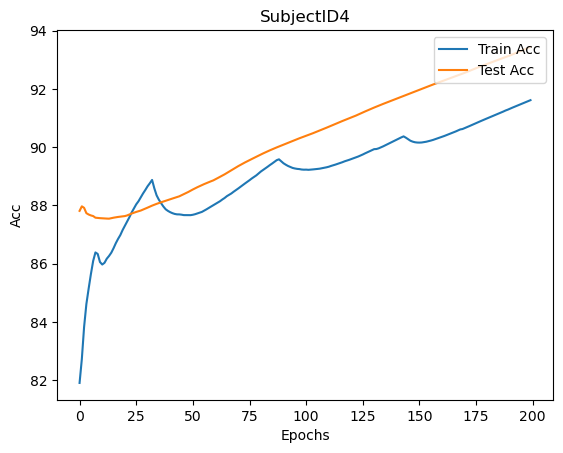

| epoch   0 | 0.3063 s/epoch | train loss 0.4798
| epoch   1 | 0.3084 s/epoch | train loss 0.3633
| epoch   2 | 0.3069 s/epoch | train loss 0.3200
| epoch   3 | 0.3067 s/epoch | train loss 0.3100
| epoch   4 | 0.3063 s/epoch | train loss 0.3635
| epoch   5 | 0.3115 s/epoch | train loss 0.3675
| epoch   6 | 0.3082 s/epoch | train loss 0.3736
| epoch   7 | 0.3054 s/epoch | train loss 0.4011
| epoch   8 | 0.3057 s/epoch | train loss 0.3386
| epoch   9 | 0.3092 s/epoch | train loss 0.3230
| epoch  10 | 0.3100 s/epoch | train loss 0.3067
| epoch  11 | 0.3059 s/epoch | train loss 0.3067
| epoch  12 | 0.3095 s/epoch | train loss 0.2916
| epoch  13 | 0.3067 s/epoch | train loss 0.2750
| epoch  14 | 0.3073 s/epoch | train loss 0.2661
| epoch  15 | 0.3071 s/epoch | train loss 0.2639
| epoch  16 | 0.3101 s/epoch | train loss 0.2588
| epoch  17 | 0.3081 s/epoch | train loss 0.2528
| epoch  18 | 0.3089 s/epoch | train loss 0.2459
| epoch  19 | 0.3083 s/epoch | train loss 0.2476
| epoch  20 | 0.3109

| epoch 168 | 0.3076 s/epoch | train loss 0.0392
| epoch 169 | 0.3065 s/epoch | train loss 0.0305
| epoch 170 | 0.3117 s/epoch | train loss 0.0424
| epoch 171 | 0.3104 s/epoch | train loss 0.0354
| epoch 172 | 0.3093 s/epoch | train loss 0.0320
| epoch 173 | 0.3095 s/epoch | train loss 0.0364
| epoch 174 | 0.3102 s/epoch | train loss 0.0357
| epoch 175 | 0.3078 s/epoch | train loss 0.0483
| epoch 176 | 0.3095 s/epoch | train loss 0.0399
| epoch 177 | 0.3085 s/epoch | train loss 0.0308
| epoch 178 | 0.3082 s/epoch | train loss 0.0328
| epoch 179 | 0.3110 s/epoch | train loss 0.0344
| epoch 180 | 0.3089 s/epoch | train loss 0.0326
| epoch 181 | 0.3125 s/epoch | train loss 0.0402
| epoch 182 | 0.3085 s/epoch | train loss 0.0326
| epoch 183 | 0.3094 s/epoch | train loss 0.0351
| epoch 184 | 0.3096 s/epoch | train loss 0.0299
| epoch 185 | 0.3077 s/epoch | train loss 0.0293
| epoch 186 | 0.3078 s/epoch | train loss 0.0402
| epoch 187 | 0.3092 s/epoch | train loss 0.0418
| epoch 188 | 0.3075

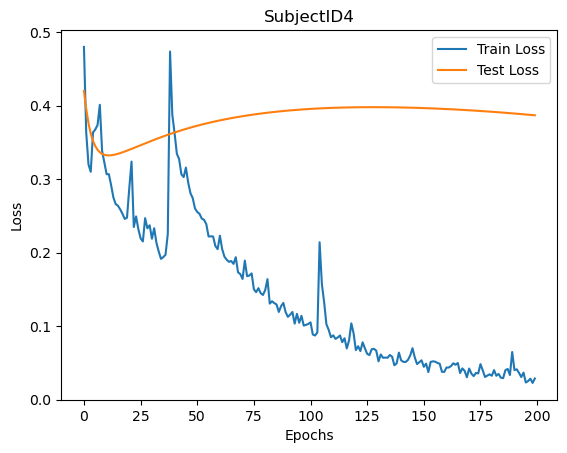

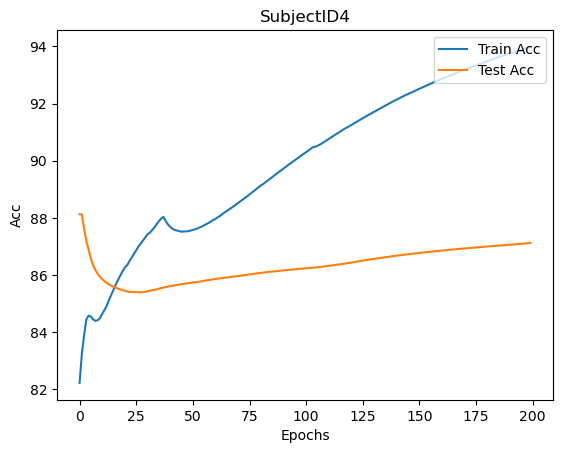


Subject 5
device: cuda
| epoch   0 | 0.2966 s/epoch | train loss 0.4779
| epoch   1 | 0.2954 s/epoch | train loss 0.3337
| epoch   2 | 0.2937 s/epoch | train loss 0.3206
| epoch   3 | 0.2939 s/epoch | train loss 0.3144
| epoch   4 | 0.2983 s/epoch | train loss 0.3006
| epoch   5 | 0.2949 s/epoch | train loss 0.2747
| epoch   6 | 0.2915 s/epoch | train loss 0.2747
| epoch   7 | 0.2935 s/epoch | train loss 0.2644
| epoch   8 | 0.2957 s/epoch | train loss 0.2473
| epoch   9 | 0.2968 s/epoch | train loss 0.2429
| epoch  10 | 0.2952 s/epoch | train loss 0.2449
| epoch  11 | 0.2942 s/epoch | train loss 0.2627
| epoch  12 | 0.2967 s/epoch | train loss 0.2348
| epoch  13 | 0.2944 s/epoch | train loss 0.2300
| epoch  14 | 0.2950 s/epoch | train loss 0.2410
| epoch  15 | 0.2969 s/epoch | train loss 0.2160
| epoch  16 | 0.2950 s/epoch | train loss 0.2147
| epoch  17 | 0.2959 s/epoch | train loss 0.2488
| epoch  18 | 0.2947 s/epoch | train loss 0.2085
| epoch  19 | 0.2979 s/epoch | train loss 0.2

| epoch 167 | 0.2950 s/epoch | train loss 0.0471
| epoch 168 | 0.2949 s/epoch | train loss 0.0430
| epoch 169 | 0.3005 s/epoch | train loss 0.0476
| epoch 170 | 0.2947 s/epoch | train loss 0.0484
| epoch 171 | 0.2963 s/epoch | train loss 0.0409
| epoch 172 | 0.2952 s/epoch | train loss 0.0497
| epoch 173 | 0.2967 s/epoch | train loss 0.0446
| epoch 174 | 0.2962 s/epoch | train loss 0.0510
| epoch 175 | 0.2958 s/epoch | train loss 0.0402
| epoch 176 | 0.2960 s/epoch | train loss 0.0304
| epoch 177 | 0.2966 s/epoch | train loss 0.0417
| epoch 178 | 0.2965 s/epoch | train loss 0.0400
| epoch 179 | 0.2965 s/epoch | train loss 0.0438
| epoch 180 | 0.2967 s/epoch | train loss 0.0328
| epoch 181 | 0.2968 s/epoch | train loss 0.0469
| epoch 182 | 0.2960 s/epoch | train loss 0.0337
| epoch 183 | 0.2979 s/epoch | train loss 0.0396
| epoch 184 | 0.2958 s/epoch | train loss 0.0406
| epoch 185 | 0.2946 s/epoch | train loss 0.0296
| epoch 186 | 0.2961 s/epoch | train loss 0.0332
| epoch 187 | 0.2974

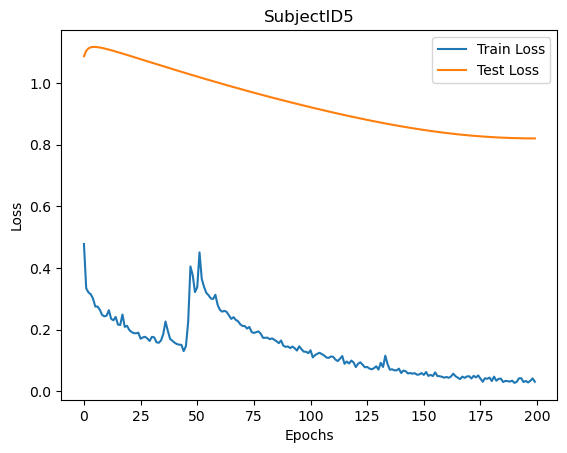

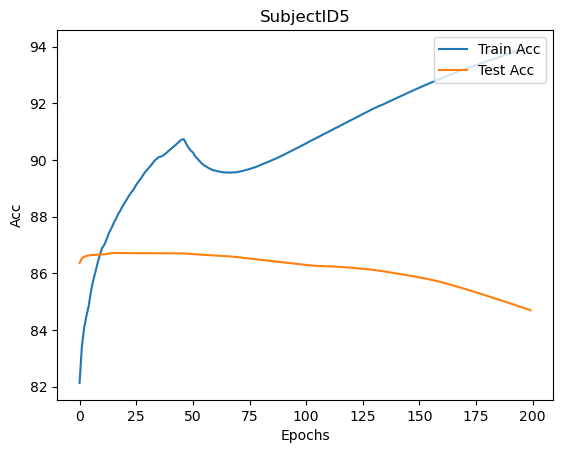

| epoch   0 | 0.2955 s/epoch | train loss 0.4884
| epoch   1 | 0.2926 s/epoch | train loss 0.3661
| epoch   2 | 0.2956 s/epoch | train loss 0.3195
| epoch   3 | 0.2938 s/epoch | train loss 0.2902
| epoch   4 | 0.2956 s/epoch | train loss 0.2960
| epoch   5 | 0.2948 s/epoch | train loss 0.2713
| epoch   6 | 0.2922 s/epoch | train loss 0.2862
| epoch   7 | 0.2961 s/epoch | train loss 0.2857
| epoch   8 | 0.2937 s/epoch | train loss 0.2645
| epoch   9 | 0.2944 s/epoch | train loss 0.2555
| epoch  10 | 0.2953 s/epoch | train loss 0.2378
| epoch  11 | 0.2958 s/epoch | train loss 0.2346
| epoch  12 | 0.2951 s/epoch | train loss 0.2310
| epoch  13 | 0.2929 s/epoch | train loss 0.2186
| epoch  14 | 0.2925 s/epoch | train loss 0.2151
| epoch  15 | 0.2915 s/epoch | train loss 0.2266
| epoch  16 | 0.2951 s/epoch | train loss 0.2138
| epoch  17 | 0.2983 s/epoch | train loss 0.2145
| epoch  18 | 0.2944 s/epoch | train loss 0.2019
| epoch  19 | 0.2944 s/epoch | train loss 0.2029
| epoch  20 | 0.2974

| epoch 168 | 0.2966 s/epoch | train loss 0.0486
| epoch 169 | 0.2982 s/epoch | train loss 0.0580
| epoch 170 | 0.2965 s/epoch | train loss 0.0520
| epoch 171 | 0.2931 s/epoch | train loss 0.0430
| epoch 172 | 0.2930 s/epoch | train loss 0.0424
| epoch 173 | 0.2955 s/epoch | train loss 0.0519
| epoch 174 | 0.2967 s/epoch | train loss 0.0439
| epoch 175 | 0.2944 s/epoch | train loss 0.0397
| epoch 176 | 0.2944 s/epoch | train loss 0.0451
| epoch 177 | 0.2934 s/epoch | train loss 0.0450
| epoch 178 | 0.2948 s/epoch | train loss 0.0900
| epoch 179 | 0.2964 s/epoch | train loss 0.0473
| epoch 180 | 0.2945 s/epoch | train loss 0.0643
| epoch 181 | 0.2955 s/epoch | train loss 0.0506
| epoch 182 | 0.2954 s/epoch | train loss 0.0526
| epoch 183 | 0.2955 s/epoch | train loss 0.0493
| epoch 184 | 0.2935 s/epoch | train loss 0.0445
| epoch 185 | 0.2957 s/epoch | train loss 0.0365
| epoch 186 | 0.2952 s/epoch | train loss 0.0397
| epoch 187 | 0.2976 s/epoch | train loss 0.0414
| epoch 188 | 0.2956

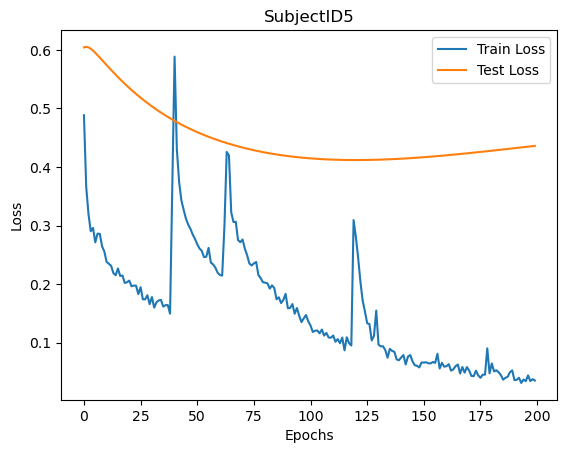

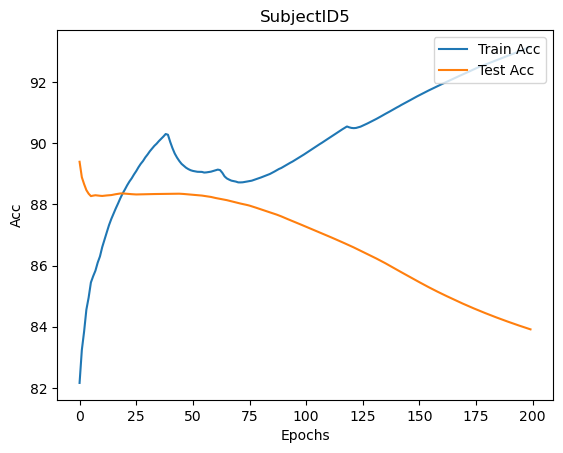


Subject 7
device: cuda
| epoch   0 | 0.2891 s/epoch | train loss 0.4583
| epoch   1 | 0.2892 s/epoch | train loss 0.3288
| epoch   2 | 0.2902 s/epoch | train loss 0.3104
| epoch   3 | 0.2920 s/epoch | train loss 0.2984
| epoch   4 | 0.2884 s/epoch | train loss 0.2816
| epoch   5 | 0.2888 s/epoch | train loss 0.2693
| epoch   6 | 0.2884 s/epoch | train loss 0.2704
| epoch   7 | 0.2899 s/epoch | train loss 0.2553
| epoch   8 | 0.2868 s/epoch | train loss 0.2414
| epoch   9 | 0.2909 s/epoch | train loss 0.2419
| epoch  10 | 0.2883 s/epoch | train loss 0.2810
| epoch  11 | 0.2921 s/epoch | train loss 0.2957
| epoch  12 | 0.2913 s/epoch | train loss 0.3113
| epoch  13 | 0.2913 s/epoch | train loss 0.2919
| epoch  14 | 0.2890 s/epoch | train loss 0.2660
| epoch  15 | 0.2904 s/epoch | train loss 0.2598
| epoch  16 | 0.2886 s/epoch | train loss 0.2480
| epoch  17 | 0.2897 s/epoch | train loss 0.2364
| epoch  18 | 0.2895 s/epoch | train loss 0.2474
| epoch  19 | 0.2908 s/epoch | train loss 0.2

| epoch 167 | 0.2851 s/epoch | train loss 0.0207
| epoch 168 | 0.2880 s/epoch | train loss 0.0233
| epoch 169 | 0.2901 s/epoch | train loss 0.0319
| epoch 170 | 0.2879 s/epoch | train loss 0.0128
| epoch 171 | 0.2917 s/epoch | train loss 0.0431
| epoch 172 | 0.2977 s/epoch | train loss 0.0347
| epoch 173 | 0.3420 s/epoch | train loss 0.0244
| epoch 174 | 0.3103 s/epoch | train loss 0.0348
| epoch 175 | 0.3061 s/epoch | train loss 0.0215
| epoch 176 | 0.3063 s/epoch | train loss 0.0308
| epoch 177 | 0.3031 s/epoch | train loss 0.0272
| epoch 178 | 0.2915 s/epoch | train loss 0.0167
| epoch 179 | 0.2953 s/epoch | train loss 0.0180
| epoch 180 | 0.3015 s/epoch | train loss 0.0249
| epoch 181 | 0.3017 s/epoch | train loss 0.0274
| epoch 182 | 0.3808 s/epoch | train loss 0.0212
| epoch 183 | 0.4414 s/epoch | train loss 0.0303
| epoch 184 | 0.3100 s/epoch | train loss 0.0232
| epoch 185 | 0.3139 s/epoch | train loss 0.0229
| epoch 186 | 0.5807 s/epoch | train loss 0.0222
| epoch 187 | 0.3194

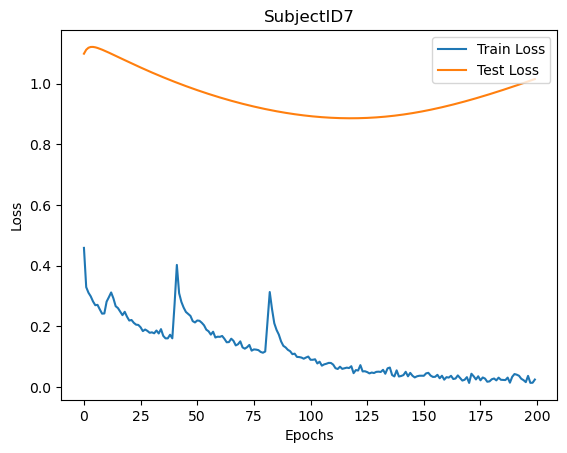

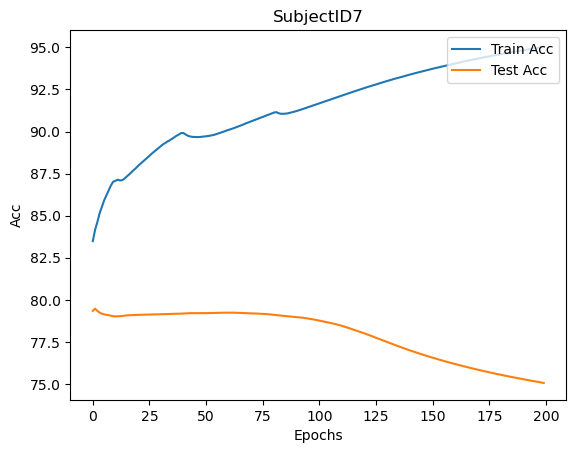

| epoch   0 | 0.2947 s/epoch | train loss 0.4657
| epoch   1 | 0.2934 s/epoch | train loss 0.3905
| epoch   2 | 0.2960 s/epoch | train loss 0.3173
| epoch   3 | 0.2963 s/epoch | train loss 0.3057
| epoch   4 | 0.2949 s/epoch | train loss 0.3008
| epoch   5 | 0.2958 s/epoch | train loss 0.2924
| epoch   6 | 0.2945 s/epoch | train loss 0.2851
| epoch   7 | 0.2955 s/epoch | train loss 0.2783
| epoch   8 | 0.2965 s/epoch | train loss 0.2549
| epoch   9 | 0.2931 s/epoch | train loss 0.2587
| epoch  10 | 0.2941 s/epoch | train loss 0.2602
| epoch  11 | 0.2950 s/epoch | train loss 0.2416
| epoch  12 | 0.2911 s/epoch | train loss 0.2320
| epoch  13 | 0.2932 s/epoch | train loss 0.2475
| epoch  14 | 0.2886 s/epoch | train loss 0.2342
| epoch  15 | 0.2893 s/epoch | train loss 0.2186
| epoch  16 | 0.2896 s/epoch | train loss 0.2181
| epoch  17 | 0.2917 s/epoch | train loss 0.2076
| epoch  18 | 0.2897 s/epoch | train loss 0.2108
| epoch  19 | 0.2907 s/epoch | train loss 0.3800
| epoch  20 | 0.2890

| epoch 168 | 0.2620 s/epoch | train loss 0.0506
| epoch 169 | 0.2635 s/epoch | train loss 0.0621
| epoch 170 | 0.2653 s/epoch | train loss 0.0630
| epoch 171 | 0.2649 s/epoch | train loss 0.0520
| epoch 172 | 0.2642 s/epoch | train loss 0.0588
| epoch 173 | 0.2646 s/epoch | train loss 0.1159
| epoch 174 | 0.2637 s/epoch | train loss 0.1034
| epoch 175 | 0.2659 s/epoch | train loss 0.0634
| epoch 176 | 0.2637 s/epoch | train loss 0.0575
| epoch 177 | 0.2645 s/epoch | train loss 0.0495
| epoch 178 | 0.2647 s/epoch | train loss 0.0452
| epoch 179 | 0.2657 s/epoch | train loss 0.0495
| epoch 180 | 0.2655 s/epoch | train loss 0.0583
| epoch 181 | 0.2645 s/epoch | train loss 0.0564
| epoch 182 | 0.2633 s/epoch | train loss 0.0511
| epoch 183 | 0.2638 s/epoch | train loss 0.0473
| epoch 184 | 0.2636 s/epoch | train loss 0.0433
| epoch 185 | 0.2642 s/epoch | train loss 0.0439
| epoch 186 | 0.2636 s/epoch | train loss 0.0380
| epoch 187 | 0.2669 s/epoch | train loss 0.0361
| epoch 188 | 0.2634

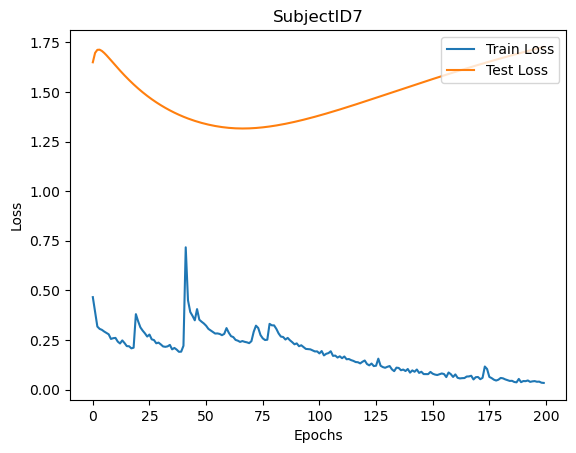

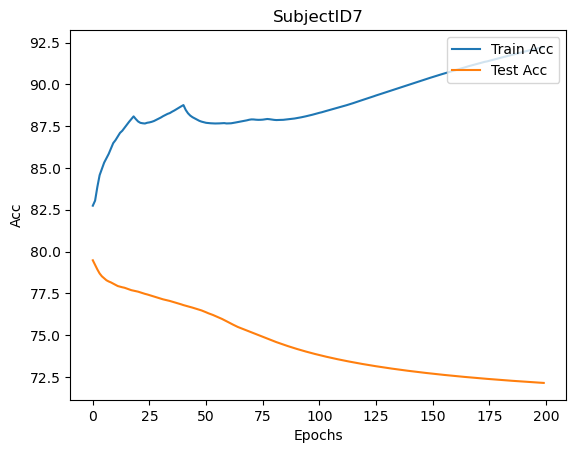


Subject 8
device: cuda
| epoch   0 | 0.2780 s/epoch | train loss 0.4643
| epoch   1 | 0.2769 s/epoch | train loss 0.3484
| epoch   2 | 0.2762 s/epoch | train loss 0.3255
| epoch   3 | 0.2748 s/epoch | train loss 0.3158
| epoch   4 | 0.2783 s/epoch | train loss 0.3051
| epoch   5 | 0.2758 s/epoch | train loss 0.2900
| epoch   6 | 0.2783 s/epoch | train loss 0.3111
| epoch   7 | 0.2771 s/epoch | train loss 0.3445
| epoch   8 | 0.2768 s/epoch | train loss 0.3146
| epoch   9 | 0.2756 s/epoch | train loss 0.3068
| epoch  10 | 0.2769 s/epoch | train loss 0.2871
| epoch  11 | 0.2760 s/epoch | train loss 0.2822
| epoch  12 | 0.2770 s/epoch | train loss 0.2696
| epoch  13 | 0.2766 s/epoch | train loss 0.2582
| epoch  14 | 0.2785 s/epoch | train loss 0.2556
| epoch  15 | 0.2749 s/epoch | train loss 0.2395
| epoch  16 | 0.2786 s/epoch | train loss 0.2404
| epoch  17 | 0.2759 s/epoch | train loss 0.2322
| epoch  18 | 0.2775 s/epoch | train loss 0.2259
| epoch  19 | 0.2776 s/epoch | train loss 0.2

| epoch 167 | 0.2782 s/epoch | train loss 0.0552
| epoch 168 | 0.2767 s/epoch | train loss 0.1120
| epoch 169 | 0.2761 s/epoch | train loss 0.0707
| epoch 170 | 0.2762 s/epoch | train loss 0.0503
| epoch 171 | 0.2781 s/epoch | train loss 0.0455
| epoch 172 | 0.2773 s/epoch | train loss 0.0485
| epoch 173 | 0.2769 s/epoch | train loss 0.0429
| epoch 174 | 0.2783 s/epoch | train loss 0.0496
| epoch 175 | 0.2762 s/epoch | train loss 0.0394
| epoch 176 | 0.2780 s/epoch | train loss 0.0409
| epoch 177 | 0.2782 s/epoch | train loss 0.0526
| epoch 178 | 0.2755 s/epoch | train loss 0.0606
| epoch 179 | 0.2781 s/epoch | train loss 0.0348
| epoch 180 | 0.2781 s/epoch | train loss 0.0419
| epoch 181 | 0.2761 s/epoch | train loss 0.0322
| epoch 182 | 0.2757 s/epoch | train loss 0.0274
| epoch 183 | 0.2782 s/epoch | train loss 0.0374
| epoch 184 | 0.2769 s/epoch | train loss 0.0463
| epoch 185 | 0.2775 s/epoch | train loss 0.0368
| epoch 186 | 0.2771 s/epoch | train loss 0.0365
| epoch 187 | 0.2763

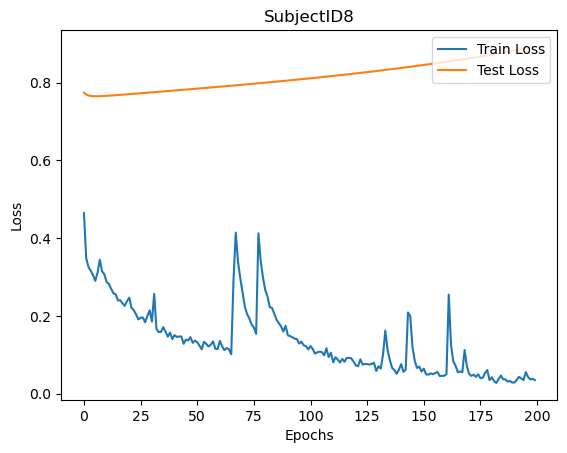

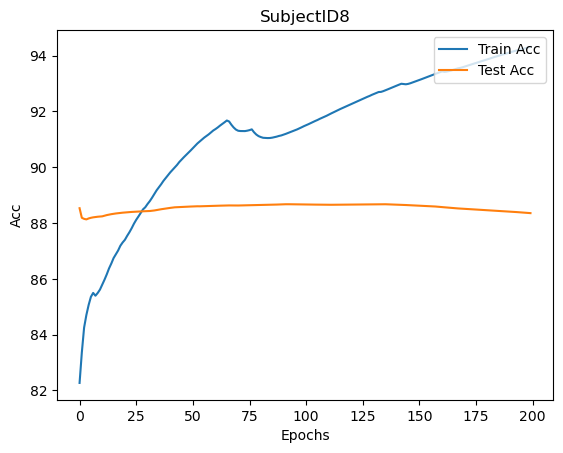

| epoch   0 | 0.2780 s/epoch | train loss 0.4231
| epoch   1 | 0.2780 s/epoch | train loss 0.3530
| epoch   2 | 0.2759 s/epoch | train loss 0.3204
| epoch   3 | 0.2773 s/epoch | train loss 0.3024
| epoch   4 | 0.2751 s/epoch | train loss 0.2818
| epoch   5 | 0.2753 s/epoch | train loss 0.3023
| epoch   6 | 0.2766 s/epoch | train loss 0.3157
| epoch   7 | 0.2757 s/epoch | train loss 0.2835
| epoch   8 | 0.2757 s/epoch | train loss 0.2648
| epoch   9 | 0.2759 s/epoch | train loss 0.3531
| epoch  10 | 0.2768 s/epoch | train loss 0.3433
| epoch  11 | 0.2749 s/epoch | train loss 0.3248
| epoch  12 | 0.2759 s/epoch | train loss 0.3027
| epoch  13 | 0.2774 s/epoch | train loss 0.2958
| epoch  14 | 0.2777 s/epoch | train loss 0.2847
| epoch  15 | 0.2741 s/epoch | train loss 0.2701
| epoch  16 | 0.2772 s/epoch | train loss 0.2648
| epoch  17 | 0.2774 s/epoch | train loss 0.2599
| epoch  18 | 0.2776 s/epoch | train loss 0.2493
| epoch  19 | 0.2758 s/epoch | train loss 0.2540
| epoch  20 | 0.2763

| epoch 168 | 0.2221 s/epoch | train loss 0.0627
| epoch 169 | 0.2210 s/epoch | train loss 0.1140
| epoch 170 | 0.2216 s/epoch | train loss 0.0971
| epoch 171 | 0.2238 s/epoch | train loss 0.0673
| epoch 172 | 0.2232 s/epoch | train loss 0.0634
| epoch 173 | 0.2222 s/epoch | train loss 0.0622
| epoch 174 | 0.2227 s/epoch | train loss 0.0645
| epoch 175 | 0.2223 s/epoch | train loss 0.0611
| epoch 176 | 0.2207 s/epoch | train loss 0.0635
| epoch 177 | 0.2214 s/epoch | train loss 0.0718
| epoch 178 | 0.2227 s/epoch | train loss 0.0558
| epoch 179 | 0.2219 s/epoch | train loss 0.0591
| epoch 180 | 0.2232 s/epoch | train loss 0.0469
| epoch 181 | 0.2228 s/epoch | train loss 0.0645
| epoch 182 | 0.2213 s/epoch | train loss 0.0541
| epoch 183 | 0.2223 s/epoch | train loss 0.0544
| epoch 184 | 0.2237 s/epoch | train loss 0.0597
| epoch 185 | 0.2217 s/epoch | train loss 0.0423
| epoch 186 | 0.2214 s/epoch | train loss 0.0447
| epoch 187 | 0.2228 s/epoch | train loss 0.0456
| epoch 188 | 0.2228

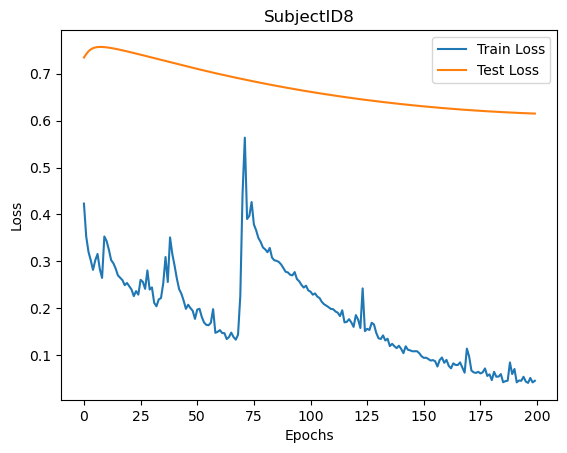

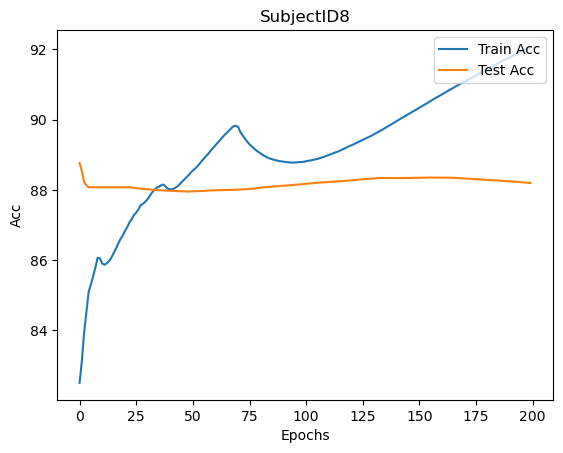


Subject 9
device: cuda
| epoch   0 | 0.2179 s/epoch | train loss 0.4939
| epoch   1 | 0.2177 s/epoch | train loss 0.3562
| epoch   2 | 0.2177 s/epoch | train loss 0.3303
| epoch   3 | 0.2186 s/epoch | train loss 0.3069
| epoch   4 | 0.2177 s/epoch | train loss 0.2902
| epoch   5 | 0.2174 s/epoch | train loss 0.2776
| epoch   6 | 0.2179 s/epoch | train loss 0.2699
| epoch   7 | 0.2165 s/epoch | train loss 0.2697
| epoch   8 | 0.2178 s/epoch | train loss 0.2593
| epoch   9 | 0.2178 s/epoch | train loss 0.2409
| epoch  10 | 0.2182 s/epoch | train loss 0.2354
| epoch  11 | 0.2177 s/epoch | train loss 0.2715
| epoch  12 | 0.2182 s/epoch | train loss 0.3453
| epoch  13 | 0.2180 s/epoch | train loss 0.3740
| epoch  14 | 0.2174 s/epoch | train loss 0.2941
| epoch  15 | 0.2176 s/epoch | train loss 0.2686
| epoch  16 | 0.2182 s/epoch | train loss 0.2499
| epoch  17 | 0.2184 s/epoch | train loss 0.2498
| epoch  18 | 0.2170 s/epoch | train loss 0.2222
| epoch  19 | 0.2175 s/epoch | train loss 0.2

| epoch 167 | 0.2173 s/epoch | train loss 0.0591
| epoch 168 | 0.2174 s/epoch | train loss 0.0569
| epoch 169 | 0.2161 s/epoch | train loss 0.0590
| epoch 170 | 0.2180 s/epoch | train loss 0.0589
| epoch 171 | 0.2195 s/epoch | train loss 0.0589
| epoch 172 | 0.2185 s/epoch | train loss 0.0664
| epoch 173 | 0.2204 s/epoch | train loss 0.0622
| epoch 174 | 0.2183 s/epoch | train loss 0.0513
| epoch 175 | 0.2188 s/epoch | train loss 0.0534
| epoch 176 | 0.2176 s/epoch | train loss 0.0623
| epoch 177 | 0.2178 s/epoch | train loss 0.0521
| epoch 178 | 0.2192 s/epoch | train loss 0.0513
| epoch 179 | 0.2182 s/epoch | train loss 0.0493
| epoch 180 | 0.2184 s/epoch | train loss 0.0393
| epoch 181 | 0.2183 s/epoch | train loss 0.0690
| epoch 182 | 0.2185 s/epoch | train loss 0.0554
| epoch 183 | 0.2190 s/epoch | train loss 0.0535
| epoch 184 | 0.2187 s/epoch | train loss 0.0480
| epoch 185 | 0.2182 s/epoch | train loss 0.0350
| epoch 186 | 0.2166 s/epoch | train loss 0.0555
| epoch 187 | 0.2181

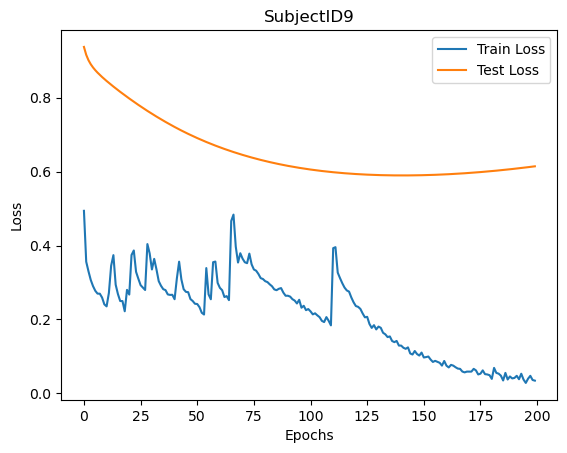

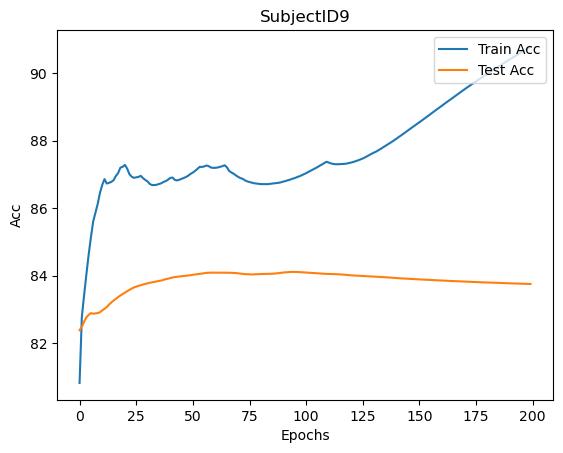

| epoch   0 | 0.2187 s/epoch | train loss 0.5063
| epoch   1 | 0.2176 s/epoch | train loss 0.3483
| epoch   2 | 0.2160 s/epoch | train loss 0.3752
| epoch   3 | 0.2193 s/epoch | train loss 0.3464
| epoch   4 | 0.2178 s/epoch | train loss 0.3144
| epoch   5 | 0.2166 s/epoch | train loss 0.2986
| epoch   6 | 0.2176 s/epoch | train loss 0.2834
| epoch   7 | 0.2183 s/epoch | train loss 0.2641
| epoch   8 | 0.2170 s/epoch | train loss 0.2696
| epoch   9 | 0.2191 s/epoch | train loss 0.2865
| epoch  10 | 0.2168 s/epoch | train loss 0.2570
| epoch  11 | 0.2167 s/epoch | train loss 0.2563
| epoch  12 | 0.2186 s/epoch | train loss 0.2445
| epoch  13 | 0.2172 s/epoch | train loss 0.2427
| epoch  14 | 0.2175 s/epoch | train loss 0.2218
| epoch  15 | 0.2180 s/epoch | train loss 0.2279
| epoch  16 | 0.2158 s/epoch | train loss 0.2153
| epoch  17 | 0.2172 s/epoch | train loss 0.2191
| epoch  18 | 0.2174 s/epoch | train loss 0.2290
| epoch  19 | 0.2171 s/epoch | train loss 0.2215
| epoch  20 | 0.2172

| epoch 168 | 0.2180 s/epoch | train loss 0.0436
| epoch 169 | 0.2176 s/epoch | train loss 0.0412
| epoch 170 | 0.2189 s/epoch | train loss 0.0338
| epoch 171 | 0.2175 s/epoch | train loss 0.0447
| epoch 172 | 0.2182 s/epoch | train loss 0.0360
| epoch 173 | 0.2172 s/epoch | train loss 0.0335
| epoch 174 | 0.2188 s/epoch | train loss 0.0294
| epoch 175 | 0.2198 s/epoch | train loss 0.0271
| epoch 176 | 0.2186 s/epoch | train loss 0.0259
| epoch 177 | 0.2187 s/epoch | train loss 0.0355
| epoch 178 | 0.2181 s/epoch | train loss 0.0333
| epoch 179 | 0.2186 s/epoch | train loss 0.0289
| epoch 180 | 0.2173 s/epoch | train loss 0.0348
| epoch 181 | 0.2188 s/epoch | train loss 0.0372
| epoch 182 | 0.2179 s/epoch | train loss 0.0379
| epoch 183 | 0.2181 s/epoch | train loss 0.0326
| epoch 184 | 0.2185 s/epoch | train loss 0.0336
| epoch 185 | 0.2179 s/epoch | train loss 0.0386
| epoch 186 | 0.2189 s/epoch | train loss 0.0287
| epoch 187 | 0.2179 s/epoch | train loss 0.0267
| epoch 188 | 0.2178

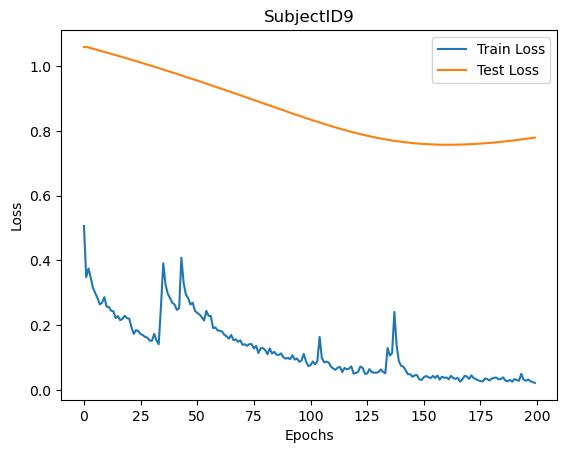

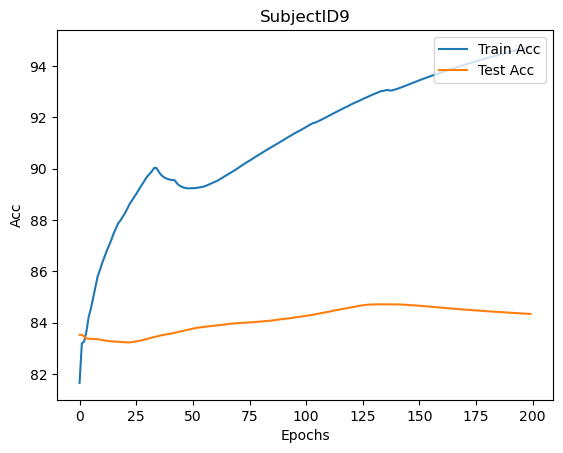


Subject 10
device: cuda
| epoch   0 | 0.2269 s/epoch | train loss 0.4852
| epoch   1 | 0.2250 s/epoch | train loss 0.4226
| epoch   2 | 0.2252 s/epoch | train loss 0.3593
| epoch   3 | 0.2258 s/epoch | train loss 0.3343
| epoch   4 | 0.2259 s/epoch | train loss 0.3388
| epoch   5 | 0.2270 s/epoch | train loss 0.3198
| epoch   6 | 0.2268 s/epoch | train loss 0.3170
| epoch   7 | 0.2250 s/epoch | train loss 0.2832
| epoch   8 | 0.2256 s/epoch | train loss 0.3217
| epoch   9 | 0.2255 s/epoch | train loss 0.4374
| epoch  10 | 0.2269 s/epoch | train loss 0.3270
| epoch  11 | 0.2246 s/epoch | train loss 0.2944
| epoch  12 | 0.2266 s/epoch | train loss 0.2773
| epoch  13 | 0.2263 s/epoch | train loss 0.2685
| epoch  14 | 0.2260 s/epoch | train loss 0.2832
| epoch  15 | 0.2262 s/epoch | train loss 0.2486
| epoch  16 | 0.2262 s/epoch | train loss 0.2731
| epoch  17 | 0.2259 s/epoch | train loss 0.2931
| epoch  18 | 0.2254 s/epoch | train loss 0.3706
| epoch  19 | 0.2265 s/epoch | train loss 0.

| epoch 167 | 0.2255 s/epoch | train loss 0.0424
| epoch 168 | 0.2270 s/epoch | train loss 0.0436
| epoch 169 | 0.2268 s/epoch | train loss 0.0455
| epoch 170 | 0.2263 s/epoch | train loss 0.0325
| epoch 171 | 0.2272 s/epoch | train loss 0.0366
| epoch 172 | 0.2259 s/epoch | train loss 0.0434
| epoch 173 | 0.2276 s/epoch | train loss 0.0362
| epoch 174 | 0.2262 s/epoch | train loss 0.0378
| epoch 175 | 0.2268 s/epoch | train loss 0.0384
| epoch 176 | 0.2259 s/epoch | train loss 0.0319
| epoch 177 | 0.2279 s/epoch | train loss 0.0312
| epoch 178 | 0.2270 s/epoch | train loss 0.0458
| epoch 179 | 0.2268 s/epoch | train loss 0.0477
| epoch 180 | 0.2263 s/epoch | train loss 0.0327
| epoch 181 | 0.2263 s/epoch | train loss 0.0281
| epoch 182 | 0.2264 s/epoch | train loss 0.0380
| epoch 183 | 0.2268 s/epoch | train loss 0.0250
| epoch 184 | 0.2258 s/epoch | train loss 0.0345
| epoch 185 | 0.2278 s/epoch | train loss 0.0291
| epoch 186 | 0.2277 s/epoch | train loss 0.0413
| epoch 187 | 0.2271

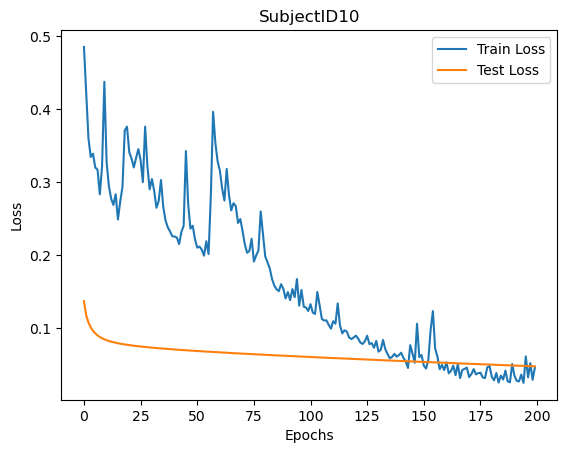

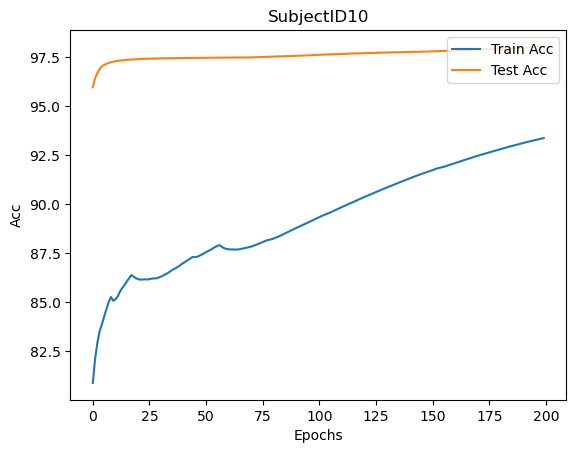

| epoch   0 | 0.2265 s/epoch | train loss 0.5072
| epoch   1 | 0.2256 s/epoch | train loss 0.3651
| epoch   2 | 0.2255 s/epoch | train loss 0.3457
| epoch   3 | 0.2263 s/epoch | train loss 0.3710
| epoch   4 | 0.2259 s/epoch | train loss 0.3209
| epoch   5 | 0.2259 s/epoch | train loss 0.2903
| epoch   6 | 0.2241 s/epoch | train loss 0.2940
| epoch   7 | 0.2251 s/epoch | train loss 0.3182
| epoch   8 | 0.2253 s/epoch | train loss 0.3303
| epoch   9 | 0.2250 s/epoch | train loss 0.2981
| epoch  10 | 0.2254 s/epoch | train loss 0.2672
| epoch  11 | 0.2261 s/epoch | train loss 0.2531
| epoch  12 | 0.2270 s/epoch | train loss 0.2530
| epoch  13 | 0.2256 s/epoch | train loss 0.2669
| epoch  14 | 0.2278 s/epoch | train loss 0.5164
| epoch  15 | 0.2249 s/epoch | train loss 0.7865
| epoch  16 | 0.2242 s/epoch | train loss 0.4751
| epoch  17 | 0.2265 s/epoch | train loss 0.4620
| epoch  18 | 0.2247 s/epoch | train loss 0.4444
| epoch  19 | 0.2245 s/epoch | train loss 0.4209
| epoch  20 | 0.2251

| epoch 168 | 0.2260 s/epoch | train loss 0.0776
| epoch 169 | 0.2251 s/epoch | train loss 0.0857
| epoch 170 | 0.2265 s/epoch | train loss 0.0683
| epoch 171 | 0.2262 s/epoch | train loss 0.0788
| epoch 172 | 0.2280 s/epoch | train loss 0.0626
| epoch 173 | 0.2262 s/epoch | train loss 0.0788
| epoch 174 | 0.2277 s/epoch | train loss 0.0759
| epoch 175 | 0.2256 s/epoch | train loss 0.0740
| epoch 176 | 0.2260 s/epoch | train loss 0.0666
| epoch 177 | 0.2250 s/epoch | train loss 0.1042
| epoch 178 | 0.2263 s/epoch | train loss 0.0644
| epoch 179 | 0.2262 s/epoch | train loss 0.0611
| epoch 180 | 0.2260 s/epoch | train loss 0.0605
| epoch 181 | 0.2259 s/epoch | train loss 0.0686
| epoch 182 | 0.2266 s/epoch | train loss 0.0669
| epoch 183 | 0.2275 s/epoch | train loss 0.0551
| epoch 184 | 0.2270 s/epoch | train loss 0.0659
| epoch 185 | 0.2254 s/epoch | train loss 0.0605
| epoch 186 | 0.2262 s/epoch | train loss 0.0625
| epoch 187 | 0.2262 s/epoch | train loss 0.0641
| epoch 188 | 0.2261

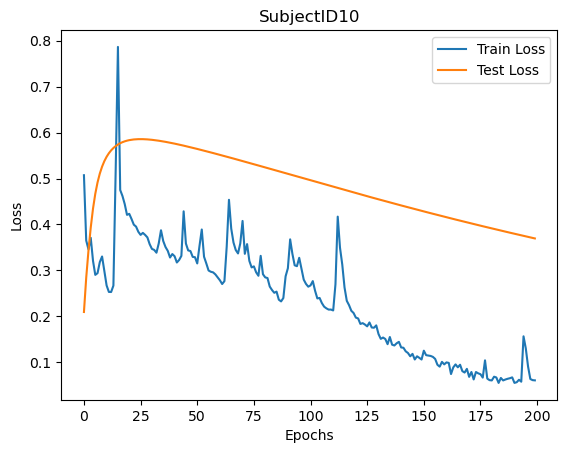

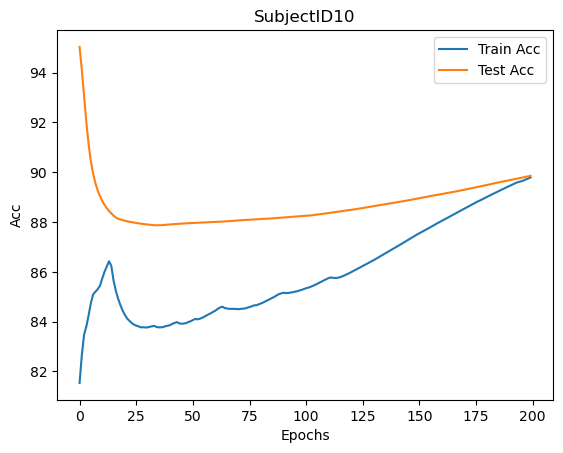


Subject 11
device: cuda
| epoch   0 | 0.2241 s/epoch | train loss 0.5152
| epoch   1 | 0.2233 s/epoch | train loss 0.3547
| epoch   2 | 0.2226 s/epoch | train loss 0.3335
| epoch   3 | 0.2231 s/epoch | train loss 0.3087
| epoch   4 | 0.2239 s/epoch | train loss 0.3015
| epoch   5 | 0.2226 s/epoch | train loss 0.2946
| epoch   6 | 0.2243 s/epoch | train loss 0.2823
| epoch   7 | 0.2239 s/epoch | train loss 0.2647
| epoch   8 | 0.2225 s/epoch | train loss 0.2656
| epoch   9 | 0.2235 s/epoch | train loss 0.2585
| epoch  10 | 0.2237 s/epoch | train loss 0.2566
| epoch  11 | 0.2237 s/epoch | train loss 0.3110
| epoch  12 | 0.2241 s/epoch | train loss 0.2726
| epoch  13 | 0.2236 s/epoch | train loss 0.2520
| epoch  14 | 0.2239 s/epoch | train loss 0.2489
| epoch  15 | 0.2230 s/epoch | train loss 0.2348
| epoch  16 | 0.2243 s/epoch | train loss 0.2584
| epoch  17 | 0.2244 s/epoch | train loss 0.2607
| epoch  18 | 0.2236 s/epoch | train loss 0.4731
| epoch  19 | 0.2232 s/epoch | train loss 0.

| epoch 167 | 0.2255 s/epoch | train loss 0.0666
| epoch 168 | 0.2233 s/epoch | train loss 0.0729
| epoch 169 | 0.2241 s/epoch | train loss 0.0614
| epoch 170 | 0.2237 s/epoch | train loss 0.0656
| epoch 171 | 0.2248 s/epoch | train loss 0.0659
| epoch 172 | 0.2238 s/epoch | train loss 0.0732
| epoch 173 | 0.2246 s/epoch | train loss 0.0737
| epoch 174 | 0.2236 s/epoch | train loss 0.0680
| epoch 175 | 0.2241 s/epoch | train loss 0.0659
| epoch 176 | 0.2245 s/epoch | train loss 0.0708
| epoch 177 | 0.2238 s/epoch | train loss 0.0687
| epoch 178 | 0.2254 s/epoch | train loss 0.0543
| epoch 179 | 0.2236 s/epoch | train loss 0.0589
| epoch 180 | 0.2237 s/epoch | train loss 0.0603
| epoch 181 | 0.2248 s/epoch | train loss 0.0581
| epoch 182 | 0.2239 s/epoch | train loss 0.0481
| epoch 183 | 0.2248 s/epoch | train loss 0.0587
| epoch 184 | 0.2238 s/epoch | train loss 0.0969
| epoch 185 | 0.2238 s/epoch | train loss 0.0638
| epoch 186 | 0.2266 s/epoch | train loss 0.0539
| epoch 187 | 0.2247

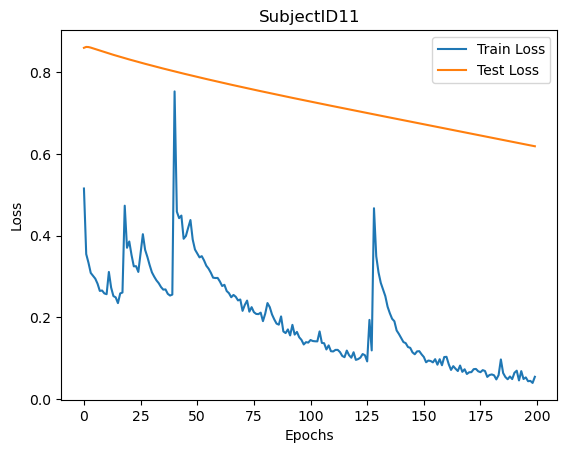

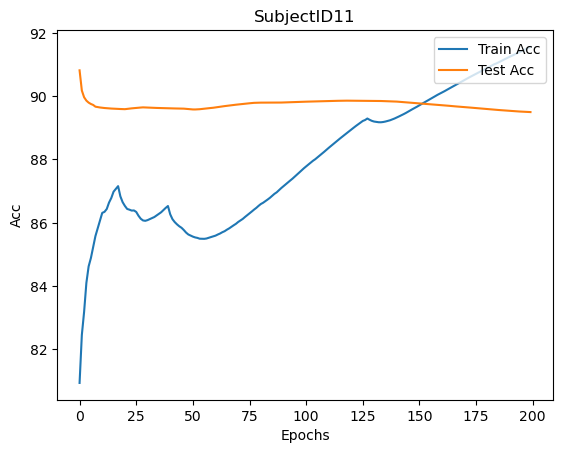

| epoch   0 | 0.2222 s/epoch | train loss 0.4844
| epoch   1 | 0.2230 s/epoch | train loss 0.3549
| epoch   2 | 0.2228 s/epoch | train loss 0.3405
| epoch   3 | 0.2237 s/epoch | train loss 0.3198
| epoch   4 | 0.2234 s/epoch | train loss 0.3042
| epoch   5 | 0.2230 s/epoch | train loss 0.2937
| epoch   6 | 0.2230 s/epoch | train loss 0.2821
| epoch   7 | 0.2235 s/epoch | train loss 0.3032
| epoch   8 | 0.2231 s/epoch | train loss 0.2902
| epoch   9 | 0.2228 s/epoch | train loss 0.2676
| epoch  10 | 0.2231 s/epoch | train loss 0.2447
| epoch  11 | 0.2222 s/epoch | train loss 0.2496
| epoch  12 | 0.2233 s/epoch | train loss 0.2653
| epoch  13 | 0.2242 s/epoch | train loss 0.2928
| epoch  14 | 0.2254 s/epoch | train loss 0.2644
| epoch  15 | 0.2225 s/epoch | train loss 0.2791
| epoch  16 | 0.2246 s/epoch | train loss 0.4274
| epoch  17 | 0.2229 s/epoch | train loss 0.3657
| epoch  18 | 0.2238 s/epoch | train loss 0.3062
| epoch  19 | 0.2224 s/epoch | train loss 0.3178
| epoch  20 | 0.2233

| epoch 168 | 0.2257 s/epoch | train loss 0.0457
| epoch 169 | 0.2239 s/epoch | train loss 0.0466
| epoch 170 | 0.2234 s/epoch | train loss 0.0336
| epoch 171 | 0.2240 s/epoch | train loss 0.0348
| epoch 172 | 0.2257 s/epoch | train loss 0.0482
| epoch 173 | 0.2238 s/epoch | train loss 0.0373
| epoch 174 | 0.2242 s/epoch | train loss 0.0388
| epoch 175 | 0.2228 s/epoch | train loss 0.0372
| epoch 176 | 0.2227 s/epoch | train loss 0.0516
| epoch 177 | 0.2244 s/epoch | train loss 0.0360
| epoch 178 | 0.2259 s/epoch | train loss 0.0388
| epoch 179 | 0.2255 s/epoch | train loss 0.0271
| epoch 180 | 0.2240 s/epoch | train loss 0.0349
| epoch 181 | 0.2229 s/epoch | train loss 0.0433
| epoch 182 | 0.2253 s/epoch | train loss 0.0445
| epoch 183 | 0.2249 s/epoch | train loss 0.0397
| epoch 184 | 0.2236 s/epoch | train loss 0.0442
| epoch 185 | 0.2253 s/epoch | train loss 0.0308
| epoch 186 | 0.2235 s/epoch | train loss 0.0377
| epoch 187 | 0.2234 s/epoch | train loss 0.0305
| epoch 188 | 0.2234

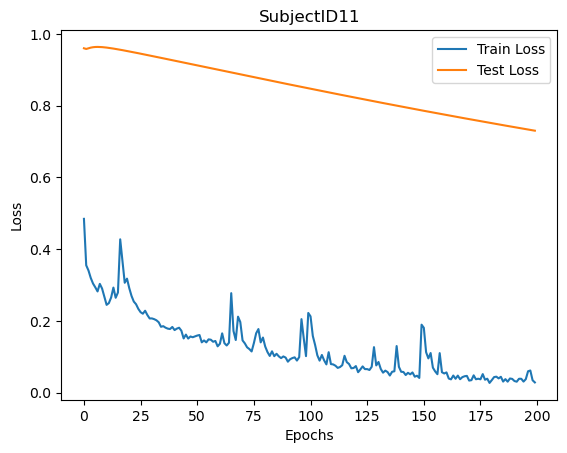

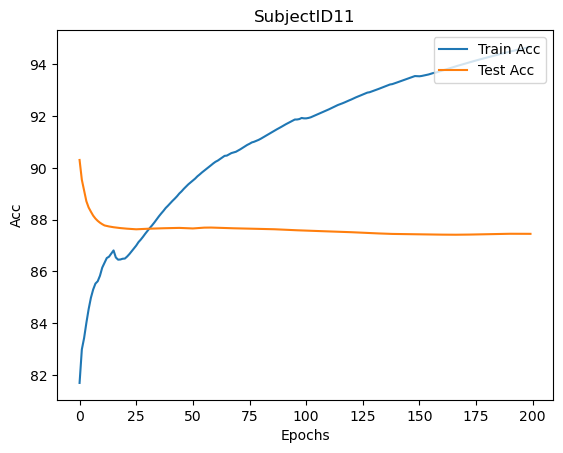


Subject 12
device: cuda
| epoch   0 | 0.2130 s/epoch | train loss 0.4972
| epoch   1 | 0.2132 s/epoch | train loss 0.3424
| epoch   2 | 0.2123 s/epoch | train loss 0.3212
| epoch   3 | 0.2124 s/epoch | train loss 0.3032
| epoch   4 | 0.2127 s/epoch | train loss 0.2937
| epoch   5 | 0.2135 s/epoch | train loss 0.2939
| epoch   6 | 0.2121 s/epoch | train loss 0.2702
| epoch   7 | 0.2133 s/epoch | train loss 0.2591
| epoch   8 | 0.2125 s/epoch | train loss 0.2463
| epoch   9 | 0.2148 s/epoch | train loss 0.2470
| epoch  10 | 0.2138 s/epoch | train loss 0.2567
| epoch  11 | 0.2123 s/epoch | train loss 0.2623
| epoch  12 | 0.2132 s/epoch | train loss 0.2570
| epoch  13 | 0.2138 s/epoch | train loss 0.2327
| epoch  14 | 0.2132 s/epoch | train loss 0.2323
| epoch  15 | 0.2145 s/epoch | train loss 0.2425
| epoch  16 | 0.2138 s/epoch | train loss 0.2334
| epoch  17 | 0.2127 s/epoch | train loss 0.2217
| epoch  18 | 0.2135 s/epoch | train loss 0.2339
| epoch  19 | 0.2138 s/epoch | train loss 0.

| epoch 167 | 0.2145 s/epoch | train loss 0.0840
| epoch 168 | 0.2141 s/epoch | train loss 0.0783
| epoch 169 | 0.2128 s/epoch | train loss 0.0729
| epoch 170 | 0.2142 s/epoch | train loss 0.1177
| epoch 171 | 0.2120 s/epoch | train loss 0.0817
| epoch 172 | 0.2160 s/epoch | train loss 0.0657
| epoch 173 | 0.2136 s/epoch | train loss 0.0664
| epoch 174 | 0.2134 s/epoch | train loss 0.0639
| epoch 175 | 0.2131 s/epoch | train loss 0.0764
| epoch 176 | 0.2140 s/epoch | train loss 0.0728
| epoch 177 | 0.2130 s/epoch | train loss 0.0571
| epoch 178 | 0.2126 s/epoch | train loss 0.1172
| epoch 179 | 0.2140 s/epoch | train loss 0.0927
| epoch 180 | 0.2135 s/epoch | train loss 0.0963
| epoch 181 | 0.2127 s/epoch | train loss 0.0615
| epoch 182 | 0.2141 s/epoch | train loss 0.0579
| epoch 183 | 0.2144 s/epoch | train loss 0.0652
| epoch 184 | 0.2127 s/epoch | train loss 0.0671
| epoch 185 | 0.2125 s/epoch | train loss 0.0783
| epoch 186 | 0.2128 s/epoch | train loss 0.0596
| epoch 187 | 0.2130

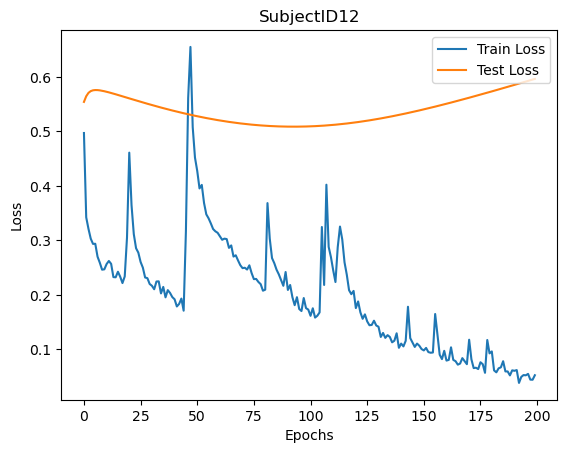

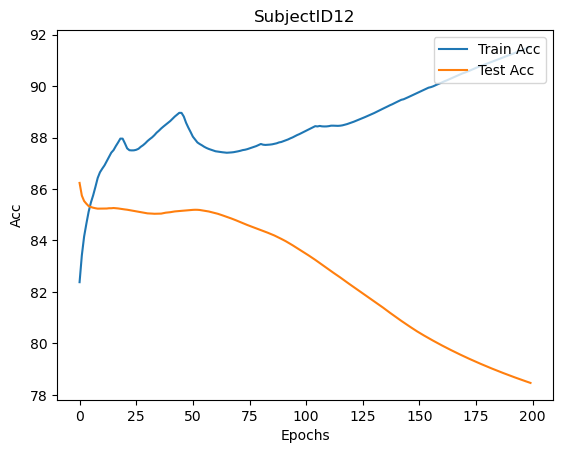

| epoch   0 | 0.2142 s/epoch | train loss 0.4520
| epoch   1 | 0.2135 s/epoch | train loss 0.3325
| epoch   2 | 0.2129 s/epoch | train loss 0.3136
| epoch   3 | 0.2126 s/epoch | train loss 0.2989
| epoch   4 | 0.2135 s/epoch | train loss 0.2801
| epoch   5 | 0.2133 s/epoch | train loss 0.2629
| epoch   6 | 0.2125 s/epoch | train loss 0.2785
| epoch   7 | 0.2134 s/epoch | train loss 0.2627
| epoch   8 | 0.2133 s/epoch | train loss 0.2570
| epoch   9 | 0.2132 s/epoch | train loss 0.2442
| epoch  10 | 0.2140 s/epoch | train loss 0.2513
| epoch  11 | 0.2134 s/epoch | train loss 0.2345
| epoch  12 | 0.2135 s/epoch | train loss 0.2353
| epoch  13 | 0.2120 s/epoch | train loss 0.2108
| epoch  14 | 0.2143 s/epoch | train loss 0.2741
| epoch  15 | 0.2123 s/epoch | train loss 0.3487
| epoch  16 | 0.2120 s/epoch | train loss 0.3207
| epoch  17 | 0.2126 s/epoch | train loss 0.3821
| epoch  18 | 0.2125 s/epoch | train loss 0.3450
| epoch  19 | 0.2128 s/epoch | train loss 0.4545
| epoch  20 | 0.2128

| epoch 168 | 0.2134 s/epoch | train loss 0.0550
| epoch 169 | 0.2138 s/epoch | train loss 0.0340
| epoch 170 | 0.2126 s/epoch | train loss 0.0403
| epoch 171 | 0.2134 s/epoch | train loss 0.0470
| epoch 172 | 0.2128 s/epoch | train loss 0.0359
| epoch 173 | 0.2118 s/epoch | train loss 0.0467
| epoch 174 | 0.2126 s/epoch | train loss 0.0416
| epoch 175 | 0.2134 s/epoch | train loss 0.0385
| epoch 176 | 0.2138 s/epoch | train loss 0.0376
| epoch 177 | 0.2122 s/epoch | train loss 0.0565
| epoch 178 | 0.2110 s/epoch | train loss 0.0477
| epoch 179 | 0.2125 s/epoch | train loss 0.0777
| epoch 180 | 0.2142 s/epoch | train loss 0.0519
| epoch 181 | 0.2131 s/epoch | train loss 0.0406
| epoch 182 | 0.2136 s/epoch | train loss 0.0287
| epoch 183 | 0.2129 s/epoch | train loss 0.0352
| epoch 184 | 0.2127 s/epoch | train loss 0.0275
| epoch 185 | 0.2125 s/epoch | train loss 0.0475
| epoch 186 | 0.2138 s/epoch | train loss 0.1775
| epoch 187 | 0.2147 s/epoch | train loss 0.1123
| epoch 188 | 0.2138

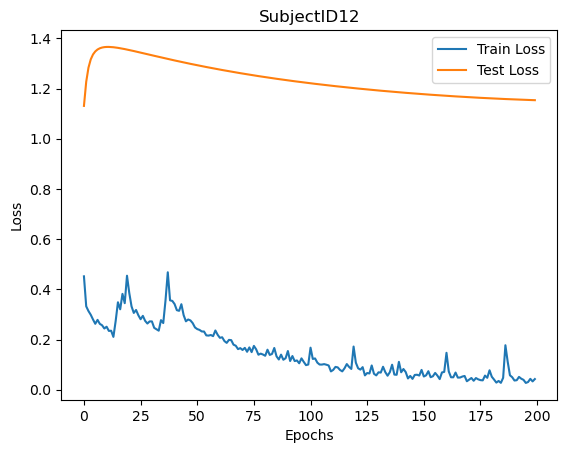

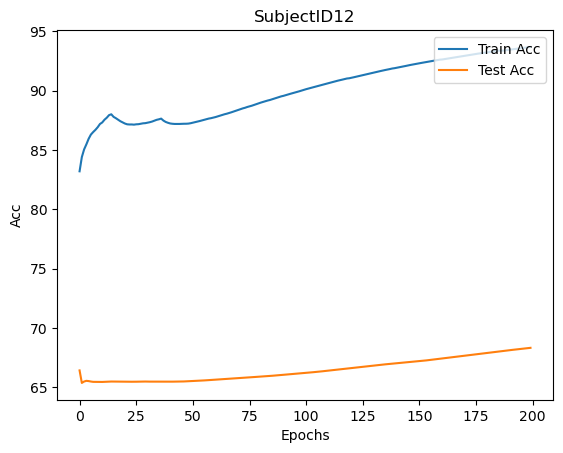


Subject 13
device: cuda
| epoch   0 | 0.2145 s/epoch | train loss 0.4871
| epoch   1 | 0.2114 s/epoch | train loss 0.3455
| epoch   2 | 0.2139 s/epoch | train loss 0.3307
| epoch   3 | 0.2128 s/epoch | train loss 0.3160
| epoch   4 | 0.2129 s/epoch | train loss 0.2954
| epoch   5 | 0.2123 s/epoch | train loss 0.2800
| epoch   6 | 0.2117 s/epoch | train loss 0.3180
| epoch   7 | 0.2115 s/epoch | train loss 0.3467
| epoch   8 | 0.2129 s/epoch | train loss 0.3092
| epoch   9 | 0.2135 s/epoch | train loss 0.2910
| epoch  10 | 0.2134 s/epoch | train loss 0.2726
| epoch  11 | 0.2126 s/epoch | train loss 0.2562
| epoch  12 | 0.2144 s/epoch | train loss 0.2550
| epoch  13 | 0.2136 s/epoch | train loss 0.2482
| epoch  14 | 0.2119 s/epoch | train loss 0.2370
| epoch  15 | 0.2131 s/epoch | train loss 0.2273
| epoch  16 | 0.2131 s/epoch | train loss 0.2120
| epoch  17 | 0.2128 s/epoch | train loss 0.3962
| epoch  18 | 0.2133 s/epoch | train loss 0.5519
| epoch  19 | 0.2136 s/epoch | train loss 0.

| epoch 167 | 0.2135 s/epoch | train loss 0.0559
| epoch 168 | 0.2129 s/epoch | train loss 0.0629
| epoch 169 | 0.2148 s/epoch | train loss 0.0637
| epoch 170 | 0.2134 s/epoch | train loss 0.0755
| epoch 171 | 0.2132 s/epoch | train loss 0.0687
| epoch 172 | 0.2121 s/epoch | train loss 0.0574
| epoch 173 | 0.2133 s/epoch | train loss 0.0494
| epoch 174 | 0.2144 s/epoch | train loss 0.0554
| epoch 175 | 0.2137 s/epoch | train loss 0.0551
| epoch 176 | 0.2143 s/epoch | train loss 0.0477
| epoch 177 | 0.2123 s/epoch | train loss 0.0498
| epoch 178 | 0.2139 s/epoch | train loss 0.0543
| epoch 179 | 0.2141 s/epoch | train loss 0.0643
| epoch 180 | 0.2127 s/epoch | train loss 0.0678
| epoch 181 | 0.2125 s/epoch | train loss 0.0670
| epoch 182 | 0.2127 s/epoch | train loss 0.0532
| epoch 183 | 0.2139 s/epoch | train loss 0.0492
| epoch 184 | 0.2147 s/epoch | train loss 0.0444
| epoch 185 | 0.2147 s/epoch | train loss 0.0471
| epoch 186 | 0.2164 s/epoch | train loss 0.0601
| epoch 187 | 0.2141

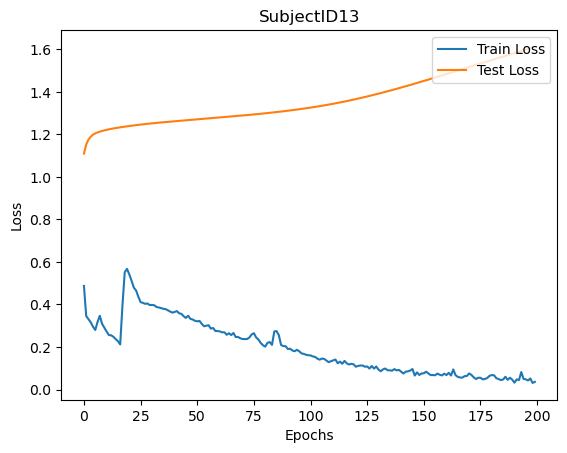

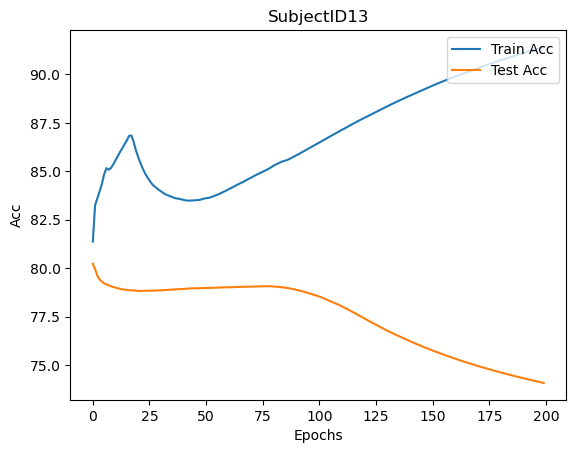

| epoch   0 | 0.2139 s/epoch | train loss 0.5400
| epoch   1 | 0.2131 s/epoch | train loss 0.4907
| epoch   2 | 0.2132 s/epoch | train loss 0.4076
| epoch   3 | 0.2116 s/epoch | train loss 0.3752
| epoch   4 | 0.2123 s/epoch | train loss 0.3758
| epoch   5 | 0.2135 s/epoch | train loss 0.3375
| epoch   6 | 0.2125 s/epoch | train loss 0.3245
| epoch   7 | 0.2115 s/epoch | train loss 0.3099
| epoch   8 | 0.2136 s/epoch | train loss 0.3336
| epoch   9 | 0.2139 s/epoch | train loss 0.3409
| epoch  10 | 0.2127 s/epoch | train loss 0.3217
| epoch  11 | 0.2115 s/epoch | train loss 0.3066
| epoch  12 | 0.2121 s/epoch | train loss 0.2945
| epoch  13 | 0.2144 s/epoch | train loss 0.2929
| epoch  14 | 0.2120 s/epoch | train loss 0.2788
| epoch  15 | 0.2133 s/epoch | train loss 0.2720
| epoch  16 | 0.2129 s/epoch | train loss 0.2641
| epoch  17 | 0.2137 s/epoch | train loss 0.2514
| epoch  18 | 0.2131 s/epoch | train loss 0.2522
| epoch  19 | 0.2121 s/epoch | train loss 0.2512
| epoch  20 | 0.2136

| epoch 168 | 0.2139 s/epoch | train loss 0.0929
| epoch 169 | 0.2126 s/epoch | train loss 0.0864
| epoch 170 | 0.2132 s/epoch | train loss 0.0764
| epoch 171 | 0.2143 s/epoch | train loss 0.0822
| epoch 172 | 0.2122 s/epoch | train loss 0.0875
| epoch 173 | 0.2130 s/epoch | train loss 0.0755
| epoch 174 | 0.2128 s/epoch | train loss 0.0858
| epoch 175 | 0.2139 s/epoch | train loss 0.0861
| epoch 176 | 0.2138 s/epoch | train loss 0.0867
| epoch 177 | 0.2139 s/epoch | train loss 0.0710
| epoch 178 | 0.2149 s/epoch | train loss 0.0672
| epoch 179 | 0.2145 s/epoch | train loss 0.0763
| epoch 180 | 0.2134 s/epoch | train loss 0.0735
| epoch 181 | 0.2133 s/epoch | train loss 0.0752
| epoch 182 | 0.2141 s/epoch | train loss 0.0649
| epoch 183 | 0.2142 s/epoch | train loss 0.0651
| epoch 184 | 0.2148 s/epoch | train loss 0.0699
| epoch 185 | 0.2124 s/epoch | train loss 0.0932
| epoch 186 | 0.2125 s/epoch | train loss 0.0722
| epoch 187 | 0.2129 s/epoch | train loss 0.0674
| epoch 188 | 0.2136

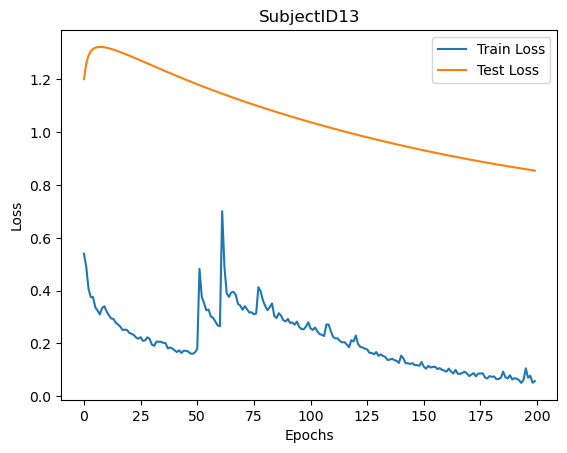

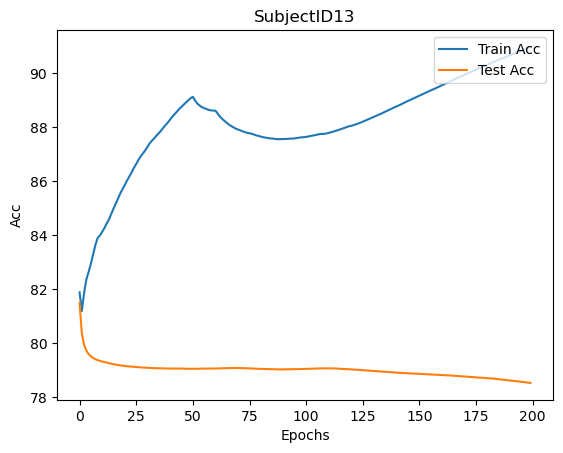


Subject 14
device: cuda
| epoch   0 | 0.2229 s/epoch | train loss 0.4951
| epoch   1 | 0.2212 s/epoch | train loss 0.4688
| epoch   2 | 0.2213 s/epoch | train loss 0.3655
| epoch   3 | 0.2220 s/epoch | train loss 0.4745
| epoch   4 | 0.2207 s/epoch | train loss 0.3636
| epoch   5 | 0.2211 s/epoch | train loss 0.4024
| epoch   6 | 0.2207 s/epoch | train loss 0.3948
| epoch   7 | 0.2216 s/epoch | train loss 0.3457
| epoch   8 | 0.2213 s/epoch | train loss 0.3752
| epoch   9 | 0.2223 s/epoch | train loss 0.3657
| epoch  10 | 0.2207 s/epoch | train loss 0.3721
| epoch  11 | 0.2206 s/epoch | train loss 0.4152
| epoch  12 | 0.2223 s/epoch | train loss 0.3962
| epoch  13 | 0.2221 s/epoch | train loss 0.3720
| epoch  14 | 0.2200 s/epoch | train loss 0.3529
| epoch  15 | 0.2217 s/epoch | train loss 0.3322
| epoch  16 | 0.2224 s/epoch | train loss 0.3229
| epoch  17 | 0.2213 s/epoch | train loss 0.2989
| epoch  18 | 0.2210 s/epoch | train loss 0.3113
| epoch  19 | 0.2223 s/epoch | train loss 0.

| epoch 167 | 0.2757 s/epoch | train loss 0.0827
| epoch 168 | 0.2757 s/epoch | train loss 0.1144
| epoch 169 | 0.2759 s/epoch | train loss 0.0799
| epoch 170 | 0.2752 s/epoch | train loss 0.0815
| epoch 171 | 0.2756 s/epoch | train loss 0.0712
| epoch 172 | 0.2768 s/epoch | train loss 0.0755
| epoch 173 | 0.2754 s/epoch | train loss 0.0787
| epoch 174 | 0.2780 s/epoch | train loss 0.0697
| epoch 175 | 0.2749 s/epoch | train loss 0.0618
| epoch 176 | 0.2772 s/epoch | train loss 0.0785
| epoch 177 | 0.2775 s/epoch | train loss 0.0784
| epoch 178 | 0.2772 s/epoch | train loss 0.0590
| epoch 179 | 0.2774 s/epoch | train loss 0.0667
| epoch 180 | 0.2762 s/epoch | train loss 0.1248
| epoch 181 | 0.2754 s/epoch | train loss 0.1453
| epoch 182 | 0.2780 s/epoch | train loss 0.1018
| epoch 183 | 0.2777 s/epoch | train loss 0.0968
| epoch 184 | 0.2762 s/epoch | train loss 0.1039
| epoch 185 | 0.2745 s/epoch | train loss 0.0901
| epoch 186 | 0.2764 s/epoch | train loss 0.0770
| epoch 187 | 0.2777

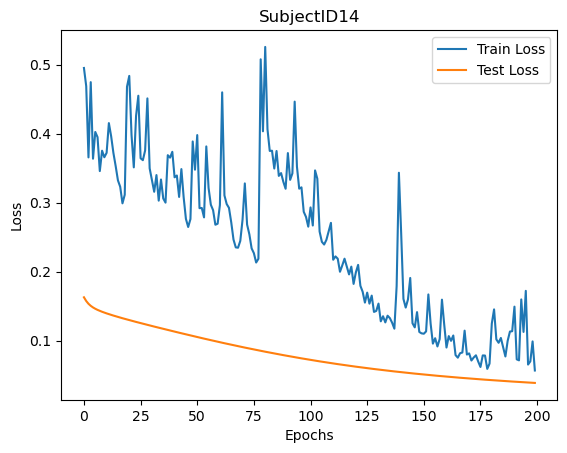

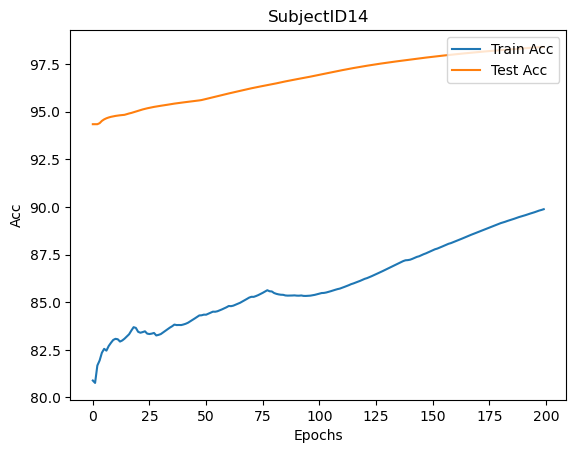

| epoch   0 | 0.2735 s/epoch | train loss 0.4523
| epoch   1 | 0.2744 s/epoch | train loss 0.3650
| epoch   2 | 0.2739 s/epoch | train loss 0.3475
| epoch   3 | 0.2751 s/epoch | train loss 0.4985
| epoch   4 | 0.2771 s/epoch | train loss 0.4482
| epoch   5 | 0.2767 s/epoch | train loss 0.4217
| epoch   6 | 0.2748 s/epoch | train loss 0.3494
| epoch   7 | 0.2762 s/epoch | train loss 0.3421
| epoch   8 | 0.2763 s/epoch | train loss 0.3766
| epoch   9 | 0.2758 s/epoch | train loss 0.3366
| epoch  10 | 0.2750 s/epoch | train loss 0.3302
| epoch  11 | 0.2773 s/epoch | train loss 0.3246
| epoch  12 | 0.2763 s/epoch | train loss 0.3132
| epoch  13 | 0.2755 s/epoch | train loss 0.2961
| epoch  14 | 0.2754 s/epoch | train loss 0.4169
| epoch  15 | 0.2764 s/epoch | train loss 0.3147
| epoch  16 | 0.2736 s/epoch | train loss 0.3472
| epoch  17 | 0.2765 s/epoch | train loss 0.3215
| epoch  18 | 0.2750 s/epoch | train loss 0.2961
| epoch  19 | 0.2771 s/epoch | train loss 0.4183
| epoch  20 | 0.2760

| epoch 168 | 0.2755 s/epoch | train loss 0.1794
| epoch 169 | 0.2756 s/epoch | train loss 0.1819
| epoch 170 | 0.2772 s/epoch | train loss 0.1664
| epoch 171 | 0.2759 s/epoch | train loss 0.1611
| epoch 172 | 0.2782 s/epoch | train loss 0.1731
| epoch 173 | 0.2754 s/epoch | train loss 0.2394
| epoch 174 | 0.2756 s/epoch | train loss 0.2105
| epoch 175 | 0.2759 s/epoch | train loss 0.1743
| epoch 176 | 0.2762 s/epoch | train loss 0.1853
| epoch 177 | 0.2763 s/epoch | train loss 0.3872
| epoch 178 | 0.2748 s/epoch | train loss 0.3141
| epoch 179 | 0.2759 s/epoch | train loss 0.2803
| epoch 180 | 0.2748 s/epoch | train loss 0.2588
| epoch 181 | 0.2754 s/epoch | train loss 0.2343
| epoch 182 | 0.2760 s/epoch | train loss 0.2603
| epoch 183 | 0.2751 s/epoch | train loss 0.5012
| epoch 184 | 0.2754 s/epoch | train loss 0.3907
| epoch 185 | 0.2771 s/epoch | train loss 0.5192
| epoch 186 | 0.2738 s/epoch | train loss 0.4272
| epoch 187 | 0.2729 s/epoch | train loss 0.3990
| epoch 188 | 0.2742

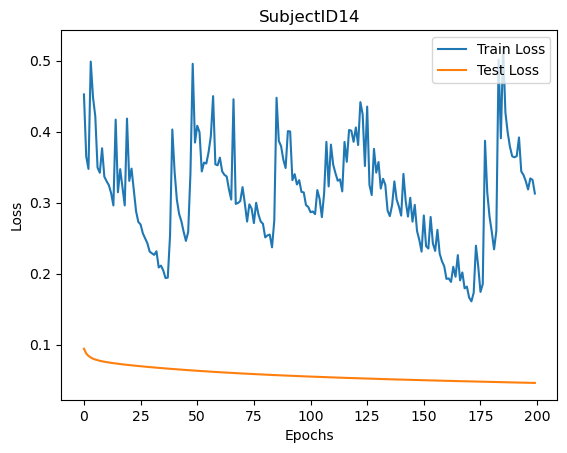

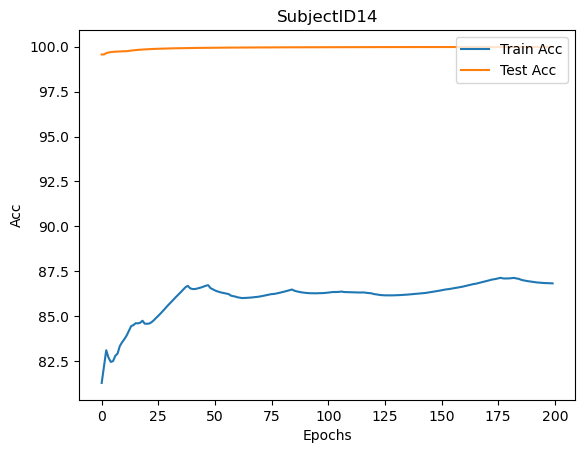


Subject 15
device: cuda
| epoch   0 | 0.2882 s/epoch | train loss 0.4649
| epoch   1 | 0.2862 s/epoch | train loss 0.4269
| epoch   2 | 0.2873 s/epoch | train loss 0.3569
| epoch   3 | 0.2878 s/epoch | train loss 0.3185
| epoch   4 | 0.2871 s/epoch | train loss 0.3172
| epoch   5 | 0.2867 s/epoch | train loss 0.3111
| epoch   6 | 0.2884 s/epoch | train loss 0.2888
| epoch   7 | 0.2886 s/epoch | train loss 0.2742
| epoch   8 | 0.2871 s/epoch | train loss 0.2596
| epoch   9 | 0.2857 s/epoch | train loss 0.2506
| epoch  10 | 0.2883 s/epoch | train loss 0.2491
| epoch  11 | 0.2870 s/epoch | train loss 0.2425
| epoch  12 | 0.2858 s/epoch | train loss 0.2336
| epoch  13 | 0.2868 s/epoch | train loss 0.2330
| epoch  14 | 0.2883 s/epoch | train loss 0.2254
| epoch  15 | 0.2869 s/epoch | train loss 0.2213
| epoch  16 | 0.2858 s/epoch | train loss 0.2125
| epoch  17 | 0.2875 s/epoch | train loss 0.2145
| epoch  18 | 0.2856 s/epoch | train loss 0.2023
| epoch  19 | 0.2875 s/epoch | train loss 0.

| epoch 167 | 0.2893 s/epoch | train loss 0.0308
| epoch 168 | 0.2886 s/epoch | train loss 0.0299
| epoch 169 | 0.2874 s/epoch | train loss 0.0286
| epoch 170 | 0.2879 s/epoch | train loss 0.0268
| epoch 171 | 0.2877 s/epoch | train loss 0.0372
| epoch 172 | 0.2898 s/epoch | train loss 0.0346
| epoch 173 | 0.2872 s/epoch | train loss 0.0365
| epoch 174 | 0.2865 s/epoch | train loss 0.0283
| epoch 175 | 0.2886 s/epoch | train loss 0.0365
| epoch 176 | 0.2859 s/epoch | train loss 0.0286
| epoch 177 | 0.2879 s/epoch | train loss 0.0334
| epoch 178 | 0.2875 s/epoch | train loss 0.0377
| epoch 179 | 0.2875 s/epoch | train loss 0.0262
| epoch 180 | 0.2879 s/epoch | train loss 0.0309
| epoch 181 | 0.2897 s/epoch | train loss 0.0370
| epoch 182 | 0.2896 s/epoch | train loss 0.0213
| epoch 183 | 0.2894 s/epoch | train loss 0.0223
| epoch 184 | 0.2879 s/epoch | train loss 0.0469
| epoch 185 | 0.2885 s/epoch | train loss 0.0273
| epoch 186 | 0.2884 s/epoch | train loss 0.0244
| epoch 187 | 0.2885

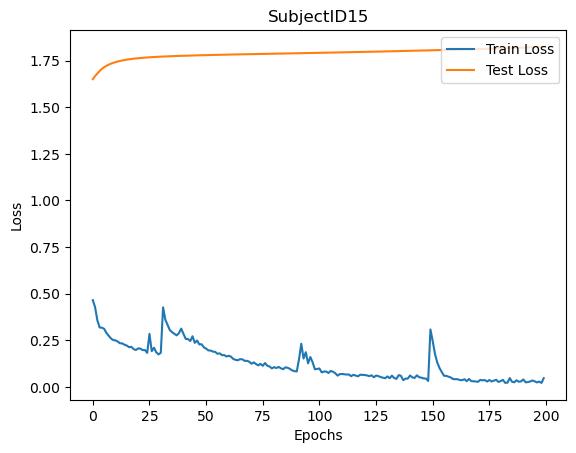

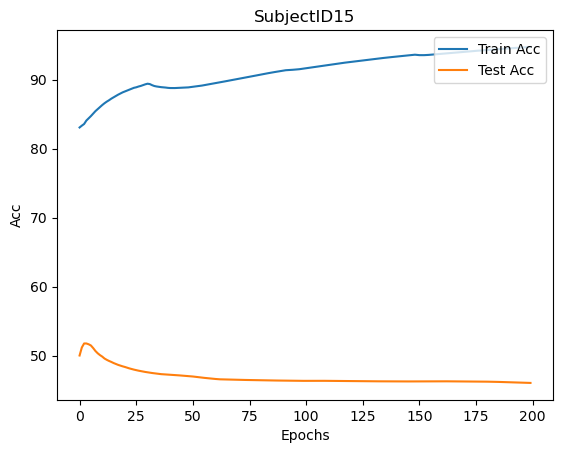

| epoch   0 | 0.2867 s/epoch | train loss 0.4751
| epoch   1 | 0.2850 s/epoch | train loss 0.5070
| epoch   2 | 0.2876 s/epoch | train loss 0.4076
| epoch   3 | 0.2887 s/epoch | train loss 0.3471
| epoch   4 | 0.2861 s/epoch | train loss 0.3773
| epoch   5 | 0.2856 s/epoch | train loss 0.3254
| epoch   6 | 0.2870 s/epoch | train loss 0.3167
| epoch   7 | 0.2883 s/epoch | train loss 0.2864
| epoch   8 | 0.2874 s/epoch | train loss 0.2878
| epoch   9 | 0.2885 s/epoch | train loss 0.2693
| epoch  10 | 0.2865 s/epoch | train loss 0.2686
| epoch  11 | 0.2888 s/epoch | train loss 0.2456
| epoch  12 | 0.2867 s/epoch | train loss 0.2418
| epoch  13 | 0.2869 s/epoch | train loss 0.3916
| epoch  14 | 0.2865 s/epoch | train loss 0.3072
| epoch  15 | 0.2866 s/epoch | train loss 0.2832
| epoch  16 | 0.2865 s/epoch | train loss 0.2585
| epoch  17 | 0.2866 s/epoch | train loss 0.2613
| epoch  18 | 0.2874 s/epoch | train loss 0.2662
| epoch  19 | 0.2868 s/epoch | train loss 0.2357
| epoch  20 | 0.2887

| epoch 168 | 0.2311 s/epoch | train loss 0.0426
| epoch 169 | 0.2310 s/epoch | train loss 0.0367
| epoch 170 | 0.2306 s/epoch | train loss 0.0438
| epoch 171 | 0.2318 s/epoch | train loss 0.0304
| epoch 172 | 0.2300 s/epoch | train loss 0.0410
| epoch 173 | 0.2302 s/epoch | train loss 0.0376
| epoch 174 | 0.2313 s/epoch | train loss 0.0370
| epoch 175 | 0.2313 s/epoch | train loss 0.0300
| epoch 176 | 0.2301 s/epoch | train loss 0.0286
| epoch 177 | 0.2301 s/epoch | train loss 0.0377
| epoch 178 | 0.2311 s/epoch | train loss 0.0345
| epoch 179 | 0.2329 s/epoch | train loss 0.0337
| epoch 180 | 0.2314 s/epoch | train loss 0.0284
| epoch 181 | 0.2324 s/epoch | train loss 0.0308
| epoch 182 | 0.2306 s/epoch | train loss 0.0289
| epoch 183 | 0.2305 s/epoch | train loss 0.0389
| epoch 184 | 0.2296 s/epoch | train loss 0.0568
| epoch 185 | 0.2301 s/epoch | train loss 0.0366
| epoch 186 | 0.2317 s/epoch | train loss 0.0325
| epoch 187 | 0.2307 s/epoch | train loss 0.0385
| epoch 188 | 0.2315

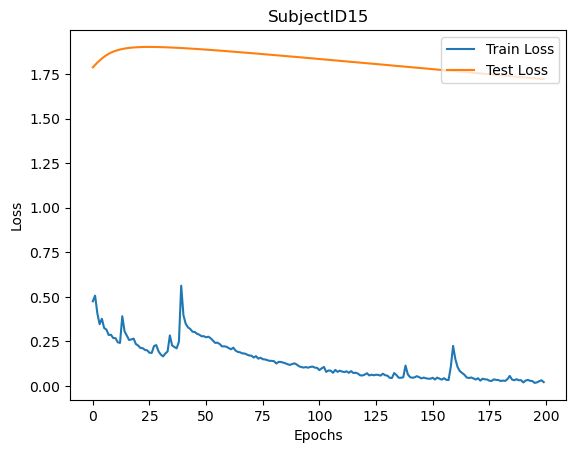

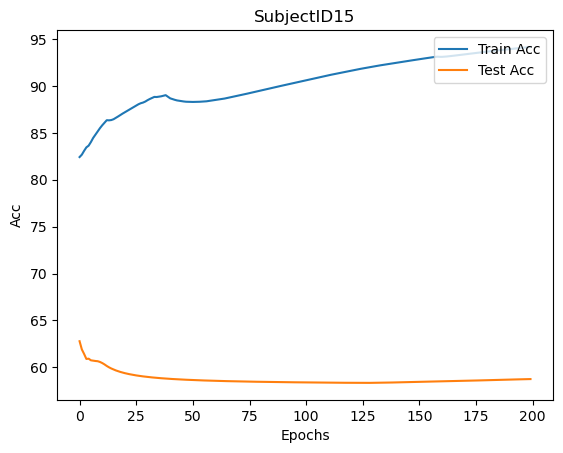

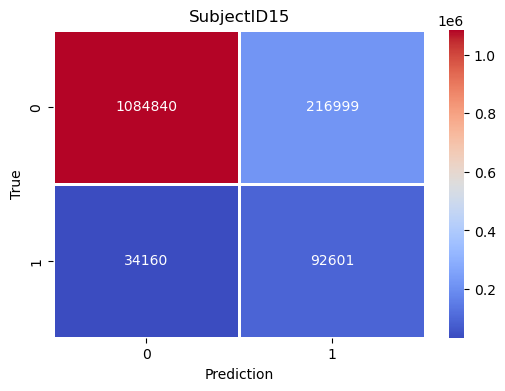

<Figure size 640x480 with 0 Axes>

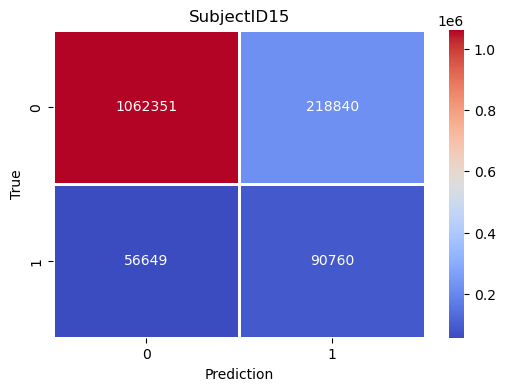

Teacher(RestNet18)_Acc: 0.8241922161556768
Teacher(RestNet18)_Rec: 0.7305164837765559
Teacher(RestNet18)_Pre: 0.2990988372093023
Teacher(RestNet18)_F1: 0.424423814227211
Original_Student(CNN_Small)_Acc: 0.8071615567688646
Original_Student(CNN_Small)_Rec: 0.6157018906579652
Original_Student(CNN_Small)_Pre: 0.2931524547803618
Original_Student(CNN_Small)_F1: 0.3971913025782862


<Figure size 640x480 with 0 Axes>

In [17]:
#%% Evaluation
def evaluation(pred,target):
    acu = accuracy_score(pred, target)
    rec = recall_score(pred, target)
    pre = precision_score(pred, target)
    f1 = f1_score(pred, target)  
    return np.array([acu, rec, pre, f1])

#%% Train
Accuracy_teacher = []
Recall_teacher = []
Precision_teacher = []
F1score_teacher = []

Accuracy_student = []
Recall_student = []
Precision_student = []
F1score_student = []


Accuracy_teacher_student = []
Recall_teacher_student = []
Precision_teacher_student = []
F1score_teacher_student = []


teacher_train_preds = []
teacher_train_gt = []


student_train_preds = []
student_train_gt = []



#for i in range(Average_times):
lis = [1,2,3,4,5,7,8,9,10,11,12,13,14,15]
for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)

            

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    ResNet = Net_Teacher(block, [3, 4, 23, 3], 1, 2)
    model_teacher = ResNet.to(device) 
    model_teacher.train()

    ResNet_S = Net_Student(block, [3, 4, 23, 3], 1, 2)
    model_student = ResNet_S.to(device)
    model_student.train()
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher = torch.optim.Adam(model_teacher.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    optimizer_student = torch.optim.Adam(model_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Start training and testing Teacher and Student Model
    training_teacher(trainloader,optimizer_teacher,criterion,model_teacher,testloader)
    #testing_teacher(testloader,optimizer_teacher,criterion,model_teacher)
  
    training_student(trainloader,optimizer_student,criterion,model_student,testloader)    
    #testing_student(testloader,optimizer_student,criterion,model_student)

#print(teacher_train_preds)
#print(teacher_train_gt)
Teacher_eval_table = evaluation(teacher_train_preds, teacher_train_gt)

Student_eval_table = evaluation(student_train_preds, student_train_gt)

show_CM_teacher(teacher_train_preds, teacher_train_gt)
show_CM_student(student_train_preds, student_train_gt)

print("Teacher(RestNet18)_Acc:",Teacher_eval_table[0])
print("Teacher(RestNet18)_Rec:",Teacher_eval_table[1])
print("Teacher(RestNet18)_Pre:",Teacher_eval_table[2])
print("Teacher(RestNet18)_F1:",Teacher_eval_table[3])

print("Original_Student(CNN_Small)_Acc:",Student_eval_table[0])
print("Original_Student(CNN_Small)_Rec:",Student_eval_table[1])
print("Original_Student(CNN_Small)_Pre:",Student_eval_table[2])
print("Original_Student(CNN_Small)_F1:",Student_eval_table[3]) 






Subject 1
| epoch   0 | 0.2209 s/epoch | train loss 1.4078
| epoch   1 | 0.2204 s/epoch | train loss 1.0225
| epoch   2 | 0.2237 s/epoch | train loss 0.9059
| epoch   3 | 0.2211 s/epoch | train loss 0.8666
| epoch   4 | 0.2227 s/epoch | train loss 0.8214
| epoch   5 | 0.2197 s/epoch | train loss 0.7707
| epoch   6 | 0.2202 s/epoch | train loss 0.7809
| epoch   7 | 0.2210 s/epoch | train loss 0.7537
| epoch   8 | 0.2233 s/epoch | train loss 0.7383
| epoch   9 | 0.2210 s/epoch | train loss 0.7148
| epoch  10 | 0.2209 s/epoch | train loss 0.6775
| epoch  11 | 0.2220 s/epoch | train loss 0.6938
| epoch  12 | 0.2210 s/epoch | train loss 0.6661
| epoch  13 | 0.2219 s/epoch | train loss 0.6833
| epoch  14 | 0.2191 s/epoch | train loss 0.6294
| epoch  15 | 0.2209 s/epoch | train loss 0.6281
| epoch  16 | 0.2215 s/epoch | train loss 0.6269
| epoch  17 | 0.2225 s/epoch | train loss 0.5842
| epoch  18 | 0.2207 s/epoch | train loss 0.5989
| epoch  19 | 0.2210 s/epoch | train loss 0.5956
| epoch  

| epoch 167 | 0.2176 s/epoch | train loss 0.3237
| epoch 168 | 0.2165 s/epoch | train loss 0.3255
| epoch 169 | 0.2165 s/epoch | train loss 0.3034
| epoch 170 | 0.2179 s/epoch | train loss 0.3099
| epoch 171 | 0.2195 s/epoch | train loss 0.3032
| epoch 172 | 0.2174 s/epoch | train loss 0.2961
| epoch 173 | 0.2161 s/epoch | train loss 0.3103
| epoch 174 | 0.2187 s/epoch | train loss 0.3230
| epoch 175 | 0.2176 s/epoch | train loss 0.7019
| epoch 176 | 0.2186 s/epoch | train loss 0.6372
| epoch 177 | 0.2176 s/epoch | train loss 0.5538
| epoch 178 | 0.2166 s/epoch | train loss 0.5210
| epoch 179 | 0.2162 s/epoch | train loss 0.4793
| epoch 180 | 0.2169 s/epoch | train loss 0.4371
| epoch 181 | 0.2164 s/epoch | train loss 0.4372
| epoch 182 | 0.2192 s/epoch | train loss 0.4115
| epoch 183 | 0.2162 s/epoch | train loss 0.3897
| epoch 184 | 0.2144 s/epoch | train loss 0.3913
| epoch 185 | 0.2181 s/epoch | train loss 0.3738
| epoch 186 | 0.2175 s/epoch | train loss 0.3518
| epoch 187 | 0.2167

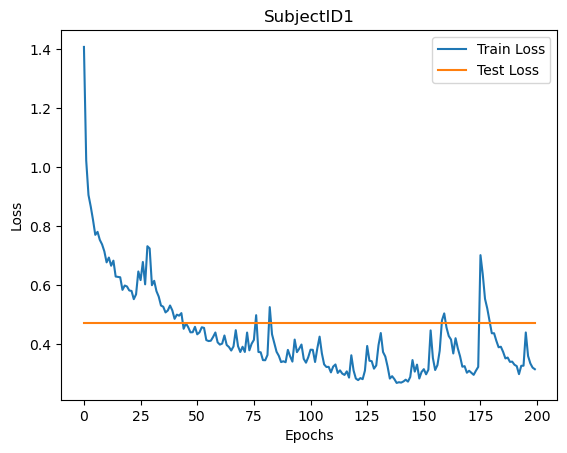

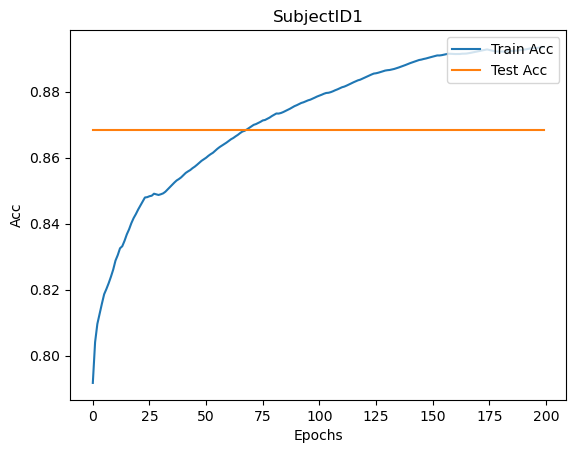

~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~

Subject 2
| epoch   0 | 0.2103 s/epoch | train loss 1.4440
| epoch   1 | 0.2100 s/epoch | train loss 1.1128
| epoch   2 | 0.2123 s/epoch | train loss 0.9772
| epoch   3 | 0.2115 s/epoch | train loss 0.9231
| epoch   4 | 0.2108 s/epoch | train loss 0.9024
| epoch   5 | 0.2118 s/epoch | train loss 0.9818
| epoch   6 | 0.2118 s/epoch | train loss 0.9117
| epoch   7 | 0.2094 s/epoch | train loss 0.8549
| epoch   8 | 0.2104 s/epoch | train loss 0.9115
| epoch   9 | 0.2110 s/epoch | train loss 0.8269
| epoch  10 | 0.2098 s/epoch | train loss 0.8083
| epoch  11 | 0.2129 s/epoch | train loss 1.0018
| epoch  12 | 0.2132 s/epoch | train loss 0.8961
| epoch  13 | 0.2132 s/epoch | train loss 0.8386
| epoch  14 | 0.2079 s/epoch | train loss 0.8641
| 

| epoch 162 | 0.1626 s/epoch | train loss 0.3923
| epoch 163 | 0.1623 s/epoch | train loss 0.3353
| epoch 164 | 0.1618 s/epoch | train loss 0.3341
| epoch 165 | 0.1636 s/epoch | train loss 0.3312
| epoch 166 | 0.1635 s/epoch | train loss 0.3371
| epoch 167 | 0.1630 s/epoch | train loss 0.3356
| epoch 168 | 0.1626 s/epoch | train loss 0.3255
| epoch 169 | 0.1622 s/epoch | train loss 0.3172
| epoch 170 | 0.1629 s/epoch | train loss 0.3285
| epoch 171 | 0.1637 s/epoch | train loss 0.3195
| epoch 172 | 0.1633 s/epoch | train loss 0.3042
| epoch 173 | 0.1633 s/epoch | train loss 0.2923
| epoch 174 | 0.1625 s/epoch | train loss 0.3019
| epoch 175 | 0.1627 s/epoch | train loss 0.2954
| epoch 176 | 0.1631 s/epoch | train loss 0.3692
| epoch 177 | 0.1616 s/epoch | train loss 0.6243
| epoch 178 | 0.1615 s/epoch | train loss 0.4553
| epoch 179 | 0.1635 s/epoch | train loss 0.4150
| epoch 180 | 0.1633 s/epoch | train loss 0.3848
| epoch 181 | 0.1626 s/epoch | train loss 0.3591
| epoch 182 | 0.1636

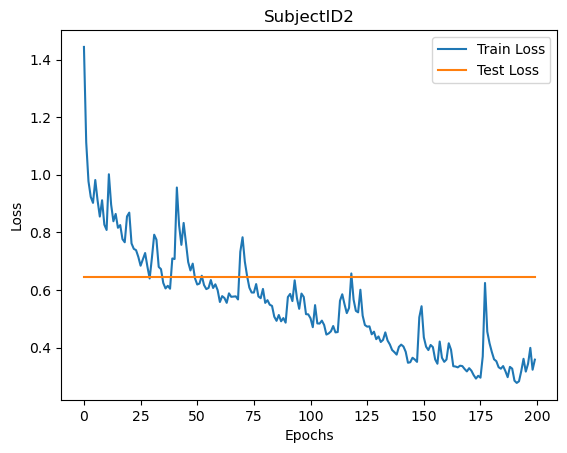

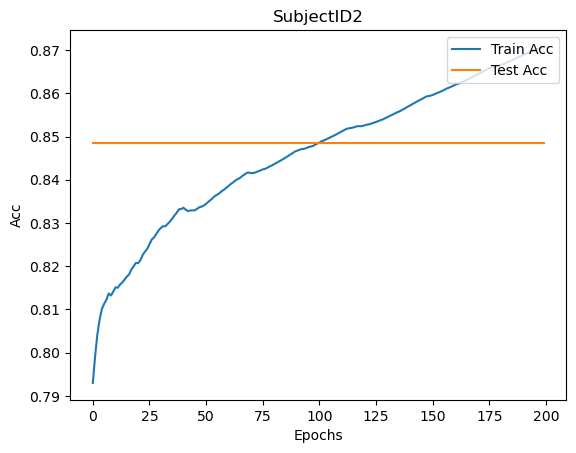


Subject 3
| epoch   0 | 0.1633 s/epoch | train loss 1.3791
| epoch   1 | 0.1634 s/epoch | train loss 0.9971
| epoch   2 | 0.1628 s/epoch | train loss 0.9037
| epoch   3 | 0.1629 s/epoch | train loss 0.8396
| epoch   4 | 0.1641 s/epoch | train loss 0.7843
| epoch   5 | 0.1628 s/epoch | train loss 0.7633
| epoch   6 | 0.1633 s/epoch | train loss 0.7214
| epoch   7 | 0.1623 s/epoch | train loss 0.7293
| epoch   8 | 0.1626 s/epoch | train loss 0.6661
| epoch   9 | 0.1629 s/epoch | train loss 0.6468
| epoch  10 | 0.1617 s/epoch | train loss 0.6319
| epoch  11 | 0.1633 s/epoch | train loss 0.6196
| epoch  12 | 0.1628 s/epoch | train loss 0.6019
| epoch  13 | 0.1630 s/epoch | train loss 0.6169
| epoch  14 | 0.1634 s/epoch | train loss 0.6132
| epoch  15 | 0.1625 s/epoch | train loss 0.6236
| epoch  16 | 0.1639 s/epoch | train loss 0.5973
| epoch  17 | 0.1618 s/epoch | train loss 0.5964
| epoch  18 | 0.1629 s/epoch | train loss 0.5850
| epoch  19 | 0.1621 s/epoch | train loss 0.5540
| epoch  

| epoch 167 | 0.1615 s/epoch | train loss 0.6841
| epoch 168 | 0.1621 s/epoch | train loss 0.5589
| epoch 169 | 0.1633 s/epoch | train loss 0.4759
| epoch 170 | 0.1617 s/epoch | train loss 0.4151
| epoch 171 | 0.1621 s/epoch | train loss 0.4242
| epoch 172 | 0.1632 s/epoch | train loss 0.3577
| epoch 173 | 0.1634 s/epoch | train loss 0.3299
| epoch 174 | 0.1618 s/epoch | train loss 0.3236
| epoch 175 | 0.1632 s/epoch | train loss 0.3561
| epoch 176 | 0.1644 s/epoch | train loss 0.3355
| epoch 177 | 0.1630 s/epoch | train loss 0.3043
| epoch 178 | 0.1632 s/epoch | train loss 0.2814
| epoch 179 | 0.1634 s/epoch | train loss 0.2924
| epoch 180 | 0.1634 s/epoch | train loss 0.2757
| epoch 181 | 0.1639 s/epoch | train loss 0.2452
| epoch 182 | 0.1628 s/epoch | train loss 0.2482
| epoch 183 | 0.1630 s/epoch | train loss 0.2461
| epoch 184 | 0.1639 s/epoch | train loss 0.3236
| epoch 185 | 0.1622 s/epoch | train loss 0.2674
| epoch 186 | 0.1637 s/epoch | train loss 0.2625
| epoch 187 | 0.1623

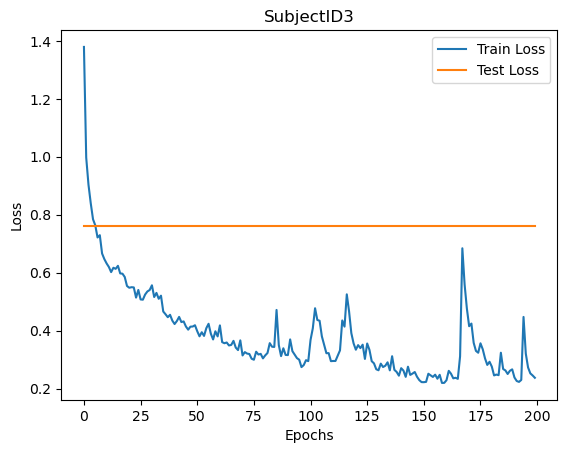

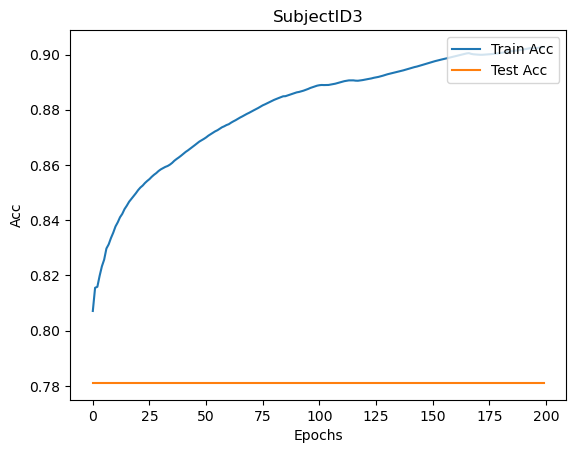


Subject 4
| epoch   0 | 0.1640 s/epoch | train loss 1.4742
| epoch   1 | 0.1644 s/epoch | train loss 1.0233
| epoch   2 | 0.1640 s/epoch | train loss 0.9201
| epoch   3 | 0.1651 s/epoch | train loss 0.8959
| epoch   4 | 0.1629 s/epoch | train loss 0.8328
| epoch   5 | 0.1653 s/epoch | train loss 0.7956
| epoch   6 | 0.1632 s/epoch | train loss 0.7647
| epoch   7 | 0.1635 s/epoch | train loss 0.7154
| epoch   8 | 0.1626 s/epoch | train loss 0.7049
| epoch   9 | 0.1652 s/epoch | train loss 0.6529
| epoch  10 | 0.1625 s/epoch | train loss 0.6410
| epoch  11 | 0.1633 s/epoch | train loss 0.6351
| epoch  12 | 0.1646 s/epoch | train loss 0.6313
| epoch  13 | 0.1635 s/epoch | train loss 0.6026
| epoch  14 | 0.1626 s/epoch | train loss 0.5998
| epoch  15 | 0.1635 s/epoch | train loss 0.6189
| epoch  16 | 0.1645 s/epoch | train loss 0.5936
| epoch  17 | 0.1618 s/epoch | train loss 0.5780
| epoch  18 | 0.1622 s/epoch | train loss 0.5898
| epoch  19 | 0.1633 s/epoch | train loss 0.5576
| epoch  

| epoch 167 | 0.1710 s/epoch | train loss 0.2626
| epoch 168 | 0.1718 s/epoch | train loss 0.2968
| epoch 169 | 0.1717 s/epoch | train loss 0.2558
| epoch 170 | 0.1709 s/epoch | train loss 0.2299
| epoch 171 | 0.1714 s/epoch | train loss 0.2218
| epoch 172 | 0.1702 s/epoch | train loss 0.2284
| epoch 173 | 0.1712 s/epoch | train loss 0.2389
| epoch 174 | 0.1716 s/epoch | train loss 0.3088
| epoch 175 | 0.1713 s/epoch | train loss 0.2595
| epoch 176 | 0.1705 s/epoch | train loss 0.2406
| epoch 177 | 0.1718 s/epoch | train loss 0.2358
| epoch 178 | 0.1713 s/epoch | train loss 0.2505
| epoch 179 | 0.1716 s/epoch | train loss 0.2676
| epoch 180 | 0.1705 s/epoch | train loss 0.2480
| epoch 181 | 0.1698 s/epoch | train loss 0.2299
| epoch 182 | 0.1707 s/epoch | train loss 0.2080
| epoch 183 | 0.1702 s/epoch | train loss 0.2035
| epoch 184 | 0.1718 s/epoch | train loss 0.2008
| epoch 185 | 0.1714 s/epoch | train loss 0.2356
| epoch 186 | 0.1710 s/epoch | train loss 0.2813
| epoch 187 | 0.1706

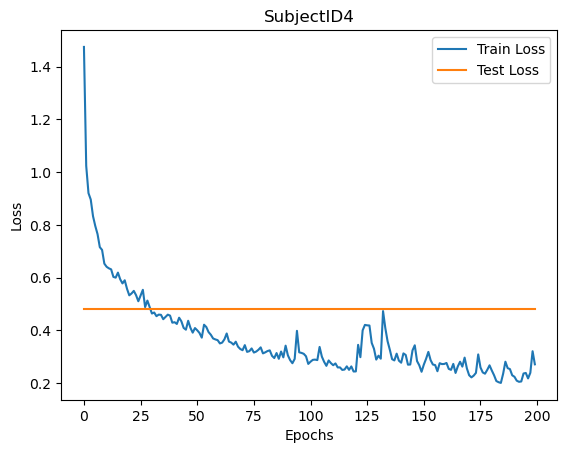

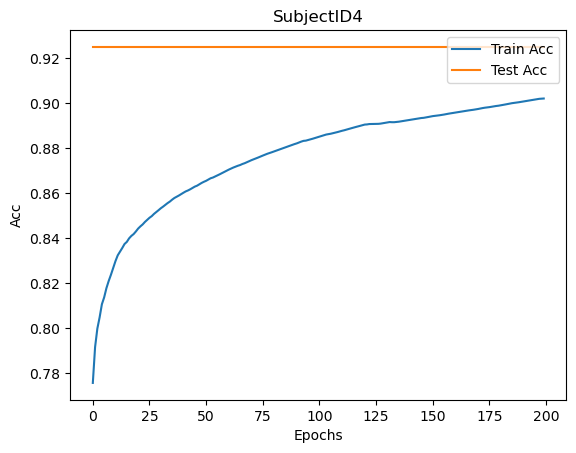


Subject 5
| epoch   0 | 0.1105 s/epoch | train loss 1.4810
| epoch   1 | 0.1095 s/epoch | train loss 1.0467
| epoch   2 | 0.1115 s/epoch | train loss 0.9249
| epoch   3 | 0.1095 s/epoch | train loss 0.8653
| epoch   4 | 0.1104 s/epoch | train loss 0.8083
| epoch   5 | 0.1103 s/epoch | train loss 0.7583
| epoch   6 | 0.1105 s/epoch | train loss 0.7254
| epoch   7 | 0.1103 s/epoch | train loss 0.6999
| epoch   8 | 0.1106 s/epoch | train loss 0.6782
| epoch   9 | 0.1080 s/epoch | train loss 0.6825
| epoch  10 | 0.1117 s/epoch | train loss 0.6399
| epoch  11 | 0.1104 s/epoch | train loss 0.6457
| epoch  12 | 0.1102 s/epoch | train loss 0.6341
| epoch  13 | 0.1094 s/epoch | train loss 0.6180
| epoch  14 | 0.1099 s/epoch | train loss 0.6012
| epoch  15 | 0.1092 s/epoch | train loss 0.6021
| epoch  16 | 0.1099 s/epoch | train loss 0.5868
| epoch  17 | 0.1097 s/epoch | train loss 0.5655
| epoch  18 | 0.1093 s/epoch | train loss 0.5728
| epoch  19 | 0.1100 s/epoch | train loss 0.5758
| epoch  

| epoch 167 | 0.1092 s/epoch | train loss 0.2160
| epoch 168 | 0.1112 s/epoch | train loss 0.2509
| epoch 169 | 0.1105 s/epoch | train loss 0.2159
| epoch 170 | 0.1097 s/epoch | train loss 0.2130
| epoch 171 | 0.1107 s/epoch | train loss 0.2108
| epoch 172 | 0.1109 s/epoch | train loss 0.2086
| epoch 173 | 0.1090 s/epoch | train loss 0.1971
| epoch 174 | 0.1118 s/epoch | train loss 0.2272
| epoch 175 | 0.1113 s/epoch | train loss 0.2159
| epoch 176 | 0.1100 s/epoch | train loss 0.2246
| epoch 177 | 0.1103 s/epoch | train loss 0.2343
| epoch 178 | 0.1101 s/epoch | train loss 0.2115
| epoch 179 | 0.1101 s/epoch | train loss 0.2238
| epoch 180 | 0.1098 s/epoch | train loss 0.2888
| epoch 181 | 0.1093 s/epoch | train loss 0.2241
| epoch 182 | 0.1094 s/epoch | train loss 0.2460
| epoch 183 | 0.1110 s/epoch | train loss 0.2517
| epoch 184 | 0.1106 s/epoch | train loss 0.2290
| epoch 185 | 0.1092 s/epoch | train loss 0.2048
| epoch 186 | 0.1097 s/epoch | train loss 0.1980
| epoch 187 | 0.1102

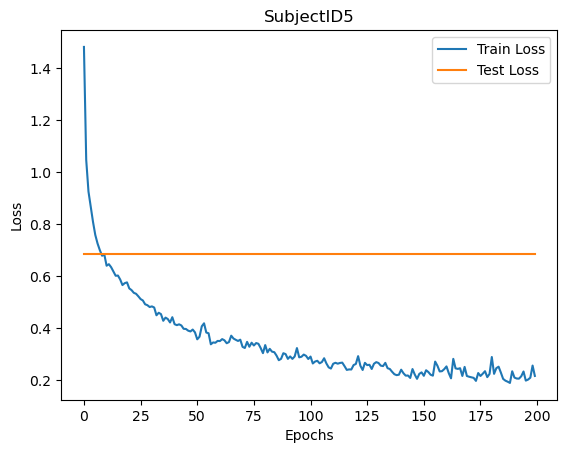

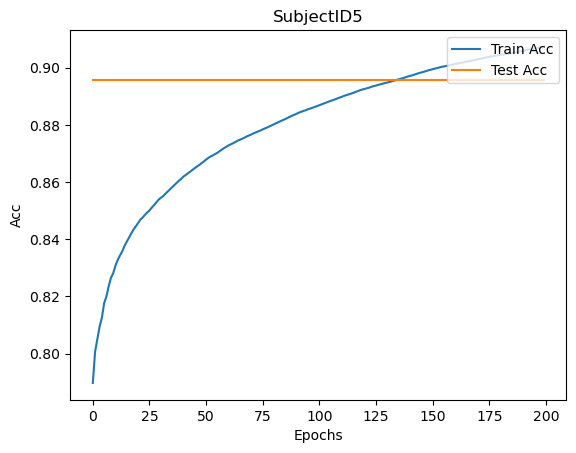


Subject 7
| epoch   0 | 0.1092 s/epoch | train loss 1.4290
| epoch   1 | 0.1083 s/epoch | train loss 1.0015
| epoch   2 | 0.1074 s/epoch | train loss 0.8825
| epoch   3 | 0.1082 s/epoch | train loss 0.8377
| epoch   4 | 0.1079 s/epoch | train loss 0.7627
| epoch   5 | 0.1081 s/epoch | train loss 0.7229
| epoch   6 | 0.1074 s/epoch | train loss 0.6825
| epoch   7 | 0.1085 s/epoch | train loss 0.6507
| epoch   8 | 0.1079 s/epoch | train loss 0.6262
| epoch   9 | 0.1082 s/epoch | train loss 0.6126
| epoch  10 | 0.1080 s/epoch | train loss 0.6066
| epoch  11 | 0.1080 s/epoch | train loss 0.5998
| epoch  12 | 0.1090 s/epoch | train loss 0.5800
| epoch  13 | 0.1078 s/epoch | train loss 0.5796
| epoch  14 | 0.1088 s/epoch | train loss 0.5523
| epoch  15 | 0.1086 s/epoch | train loss 0.5648
| epoch  16 | 0.1068 s/epoch | train loss 0.5582
| epoch  17 | 0.1090 s/epoch | train loss 0.5150
| epoch  18 | 0.1098 s/epoch | train loss 0.5204
| epoch  19 | 0.1089 s/epoch | train loss 0.5129
| epoch  

| epoch 167 | 0.0906 s/epoch | train loss 0.2161
| epoch 168 | 0.0898 s/epoch | train loss 0.2188
| epoch 169 | 0.0911 s/epoch | train loss 0.1917
| epoch 170 | 0.0903 s/epoch | train loss 0.1839
| epoch 171 | 0.0901 s/epoch | train loss 0.2296
| epoch 172 | 0.0904 s/epoch | train loss 0.2238
| epoch 173 | 0.0902 s/epoch | train loss 0.2113
| epoch 174 | 0.0905 s/epoch | train loss 0.2254
| epoch 175 | 0.0905 s/epoch | train loss 0.1985
| epoch 176 | 0.0898 s/epoch | train loss 0.1936
| epoch 177 | 0.0902 s/epoch | train loss 0.2064
| epoch 178 | 0.0908 s/epoch | train loss 0.2731
| epoch 179 | 0.0900 s/epoch | train loss 0.2440
| epoch 180 | 0.0903 s/epoch | train loss 0.2125
| epoch 181 | 0.0898 s/epoch | train loss 0.1956
| epoch 182 | 0.0904 s/epoch | train loss 0.1991
| epoch 183 | 0.0904 s/epoch | train loss 0.1984
| epoch 184 | 0.0898 s/epoch | train loss 0.2043
| epoch 185 | 0.0906 s/epoch | train loss 0.1930
| epoch 186 | 0.0903 s/epoch | train loss 0.1964
| epoch 187 | 0.0895

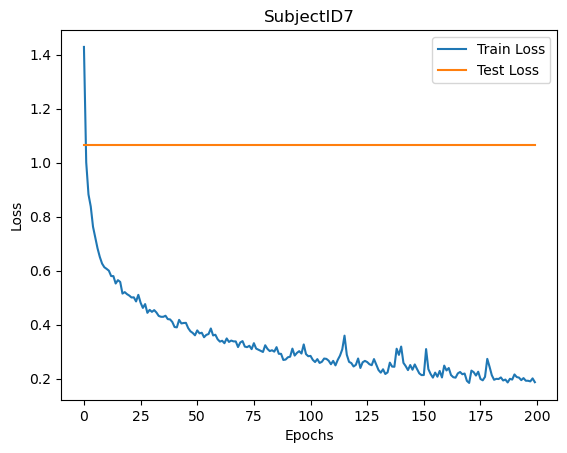

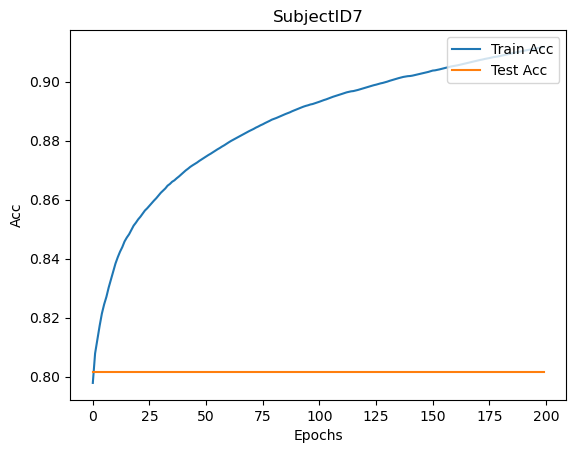


Subject 8
| epoch   0 | 0.1135 s/epoch | train loss 1.4375
| epoch   1 | 0.1143 s/epoch | train loss 1.0185
| epoch   2 | 0.1122 s/epoch | train loss 0.9177
| epoch   3 | 0.1135 s/epoch | train loss 0.8186
| epoch   4 | 0.1130 s/epoch | train loss 0.7706
| epoch   5 | 0.1135 s/epoch | train loss 0.7431
| epoch   6 | 0.1134 s/epoch | train loss 0.7318
| epoch   7 | 0.1124 s/epoch | train loss 0.7115
| epoch   8 | 0.1122 s/epoch | train loss 0.6908
| epoch   9 | 0.1142 s/epoch | train loss 0.6777
| epoch  10 | 0.1132 s/epoch | train loss 0.6423
| epoch  11 | 0.1124 s/epoch | train loss 0.6332
| epoch  12 | 0.1131 s/epoch | train loss 0.6403
| epoch  13 | 0.1133 s/epoch | train loss 0.6494
| epoch  14 | 0.1127 s/epoch | train loss 0.6021
| epoch  15 | 0.1127 s/epoch | train loss 0.5903
| epoch  16 | 0.1133 s/epoch | train loss 0.5942
| epoch  17 | 0.1123 s/epoch | train loss 0.5790
| epoch  18 | 0.1133 s/epoch | train loss 0.5332
| epoch  19 | 0.1130 s/epoch | train loss 0.5591
| epoch  

| epoch 167 | 0.1133 s/epoch | train loss 0.2454
| epoch 168 | 0.1132 s/epoch | train loss 0.2241
| epoch 169 | 0.1133 s/epoch | train loss 0.2297
| epoch 170 | 0.1133 s/epoch | train loss 0.2034
| epoch 171 | 0.1132 s/epoch | train loss 0.2186
| epoch 172 | 0.1133 s/epoch | train loss 0.1919
| epoch 173 | 0.1140 s/epoch | train loss 0.2981
| epoch 174 | 0.1127 s/epoch | train loss 0.2417
| epoch 175 | 0.1130 s/epoch | train loss 0.2128
| epoch 176 | 0.1131 s/epoch | train loss 0.2121
| epoch 177 | 0.1136 s/epoch | train loss 0.2032
| epoch 178 | 0.1143 s/epoch | train loss 0.1951
| epoch 179 | 0.1139 s/epoch | train loss 0.2289
| epoch 180 | 0.1138 s/epoch | train loss 0.2298
| epoch 181 | 0.1138 s/epoch | train loss 0.1971
| epoch 182 | 0.1144 s/epoch | train loss 0.1907
| epoch 183 | 0.1129 s/epoch | train loss 0.2185
| epoch 184 | 0.1133 s/epoch | train loss 0.2158
| epoch 185 | 0.1121 s/epoch | train loss 0.2234
| epoch 186 | 0.1131 s/epoch | train loss 0.2224
| epoch 187 | 0.1128

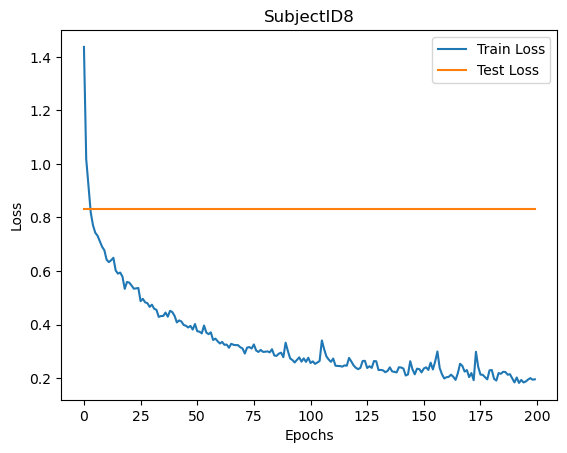

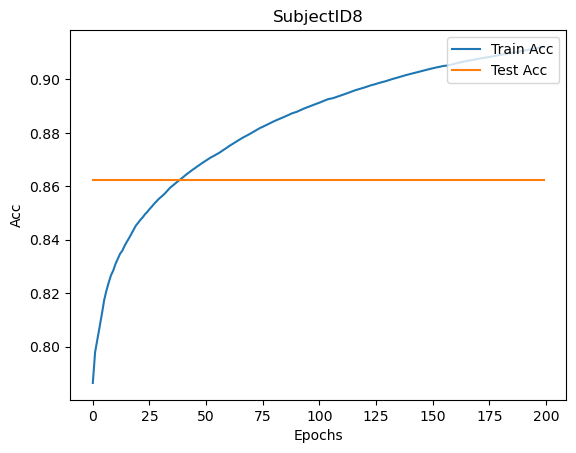


Subject 9
| epoch   0 | 0.1113 s/epoch | train loss 1.4607
| epoch   1 | 0.1114 s/epoch | train loss 1.0195
| epoch   2 | 0.1113 s/epoch | train loss 0.8812
| epoch   3 | 0.1100 s/epoch | train loss 0.8245
| epoch   4 | 0.1109 s/epoch | train loss 0.7953
| epoch   5 | 0.1120 s/epoch | train loss 0.7515
| epoch   6 | 0.1100 s/epoch | train loss 0.7140
| epoch   7 | 0.1111 s/epoch | train loss 0.6701
| epoch   8 | 0.1106 s/epoch | train loss 0.6662
| epoch   9 | 0.1101 s/epoch | train loss 0.6458
| epoch  10 | 0.1117 s/epoch | train loss 0.6279
| epoch  11 | 0.1104 s/epoch | train loss 0.6259
| epoch  12 | 0.1122 s/epoch | train loss 0.6040
| epoch  13 | 0.1121 s/epoch | train loss 0.5933
| epoch  14 | 0.1108 s/epoch | train loss 0.5777
| epoch  15 | 0.1115 s/epoch | train loss 0.5712
| epoch  16 | 0.1102 s/epoch | train loss 0.5740
| epoch  17 | 0.1114 s/epoch | train loss 0.5634
| epoch  18 | 0.1118 s/epoch | train loss 0.5242
| epoch  19 | 0.1109 s/epoch | train loss 0.5329
| epoch  

| epoch 167 | 0.0930 s/epoch | train loss 0.2517
| epoch 168 | 0.0935 s/epoch | train loss 0.2330
| epoch 169 | 0.0929 s/epoch | train loss 0.2301
| epoch 170 | 0.0931 s/epoch | train loss 0.2309
| epoch 171 | 0.0932 s/epoch | train loss 0.2191
| epoch 172 | 0.0934 s/epoch | train loss 0.2571
| epoch 173 | 0.0935 s/epoch | train loss 0.2329
| epoch 174 | 0.0928 s/epoch | train loss 0.2422
| epoch 175 | 0.0925 s/epoch | train loss 0.2352
| epoch 176 | 0.0935 s/epoch | train loss 0.2330
| epoch 177 | 0.0933 s/epoch | train loss 0.2463
| epoch 178 | 0.0941 s/epoch | train loss 0.2267
| epoch 179 | 0.0934 s/epoch | train loss 0.2012
| epoch 180 | 0.0924 s/epoch | train loss 0.1966
| epoch 181 | 0.0928 s/epoch | train loss 0.2062
| epoch 182 | 0.0929 s/epoch | train loss 0.2327
| epoch 183 | 0.0939 s/epoch | train loss 0.2217
| epoch 184 | 0.0933 s/epoch | train loss 0.2152
| epoch 185 | 0.0932 s/epoch | train loss 0.2178
| epoch 186 | 0.0933 s/epoch | train loss 0.2044
| epoch 187 | 0.0927

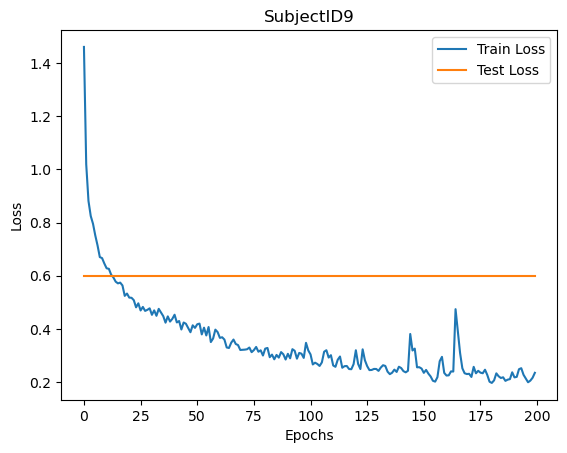

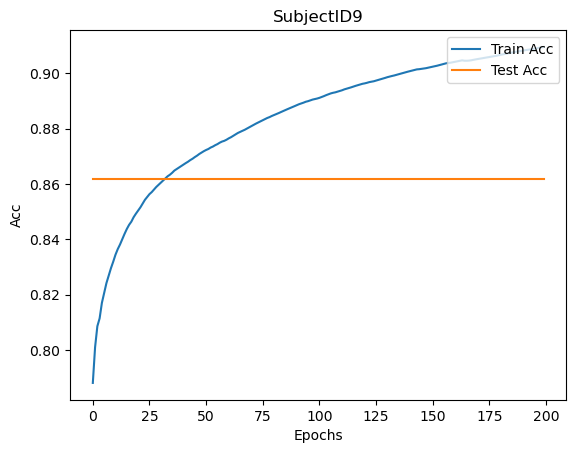


Subject 10
| epoch   0 | 0.0964 s/epoch | train loss 1.5304
| epoch   1 | 0.0964 s/epoch | train loss 1.0831
| epoch   2 | 0.0968 s/epoch | train loss 0.9544
| epoch   3 | 0.0963 s/epoch | train loss 0.8702
| epoch   4 | 0.0967 s/epoch | train loss 0.8083
| epoch   5 | 0.0972 s/epoch | train loss 0.7816
| epoch   6 | 0.0966 s/epoch | train loss 0.7575
| epoch   7 | 0.0967 s/epoch | train loss 0.7602
| epoch   8 | 0.0966 s/epoch | train loss 0.6871
| epoch   9 | 0.0961 s/epoch | train loss 0.6814
| epoch  10 | 0.0969 s/epoch | train loss 0.6685
| epoch  11 | 0.0965 s/epoch | train loss 0.6681
| epoch  12 | 0.0965 s/epoch | train loss 0.6412
| epoch  13 | 0.0971 s/epoch | train loss 0.6121
| epoch  14 | 0.0965 s/epoch | train loss 0.6304
| epoch  15 | 0.0973 s/epoch | train loss 0.6112
| epoch  16 | 0.0971 s/epoch | train loss 0.5962
| epoch  17 | 0.0968 s/epoch | train loss 0.5832
| epoch  18 | 0.0962 s/epoch | train loss 0.5581
| epoch  19 | 0.0968 s/epoch | train loss 0.5787
| epoch 

| epoch 167 | 0.1145 s/epoch | train loss 0.2357
| epoch 168 | 0.1145 s/epoch | train loss 0.2459
| epoch 169 | 0.1141 s/epoch | train loss 0.2209
| epoch 170 | 0.1144 s/epoch | train loss 0.2173
| epoch 171 | 0.1147 s/epoch | train loss 0.2148
| epoch 172 | 0.1149 s/epoch | train loss 0.1945
| epoch 173 | 0.1145 s/epoch | train loss 0.2149
| epoch 174 | 0.1133 s/epoch | train loss 0.2170
| epoch 175 | 0.1168 s/epoch | train loss 0.2631
| epoch 176 | 0.1153 s/epoch | train loss 0.2240
| epoch 177 | 0.1144 s/epoch | train loss 0.2103
| epoch 178 | 0.1143 s/epoch | train loss 0.1938
| epoch 179 | 0.1157 s/epoch | train loss 0.2179
| epoch 180 | 0.1148 s/epoch | train loss 0.2054
| epoch 181 | 0.1151 s/epoch | train loss 0.2028
| epoch 182 | 0.1146 s/epoch | train loss 0.2225
| epoch 183 | 0.1147 s/epoch | train loss 0.1971
| epoch 184 | 0.1159 s/epoch | train loss 0.1931
| epoch 185 | 0.1143 s/epoch | train loss 0.2572
| epoch 186 | 0.1142 s/epoch | train loss 0.2352
| epoch 187 | 0.1149

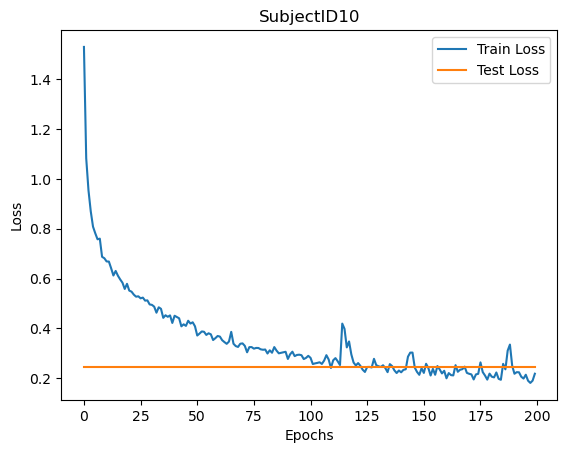

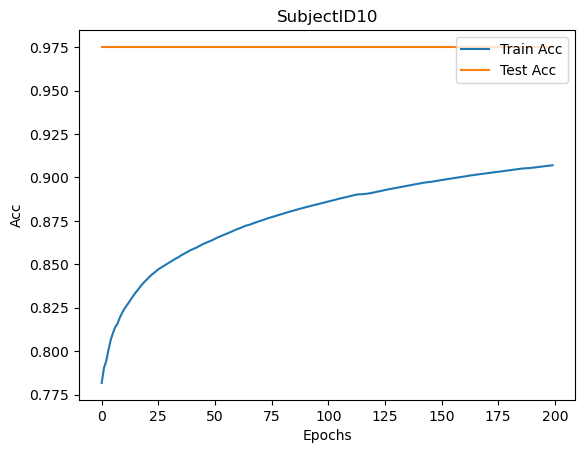


Subject 11
| epoch   0 | 0.1144 s/epoch | train loss 1.4337
| epoch   1 | 0.1143 s/epoch | train loss 1.0711
| epoch   2 | 0.1134 s/epoch | train loss 1.0004
| epoch   3 | 0.1131 s/epoch | train loss 0.9225
| epoch   4 | 0.1136 s/epoch | train loss 0.8053
| epoch   5 | 0.1140 s/epoch | train loss 0.8145
| epoch   6 | 0.1138 s/epoch | train loss 0.7717
| epoch   7 | 0.1136 s/epoch | train loss 0.7686
| epoch   8 | 0.1138 s/epoch | train loss 0.6948
| epoch   9 | 0.1132 s/epoch | train loss 0.6998
| epoch  10 | 0.1123 s/epoch | train loss 0.6637
| epoch  11 | 0.1132 s/epoch | train loss 0.6430
| epoch  12 | 0.1143 s/epoch | train loss 0.6189
| epoch  13 | 0.1142 s/epoch | train loss 0.6203
| epoch  14 | 0.1132 s/epoch | train loss 0.6128
| epoch  15 | 0.1153 s/epoch | train loss 0.5907
| epoch  16 | 0.1142 s/epoch | train loss 0.6014
| epoch  17 | 0.1133 s/epoch | train loss 0.5833
| epoch  18 | 0.1137 s/epoch | train loss 0.5772
| epoch  19 | 0.1132 s/epoch | train loss 0.5562
| epoch 

| epoch 167 | 0.1140 s/epoch | train loss 0.4928
| epoch 168 | 0.1139 s/epoch | train loss 0.5240
| epoch 169 | 0.1132 s/epoch | train loss 0.5071
| epoch 170 | 0.1139 s/epoch | train loss 0.4660
| epoch 171 | 0.1140 s/epoch | train loss 0.4188
| epoch 172 | 0.1139 s/epoch | train loss 0.3889
| epoch 173 | 0.1140 s/epoch | train loss 0.3565
| epoch 174 | 0.1130 s/epoch | train loss 0.3554
| epoch 175 | 0.1148 s/epoch | train loss 0.3820
| epoch 176 | 0.1136 s/epoch | train loss 0.5322
| epoch 177 | 0.1142 s/epoch | train loss 0.5418
| epoch 178 | 0.1137 s/epoch | train loss 0.4570
| epoch 179 | 0.1146 s/epoch | train loss 0.4102
| epoch 180 | 0.1140 s/epoch | train loss 0.4159
| epoch 181 | 0.1140 s/epoch | train loss 0.3850
| epoch 182 | 0.1149 s/epoch | train loss 0.3485
| epoch 183 | 0.1136 s/epoch | train loss 0.3393
| epoch 184 | 0.1139 s/epoch | train loss 0.3352
| epoch 185 | 0.1136 s/epoch | train loss 0.3037
| epoch 186 | 0.1136 s/epoch | train loss 0.3191
| epoch 187 | 0.1139

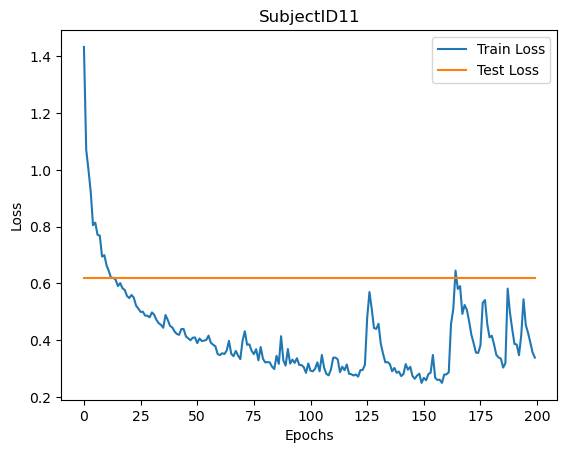

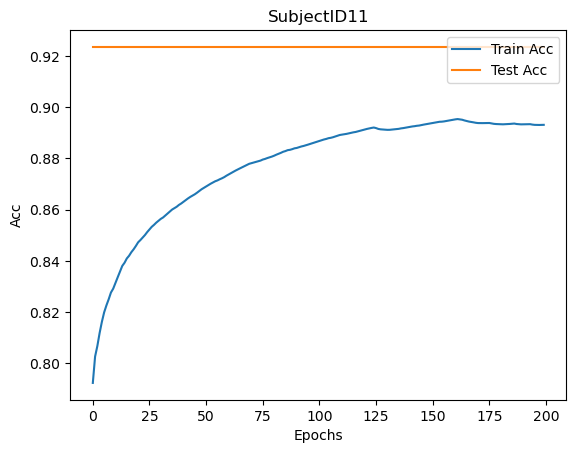


Subject 12
| epoch   0 | 0.1085 s/epoch | train loss 1.4717
| epoch   1 | 0.1073 s/epoch | train loss 1.0548
| epoch   2 | 0.1081 s/epoch | train loss 0.9266
| epoch   3 | 0.1069 s/epoch | train loss 0.8505
| epoch   4 | 0.0909 s/epoch | train loss 0.8261
| epoch   5 | 0.0909 s/epoch | train loss 0.8227
| epoch   6 | 0.0909 s/epoch | train loss 0.7624
| epoch   7 | 0.0913 s/epoch | train loss 0.7394
| epoch   8 | 0.0913 s/epoch | train loss 0.6978
| epoch   9 | 0.0917 s/epoch | train loss 0.6802
| epoch  10 | 0.0906 s/epoch | train loss 0.6488
| epoch  11 | 0.0907 s/epoch | train loss 0.6710
| epoch  12 | 0.0904 s/epoch | train loss 0.6664
| epoch  13 | 0.0910 s/epoch | train loss 0.6090
| epoch  14 | 0.0908 s/epoch | train loss 0.5816
| epoch  15 | 0.0909 s/epoch | train loss 0.6085
| epoch  16 | 0.0913 s/epoch | train loss 0.5694
| epoch  17 | 0.0906 s/epoch | train loss 0.5812
| epoch  18 | 0.0913 s/epoch | train loss 0.5700
| epoch  19 | 0.0908 s/epoch | train loss 0.5401
| epoch 

| epoch 167 | 0.1073 s/epoch | train loss 0.1977
| epoch 168 | 0.1069 s/epoch | train loss 0.2119
| epoch 169 | 0.1091 s/epoch | train loss 0.2120
| epoch 170 | 0.1088 s/epoch | train loss 0.2065
| epoch 171 | 0.1079 s/epoch | train loss 0.1926
| epoch 172 | 0.1070 s/epoch | train loss 0.2198
| epoch 173 | 0.1086 s/epoch | train loss 0.2141
| epoch 174 | 0.1099 s/epoch | train loss 0.2090
| epoch 175 | 0.1086 s/epoch | train loss 0.2428
| epoch 176 | 0.1079 s/epoch | train loss 0.2176
| epoch 177 | 0.1085 s/epoch | train loss 0.2155
| epoch 178 | 0.1077 s/epoch | train loss 0.1995
| epoch 179 | 0.1078 s/epoch | train loss 0.1958
| epoch 180 | 0.1079 s/epoch | train loss 0.2090
| epoch 181 | 0.1077 s/epoch | train loss 0.2103
| epoch 182 | 0.1086 s/epoch | train loss 0.2039
| epoch 183 | 0.1088 s/epoch | train loss 0.2233
| epoch 184 | 0.1097 s/epoch | train loss 0.2050
| epoch 185 | 0.1081 s/epoch | train loss 0.2338
| epoch 186 | 0.1079 s/epoch | train loss 0.3147
| epoch 187 | 0.1073

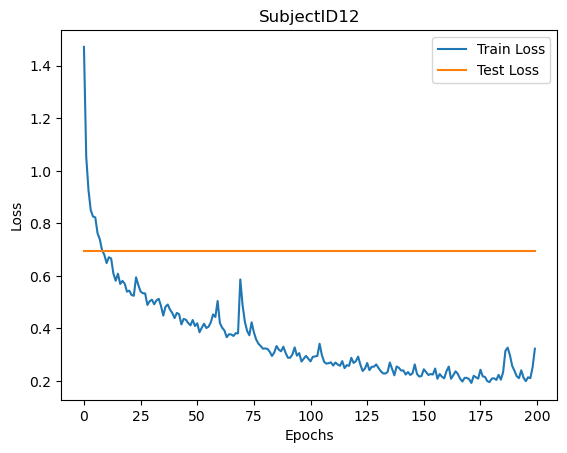

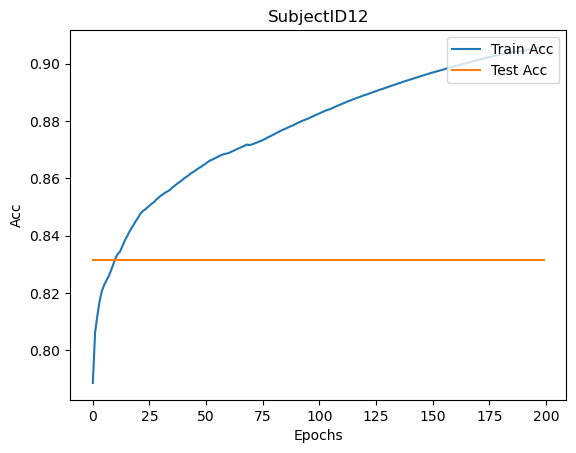


Subject 13
| epoch   0 | 0.1078 s/epoch | train loss 1.3487
| epoch   1 | 0.1076 s/epoch | train loss 0.9812
| epoch   2 | 0.1090 s/epoch | train loss 0.8814
| epoch   3 | 0.1088 s/epoch | train loss 0.8469
| epoch   4 | 0.1089 s/epoch | train loss 0.7850
| epoch   5 | 0.1084 s/epoch | train loss 0.7430
| epoch   6 | 0.1091 s/epoch | train loss 0.7157
| epoch   7 | 0.1081 s/epoch | train loss 0.6783
| epoch   8 | 0.1098 s/epoch | train loss 0.6820
| epoch   9 | 0.1079 s/epoch | train loss 0.6396
| epoch  10 | 0.1081 s/epoch | train loss 0.6352
| epoch  11 | 0.1076 s/epoch | train loss 0.6102
| epoch  12 | 0.1089 s/epoch | train loss 0.6191
| epoch  13 | 0.1072 s/epoch | train loss 0.5694
| epoch  14 | 0.1092 s/epoch | train loss 0.5764
| epoch  15 | 0.1086 s/epoch | train loss 0.5527
| epoch  16 | 0.1087 s/epoch | train loss 0.5520
| epoch  17 | 0.1082 s/epoch | train loss 0.5903
| epoch  18 | 0.1092 s/epoch | train loss 0.5705
| epoch  19 | 0.1088 s/epoch | train loss 0.5374
| epoch 

| epoch 167 | 0.1084 s/epoch | train loss 0.2977
| epoch 168 | 0.1073 s/epoch | train loss 0.2698
| epoch 169 | 0.1079 s/epoch | train loss 0.2581
| epoch 170 | 0.1081 s/epoch | train loss 0.2823
| epoch 171 | 0.1089 s/epoch | train loss 0.2339
| epoch 172 | 0.1090 s/epoch | train loss 0.2467
| epoch 173 | 0.1076 s/epoch | train loss 0.2316
| epoch 174 | 0.1090 s/epoch | train loss 0.2256
| epoch 175 | 0.1091 s/epoch | train loss 0.2358
| epoch 176 | 0.1091 s/epoch | train loss 0.2912
| epoch 177 | 0.1090 s/epoch | train loss 0.2625
| epoch 178 | 0.1083 s/epoch | train loss 0.2448
| epoch 179 | 0.1080 s/epoch | train loss 0.2566
| epoch 180 | 0.1098 s/epoch | train loss 0.2435
| epoch 181 | 0.1082 s/epoch | train loss 0.2328
| epoch 182 | 0.1089 s/epoch | train loss 0.2190
| epoch 183 | 0.1090 s/epoch | train loss 0.2229
| epoch 184 | 0.1095 s/epoch | train loss 0.2176
| epoch 185 | 0.1077 s/epoch | train loss 0.2120
| epoch 186 | 0.1078 s/epoch | train loss 0.2238
| epoch 187 | 0.1077

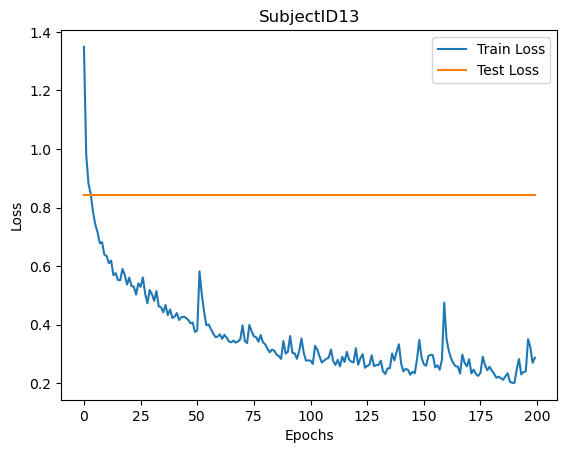

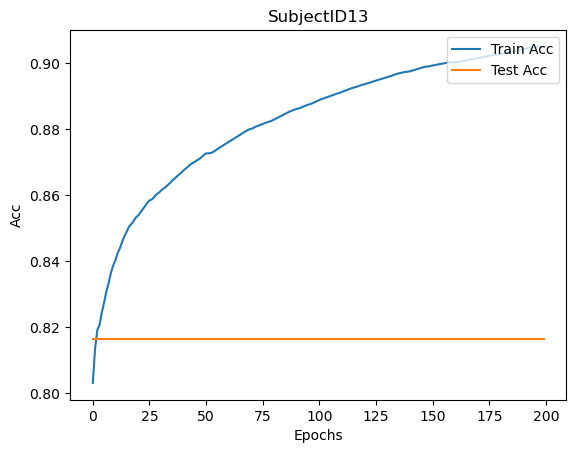


Subject 14
| epoch   0 | 0.1130 s/epoch | train loss 1.4855
| epoch   1 | 0.1124 s/epoch | train loss 1.1560
| epoch   2 | 0.1117 s/epoch | train loss 1.0121
| epoch   3 | 0.1137 s/epoch | train loss 0.9251
| epoch   4 | 0.1133 s/epoch | train loss 0.8567
| epoch   5 | 0.1137 s/epoch | train loss 0.8497
| epoch   6 | 0.1117 s/epoch | train loss 0.8889
| epoch   7 | 0.1125 s/epoch | train loss 0.8638
| epoch   8 | 0.1135 s/epoch | train loss 0.8006
| epoch   9 | 0.1121 s/epoch | train loss 0.7814
| epoch  10 | 0.1136 s/epoch | train loss 0.7508
| epoch  11 | 0.1134 s/epoch | train loss 0.7103
| epoch  12 | 0.1124 s/epoch | train loss 0.7040
| epoch  13 | 0.1128 s/epoch | train loss 0.7388
| epoch  14 | 0.1130 s/epoch | train loss 0.7016
| epoch  15 | 0.1143 s/epoch | train loss 0.6847
| epoch  16 | 0.1124 s/epoch | train loss 0.8392
| epoch  17 | 0.1122 s/epoch | train loss 0.7358
| epoch  18 | 0.1119 s/epoch | train loss 0.7610
| epoch  19 | 0.1120 s/epoch | train loss 0.7286
| epoch 

| epoch 167 | 0.0944 s/epoch | train loss 0.4790
| epoch 168 | 0.0946 s/epoch | train loss 0.4507
| epoch 169 | 0.0946 s/epoch | train loss 0.4315
| epoch 170 | 0.0941 s/epoch | train loss 0.4465
| epoch 171 | 0.0944 s/epoch | train loss 0.5184
| epoch 172 | 0.0945 s/epoch | train loss 0.4977
| epoch 173 | 0.0946 s/epoch | train loss 0.4733
| epoch 174 | 0.0947 s/epoch | train loss 0.5271
| epoch 175 | 0.0940 s/epoch | train loss 0.6012
| epoch 176 | 0.0941 s/epoch | train loss 0.5158
| epoch 177 | 0.0942 s/epoch | train loss 0.4663
| epoch 178 | 0.0941 s/epoch | train loss 0.4517
| epoch 179 | 0.0940 s/epoch | train loss 0.4258
| epoch 180 | 0.0944 s/epoch | train loss 0.4297
| epoch 181 | 0.0953 s/epoch | train loss 0.4043
| epoch 182 | 0.0937 s/epoch | train loss 0.3983
| epoch 183 | 0.0955 s/epoch | train loss 0.4238
| epoch 184 | 0.0947 s/epoch | train loss 0.4260
| epoch 185 | 0.0946 s/epoch | train loss 0.4167
| epoch 186 | 0.0946 s/epoch | train loss 0.3834
| epoch 187 | 0.0947

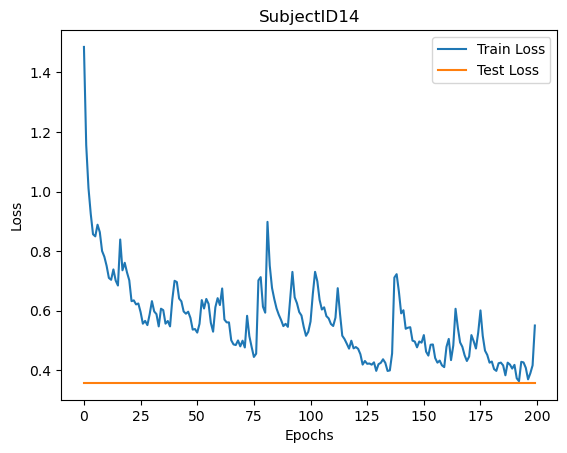

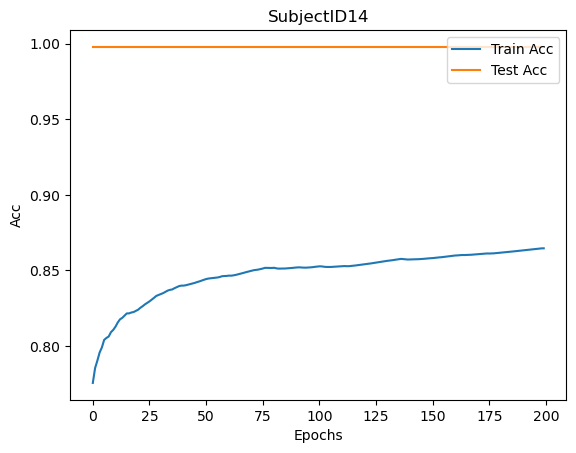


Subject 15
| epoch   0 | 0.0985 s/epoch | train loss 1.5410
| epoch   1 | 0.0982 s/epoch | train loss 1.1049
| epoch   2 | 0.0983 s/epoch | train loss 0.9674
| epoch   3 | 0.0986 s/epoch | train loss 0.8639
| epoch   4 | 0.0985 s/epoch | train loss 0.8540
| epoch   5 | 0.0976 s/epoch | train loss 0.7870
| epoch   6 | 0.0984 s/epoch | train loss 0.7290
| epoch   7 | 0.0980 s/epoch | train loss 0.7106
| epoch   8 | 0.0981 s/epoch | train loss 0.7023
| epoch   9 | 0.0983 s/epoch | train loss 0.6757
| epoch  10 | 0.0983 s/epoch | train loss 0.6454
| epoch  11 | 0.0984 s/epoch | train loss 0.6348
| epoch  12 | 0.0975 s/epoch | train loss 0.6190
| epoch  13 | 0.0984 s/epoch | train loss 0.6065
| epoch  14 | 0.0982 s/epoch | train loss 0.5734
| epoch  15 | 0.0980 s/epoch | train loss 0.5955
| epoch  16 | 0.0979 s/epoch | train loss 0.5808
| epoch  17 | 0.0977 s/epoch | train loss 0.5535
| epoch  18 | 0.0983 s/epoch | train loss 0.5344
| epoch  19 | 0.0983 s/epoch | train loss 0.5485
| epoch 

| epoch 167 | 0.1174 s/epoch | train loss 0.2048
| epoch 168 | 0.1166 s/epoch | train loss 0.1870
| epoch 169 | 0.1181 s/epoch | train loss 0.2000
| epoch 170 | 0.1169 s/epoch | train loss 0.2002
| epoch 171 | 0.1172 s/epoch | train loss 0.1907
| epoch 172 | 0.1172 s/epoch | train loss 0.1994
| epoch 173 | 0.1177 s/epoch | train loss 0.1971
| epoch 174 | 0.1162 s/epoch | train loss 0.1973
| epoch 175 | 0.1165 s/epoch | train loss 0.2106
| epoch 176 | 0.1163 s/epoch | train loss 0.2082
| epoch 177 | 0.1175 s/epoch | train loss 0.1942
| epoch 178 | 0.1177 s/epoch | train loss 0.1768
| epoch 179 | 0.1171 s/epoch | train loss 0.1797
| epoch 180 | 0.1159 s/epoch | train loss 0.1911
| epoch 181 | 0.1173 s/epoch | train loss 0.1755
| epoch 182 | 0.1174 s/epoch | train loss 0.1842
| epoch 183 | 0.1158 s/epoch | train loss 0.1775
| epoch 184 | 0.1171 s/epoch | train loss 0.1742
| epoch 185 | 0.1171 s/epoch | train loss 0.1694
| epoch 186 | 0.1191 s/epoch | train loss 0.1758
| epoch 187 | 0.1180

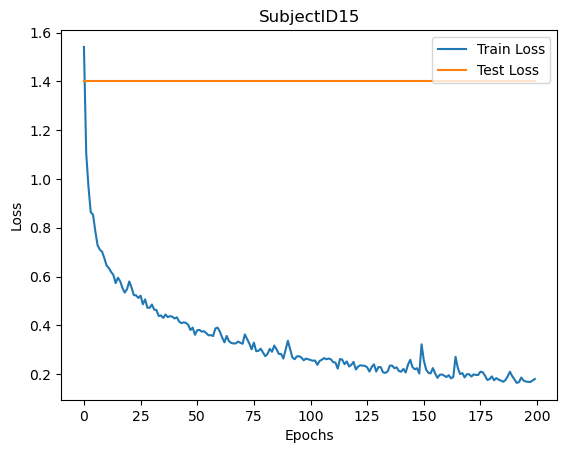

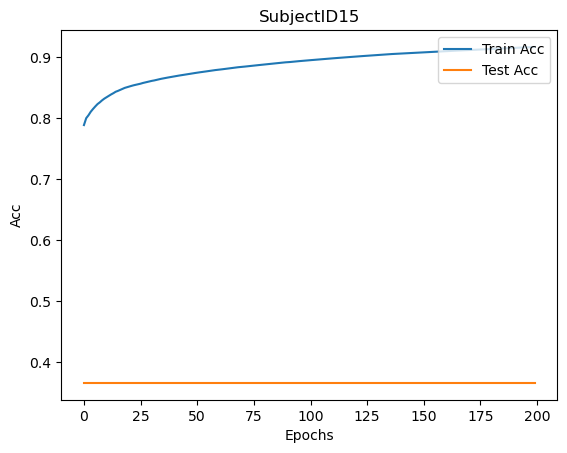

~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~


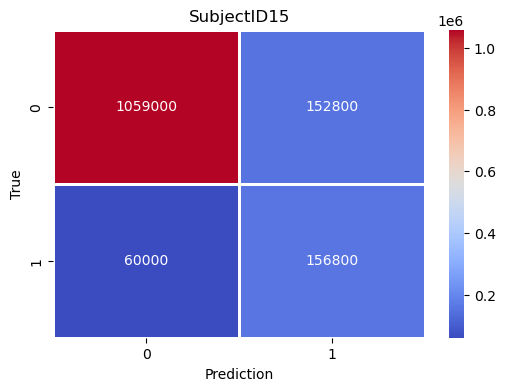

Distillation_teacher(Mobilnet)_Acc: 0.8510429791404172
Distillation_teacher(Mobilnet)_Rec: 0.7232472324723247
Distillation_teacher(Mobilnet)_Pre: 0.5064599483204134
Distillation_teacher(Mobilnet)_F1: 0.5957446808510639


<Figure size 640x480 with 0 Axes>

In [18]:
#Layer 1 Training teacher
teacher_student_train_preds = []
teacher_student_train_gt = []


for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    model_teacher_student = MobileNetV3_Small_KD().to(device)
    #model_teacher_student = Net_Teacher_Student(config).to(device) 
    model_teacher_student.train() 
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher_student = torch.optim.Adam(model_teacher_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    Layer = False
    training_teacher_student(trainloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student,alpha,testloader,Layer,sub)
    #testing_teacher_student(testloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student)


show_CM_teacher_student(teacher_student_train_preds, teacher_student_train_gt)
teacher_Student_eval_table = evaluation(teacher_student_train_preds, teacher_student_train_gt)    

print("Distillation_teacher(Mobilnet)_Acc:",teacher_Student_eval_table[0])
print("Distillation_teacher(Mobilnet)_Rec:",teacher_Student_eval_table[1])
print("Distillation_teacher(Mobilnet)_Pre:",teacher_Student_eval_table[2])
print("Distillation_teacher(Mobilnet)_F1:",teacher_Student_eval_table[3])


Subject 1
| epoch   0 | 0.1318 s/epoch | train loss 1.0168
| epoch   1 | 0.1294 s/epoch | train loss 1.1397
| epoch   2 | 0.1283 s/epoch | train loss 0.8015
| epoch   3 | 0.1300 s/epoch | train loss 0.7019
| epoch   4 | 0.1291 s/epoch | train loss 0.6499
| epoch   5 | 0.1288 s/epoch | train loss 0.6458
| epoch   6 | 0.1284 s/epoch | train loss 0.5763
| epoch   7 | 0.1292 s/epoch | train loss 0.5627
| epoch   8 | 0.1292 s/epoch | train loss 0.6519
| epoch   9 | 0.1294 s/epoch | train loss 0.6539
| epoch  10 | 0.1295 s/epoch | train loss 0.5533
| epoch  11 | 0.1287 s/epoch | train loss 0.5937
| epoch  12 | 0.1295 s/epoch | train loss 0.5302
| epoch  13 | 0.1292 s/epoch | train loss 0.5156
| epoch  14 | 0.1292 s/epoch | train loss 0.5224
| epoch  15 | 0.1296 s/epoch | train loss 0.4932
| epoch  16 | 0.1290 s/epoch | train loss 0.4617
| epoch  17 | 0.1289 s/epoch | train loss 0.4521
| epoch  18 | 0.1295 s/epoch | train loss 0.5255
| epoch  19 | 0.1286 s/epoch | train loss 0.4491
| epoch  

| epoch 167 | 0.1086 s/epoch | train loss 0.1504
| epoch 168 | 0.1079 s/epoch | train loss 0.1390
| epoch 169 | 0.1073 s/epoch | train loss 0.1330
| epoch 170 | 0.1083 s/epoch | train loss 0.1164
| epoch 171 | 0.1080 s/epoch | train loss 0.1180
| epoch 172 | 0.1082 s/epoch | train loss 0.1078
| epoch 173 | 0.1081 s/epoch | train loss 0.1077
| epoch 174 | 0.1089 s/epoch | train loss 0.1140
| epoch 175 | 0.1083 s/epoch | train loss 0.1177
| epoch 176 | 0.1078 s/epoch | train loss 0.1259
| epoch 177 | 0.1081 s/epoch | train loss 0.1203
| epoch 178 | 0.1076 s/epoch | train loss 0.1040
| epoch 179 | 0.1077 s/epoch | train loss 0.0997
| epoch 180 | 0.1076 s/epoch | train loss 0.1350
| epoch 181 | 0.1084 s/epoch | train loss 0.1984
| epoch 182 | 0.1076 s/epoch | train loss 0.1542
| epoch 183 | 0.1083 s/epoch | train loss 0.1548
| epoch 184 | 0.1074 s/epoch | train loss 0.5453
| epoch 185 | 0.1081 s/epoch | train loss 0.4236
| epoch 186 | 0.1084 s/epoch | train loss 0.3026
| epoch 187 | 0.1082

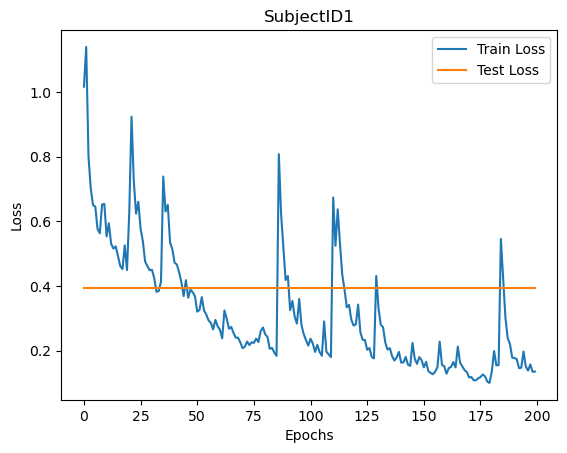

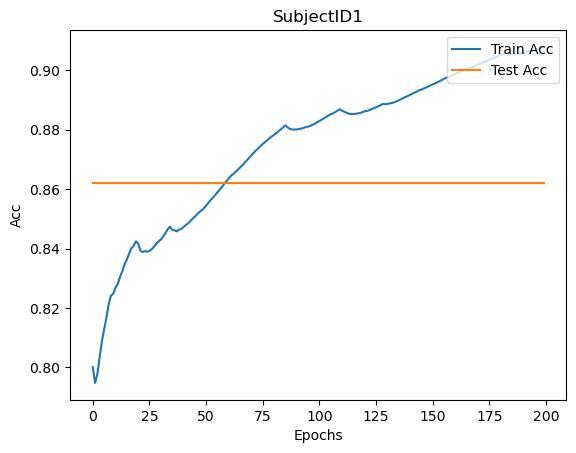


Subject 2
| epoch   0 | 0.1036 s/epoch | train loss 1.0969
| epoch   1 | 0.1055 s/epoch | train loss 0.9593
| epoch   2 | 0.1044 s/epoch | train loss 0.8309
| epoch   3 | 0.1044 s/epoch | train loss 0.8281
| epoch   4 | 0.1043 s/epoch | train loss 0.7957
| epoch   5 | 0.1043 s/epoch | train loss 0.8049
| epoch   6 | 0.1050 s/epoch | train loss 0.6546
| epoch   7 | 0.1042 s/epoch | train loss 0.7119
| epoch   8 | 0.1044 s/epoch | train loss 0.6276
| epoch   9 | 0.1049 s/epoch | train loss 0.5452
| epoch  10 | 0.1044 s/epoch | train loss 0.4993
| epoch  11 | 0.1041 s/epoch | train loss 0.6570
| epoch  12 | 0.1046 s/epoch | train loss 0.5912
| epoch  13 | 0.1044 s/epoch | train loss 0.5417
| epoch  14 | 0.1052 s/epoch | train loss 0.6535
| epoch  15 | 0.1046 s/epoch | train loss 0.5858
| epoch  16 | 0.1044 s/epoch | train loss 0.6337
| epoch  17 | 0.1047 s/epoch | train loss 0.7846
| epoch  18 | 0.1043 s/epoch | train loss 0.6361
| epoch  19 | 0.1042 s/epoch | train loss 0.6020
| epoch  

| epoch 167 | 0.1259 s/epoch | train loss 0.2954
| epoch 168 | 0.1258 s/epoch | train loss 0.2626
| epoch 169 | 0.1261 s/epoch | train loss 0.1992
| epoch 170 | 0.1246 s/epoch | train loss 0.1804
| epoch 171 | 0.1253 s/epoch | train loss 0.1710
| epoch 172 | 0.1252 s/epoch | train loss 0.1581
| epoch 173 | 0.1249 s/epoch | train loss 0.1502
| epoch 174 | 0.1256 s/epoch | train loss 0.2298
| epoch 175 | 0.1259 s/epoch | train loss 0.1526
| epoch 176 | 0.1253 s/epoch | train loss 0.1504
| epoch 177 | 0.1250 s/epoch | train loss 0.1619
| epoch 178 | 0.1252 s/epoch | train loss 0.1721
| epoch 179 | 0.1258 s/epoch | train loss 0.4470
| epoch 180 | 0.1253 s/epoch | train loss 0.2866
| epoch 181 | 0.1251 s/epoch | train loss 0.2178
| epoch 182 | 0.1259 s/epoch | train loss 0.1745
| epoch 183 | 0.1249 s/epoch | train loss 0.1607
| epoch 184 | 0.1263 s/epoch | train loss 0.3263
| epoch 185 | 0.1253 s/epoch | train loss 0.2077
| epoch 186 | 0.1258 s/epoch | train loss 0.2049
| epoch 187 | 0.1245

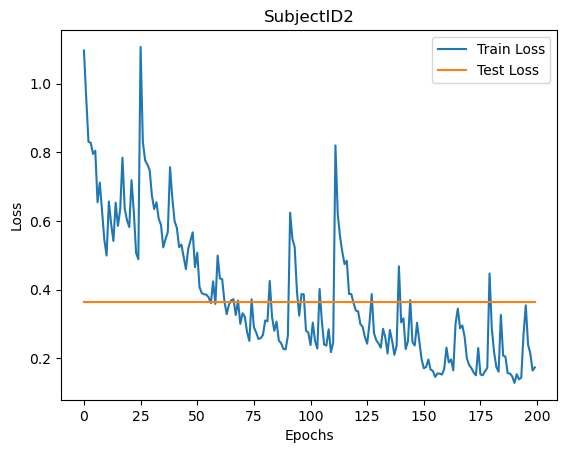

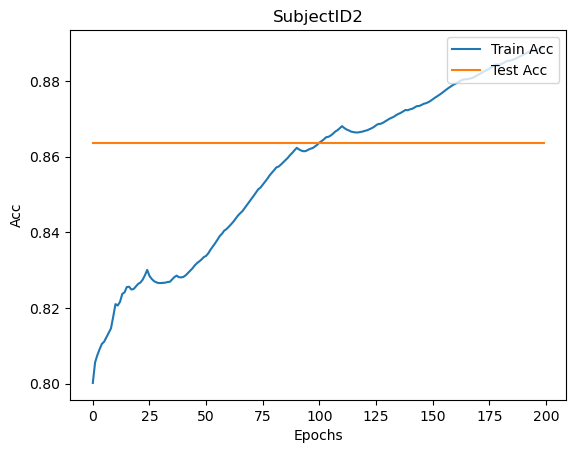


Subject 3
| epoch   0 | 0.1257 s/epoch | train loss 0.9866
| epoch   1 | 0.1254 s/epoch | train loss 0.7156
| epoch   2 | 0.1251 s/epoch | train loss 0.5904
| epoch   3 | 0.1251 s/epoch | train loss 0.5582
| epoch   4 | 0.1251 s/epoch | train loss 0.6022
| epoch   5 | 0.1256 s/epoch | train loss 0.5372
| epoch   6 | 0.1249 s/epoch | train loss 0.5093
| epoch   7 | 0.1240 s/epoch | train loss 0.4892
| epoch   8 | 0.1258 s/epoch | train loss 0.4676
| epoch   9 | 0.1256 s/epoch | train loss 0.4341
| epoch  10 | 0.1256 s/epoch | train loss 0.4020
| epoch  11 | 0.1264 s/epoch | train loss 0.4217
| epoch  12 | 0.1251 s/epoch | train loss 0.4015
| epoch  13 | 0.1263 s/epoch | train loss 0.3778
| epoch  14 | 0.1253 s/epoch | train loss 0.3955
| epoch  15 | 0.1260 s/epoch | train loss 0.3982
| epoch  16 | 0.1256 s/epoch | train loss 0.3612
| epoch  17 | 0.1259 s/epoch | train loss 0.3423
| epoch  18 | 0.1253 s/epoch | train loss 0.3493
| epoch  19 | 0.1262 s/epoch | train loss 0.3266
| epoch  

| epoch 167 | 0.1257 s/epoch | train loss 0.1042
| epoch 168 | 0.1251 s/epoch | train loss 0.0963
| epoch 169 | 0.1254 s/epoch | train loss 0.0881
| epoch 170 | 0.1260 s/epoch | train loss 0.0945
| epoch 171 | 0.1248 s/epoch | train loss 0.0943
| epoch 172 | 0.1269 s/epoch | train loss 0.0883
| epoch 173 | 0.1236 s/epoch | train loss 0.0871
| epoch 174 | 0.1222 s/epoch | train loss 0.1073
| epoch 175 | 0.1227 s/epoch | train loss 0.0984
| epoch 176 | 0.1222 s/epoch | train loss 0.0934
| epoch 177 | 0.1204 s/epoch | train loss 0.1235
| epoch 178 | 0.1215 s/epoch | train loss 0.1229
| epoch 179 | 0.1214 s/epoch | train loss 0.1798
| epoch 180 | 0.1216 s/epoch | train loss 0.1593
| epoch 181 | 0.1218 s/epoch | train loss 0.1348
| epoch 182 | 0.1210 s/epoch | train loss 0.1099
| epoch 183 | 0.1053 s/epoch | train loss 0.1038
| epoch 184 | 0.1059 s/epoch | train loss 0.1150
| epoch 185 | 0.1046 s/epoch | train loss 0.1163
| epoch 186 | 0.1056 s/epoch | train loss 0.1187
| epoch 187 | 0.1048

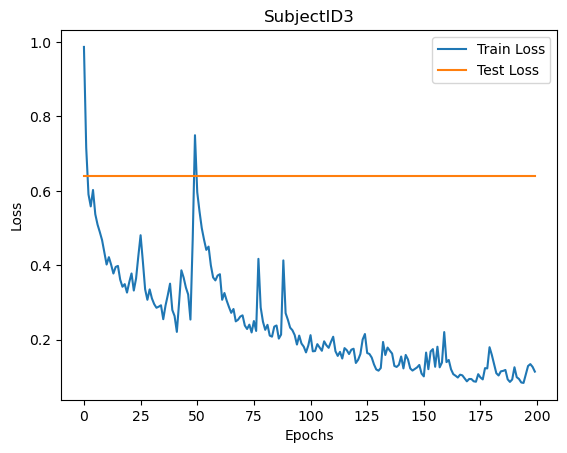

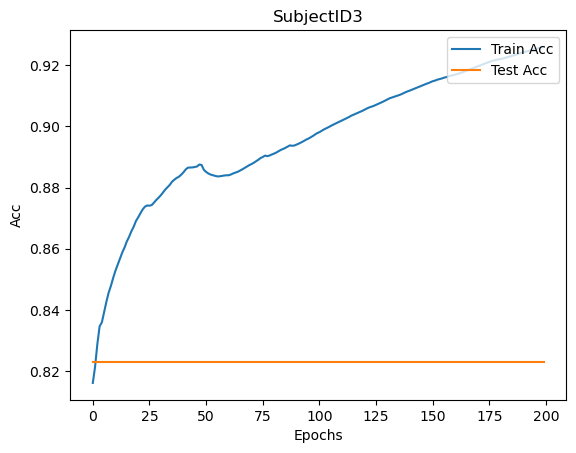


Subject 4
| epoch   0 | 0.1095 s/epoch | train loss 1.0394
| epoch   1 | 0.1095 s/epoch | train loss 0.7640
| epoch   2 | 0.1101 s/epoch | train loss 0.6814
| epoch   3 | 0.1101 s/epoch | train loss 0.6314
| epoch   4 | 0.1089 s/epoch | train loss 0.5799
| epoch   5 | 0.1094 s/epoch | train loss 0.5510
| epoch   6 | 0.1097 s/epoch | train loss 0.5251
| epoch   7 | 0.1103 s/epoch | train loss 0.4964
| epoch   8 | 0.1098 s/epoch | train loss 0.4628
| epoch   9 | 0.1098 s/epoch | train loss 0.4603
| epoch  10 | 0.1094 s/epoch | train loss 0.4351
| epoch  11 | 0.1099 s/epoch | train loss 0.4043
| epoch  12 | 0.1098 s/epoch | train loss 0.4070
| epoch  13 | 0.1099 s/epoch | train loss 0.3873
| epoch  14 | 0.1102 s/epoch | train loss 0.3737
| epoch  15 | 0.1092 s/epoch | train loss 0.3389
| epoch  16 | 0.1095 s/epoch | train loss 0.3787
| epoch  17 | 0.1102 s/epoch | train loss 0.4265
| epoch  18 | 0.1100 s/epoch | train loss 0.4340
| epoch  19 | 0.1093 s/epoch | train loss 0.4198
| epoch  

| epoch 167 | 0.1312 s/epoch | train loss 0.0959
| epoch 168 | 0.1315 s/epoch | train loss 0.0969
| epoch 169 | 0.1315 s/epoch | train loss 0.0902
| epoch 170 | 0.1321 s/epoch | train loss 0.0910
| epoch 171 | 0.1317 s/epoch | train loss 0.0881
| epoch 172 | 0.1321 s/epoch | train loss 0.0892
| epoch 173 | 0.1317 s/epoch | train loss 0.1687
| epoch 174 | 0.1322 s/epoch | train loss 0.2800
| epoch 175 | 0.1319 s/epoch | train loss 0.1675
| epoch 176 | 0.1320 s/epoch | train loss 0.1301
| epoch 177 | 0.1321 s/epoch | train loss 0.1099
| epoch 178 | 0.1326 s/epoch | train loss 0.1078
| epoch 179 | 0.1311 s/epoch | train loss 0.1083
| epoch 180 | 0.1315 s/epoch | train loss 0.1065
| epoch 181 | 0.1314 s/epoch | train loss 0.0992
| epoch 182 | 0.1316 s/epoch | train loss 0.1848
| epoch 183 | 0.1322 s/epoch | train loss 0.1170
| epoch 184 | 0.1315 s/epoch | train loss 0.1002
| epoch 185 | 0.1317 s/epoch | train loss 0.0935
| epoch 186 | 0.1318 s/epoch | train loss 0.0920
| epoch 187 | 0.1318

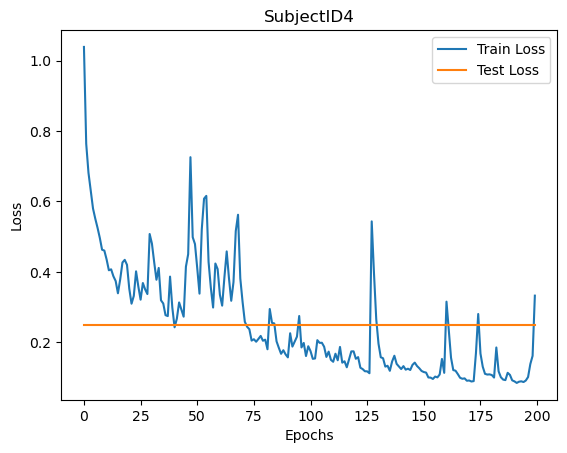

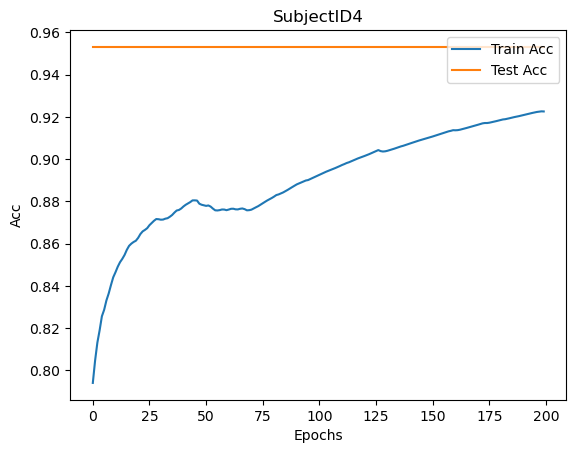


Subject 5
| epoch   0 | 0.1260 s/epoch | train loss 1.0709
| epoch   1 | 0.1253 s/epoch | train loss 0.7320
| epoch   2 | 0.1253 s/epoch | train loss 0.6177
| epoch   3 | 0.1260 s/epoch | train loss 0.6260
| epoch   4 | 0.1257 s/epoch | train loss 0.5416
| epoch   5 | 0.1262 s/epoch | train loss 0.6260
| epoch   6 | 0.1263 s/epoch | train loss 0.6026
| epoch   7 | 0.1263 s/epoch | train loss 0.5731
| epoch   8 | 0.1255 s/epoch | train loss 0.5765
| epoch   9 | 0.1256 s/epoch | train loss 0.6702
| epoch  10 | 0.1260 s/epoch | train loss 0.5591
| epoch  11 | 0.1258 s/epoch | train loss 0.5710
| epoch  12 | 0.1254 s/epoch | train loss 0.6007
| epoch  13 | 0.1257 s/epoch | train loss 0.5294
| epoch  14 | 0.1258 s/epoch | train loss 0.5026
| epoch  15 | 0.1257 s/epoch | train loss 0.4650
| epoch  16 | 0.1256 s/epoch | train loss 0.4232
| epoch  17 | 0.1265 s/epoch | train loss 0.4204
| epoch  18 | 0.1241 s/epoch | train loss 0.4447
| epoch  19 | 0.1262 s/epoch | train loss 0.4197
| epoch  

| epoch 167 | 0.1262 s/epoch | train loss 0.1167
| epoch 168 | 0.1274 s/epoch | train loss 0.1096
| epoch 169 | 0.1267 s/epoch | train loss 0.1683
| epoch 170 | 0.1265 s/epoch | train loss 0.1679
| epoch 171 | 0.1278 s/epoch | train loss 0.1814
| epoch 172 | 0.1276 s/epoch | train loss 0.1559
| epoch 173 | 0.1270 s/epoch | train loss 0.1499
| epoch 174 | 0.1273 s/epoch | train loss 0.1318
| epoch 175 | 0.1273 s/epoch | train loss 0.1988
| epoch 176 | 0.1268 s/epoch | train loss 0.1833
| epoch 177 | 0.1267 s/epoch | train loss 0.1369
| epoch 178 | 0.1276 s/epoch | train loss 0.1351
| epoch 179 | 0.1275 s/epoch | train loss 0.1130
| epoch 180 | 0.1274 s/epoch | train loss 0.1040
| epoch 181 | 0.1277 s/epoch | train loss 0.1081
| epoch 182 | 0.1265 s/epoch | train loss 0.1110
| epoch 183 | 0.1274 s/epoch | train loss 0.0983
| epoch 184 | 0.1274 s/epoch | train loss 0.1081
| epoch 185 | 0.1279 s/epoch | train loss 0.0980
| epoch 186 | 0.1273 s/epoch | train loss 0.0948
| epoch 187 | 0.1273

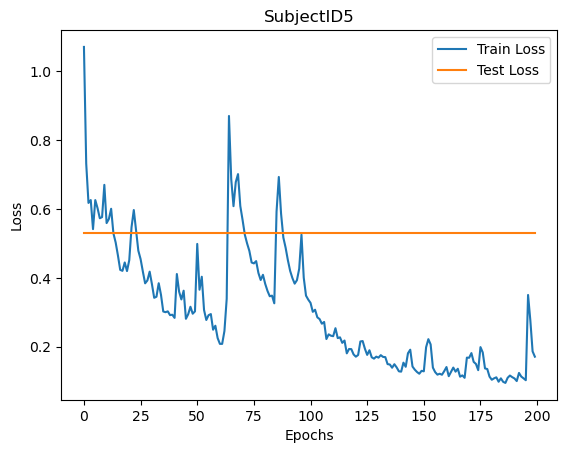

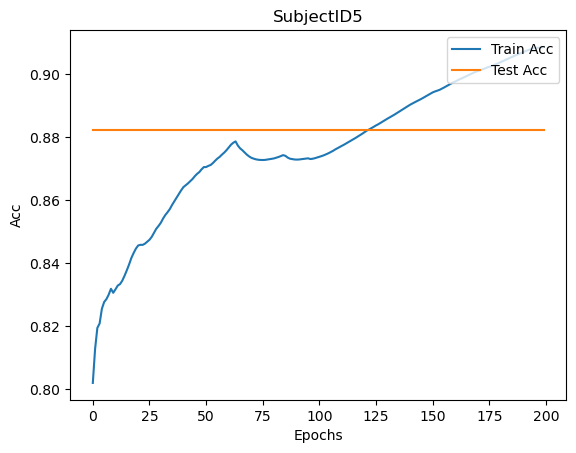


Subject 7
| epoch   0 | 0.1218 s/epoch | train loss 1.0002
| epoch   1 | 0.1209 s/epoch | train loss 0.6647
| epoch   2 | 0.1210 s/epoch | train loss 0.6241
| epoch   3 | 0.1056 s/epoch | train loss 0.5371
| epoch   4 | 0.1030 s/epoch | train loss 0.5223
| epoch   5 | 0.1050 s/epoch | train loss 0.4608
| epoch   6 | 0.1035 s/epoch | train loss 0.4212
| epoch   7 | 0.1039 s/epoch | train loss 0.4394
| epoch   8 | 0.1037 s/epoch | train loss 0.4374
| epoch   9 | 0.1038 s/epoch | train loss 0.4099
| epoch  10 | 0.1040 s/epoch | train loss 0.4133
| epoch  11 | 0.1043 s/epoch | train loss 0.3556
| epoch  12 | 0.1040 s/epoch | train loss 0.3695
| epoch  13 | 0.1033 s/epoch | train loss 0.3390
| epoch  14 | 0.1046 s/epoch | train loss 0.3824
| epoch  15 | 0.1039 s/epoch | train loss 0.3528
| epoch  16 | 0.1047 s/epoch | train loss 0.3157
| epoch  17 | 0.1036 s/epoch | train loss 0.2997
| epoch  18 | 0.1039 s/epoch | train loss 0.3128
| epoch  19 | 0.1047 s/epoch | train loss 0.3147
| epoch  

| epoch 167 | 0.1240 s/epoch | train loss 0.1178
| epoch 168 | 0.1257 s/epoch | train loss 0.1052
| epoch 169 | 0.1252 s/epoch | train loss 0.0973
| epoch 170 | 0.1250 s/epoch | train loss 0.1044
| epoch 171 | 0.1251 s/epoch | train loss 0.1011
| epoch 172 | 0.1248 s/epoch | train loss 0.0935
| epoch 173 | 0.1257 s/epoch | train loss 0.0931
| epoch 174 | 0.1231 s/epoch | train loss 0.0870
| epoch 175 | 0.1249 s/epoch | train loss 0.1045
| epoch 176 | 0.1239 s/epoch | train loss 0.0974
| epoch 177 | 0.1244 s/epoch | train loss 0.0948
| epoch 178 | 0.1248 s/epoch | train loss 0.0953
| epoch 179 | 0.1240 s/epoch | train loss 0.1271
| epoch 180 | 0.1246 s/epoch | train loss 0.1635
| epoch 181 | 0.1252 s/epoch | train loss 0.1255
| epoch 182 | 0.1245 s/epoch | train loss 0.1481
| epoch 183 | 0.1246 s/epoch | train loss 0.1503
| epoch 184 | 0.1250 s/epoch | train loss 0.1237
| epoch 185 | 0.1251 s/epoch | train loss 0.1026
| epoch 186 | 0.1245 s/epoch | train loss 0.0974
| epoch 187 | 0.1249

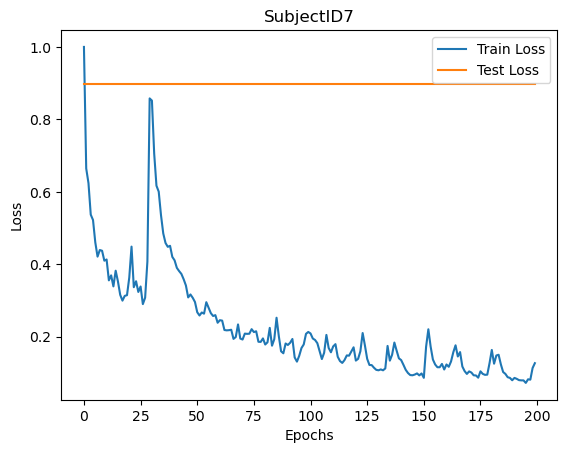

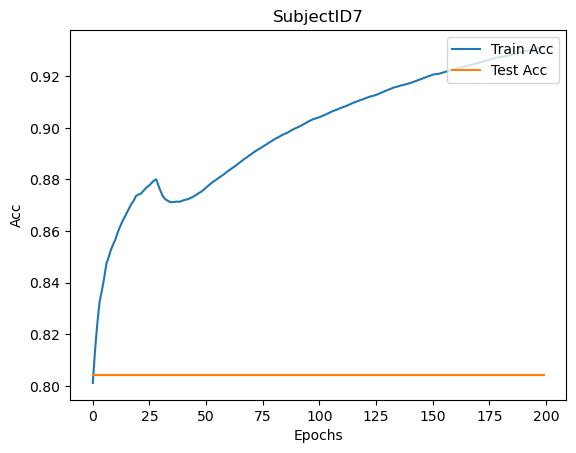


Subject 8
| epoch   0 | 0.1308 s/epoch | train loss 1.0586
| epoch   1 | 0.1302 s/epoch | train loss 0.7418
| epoch   2 | 0.1303 s/epoch | train loss 0.6414
| epoch   3 | 0.1310 s/epoch | train loss 0.6168
| epoch   4 | 0.1301 s/epoch | train loss 0.5557
| epoch   5 | 0.1308 s/epoch | train loss 0.5000
| epoch   6 | 0.1303 s/epoch | train loss 0.4715
| epoch   7 | 0.1300 s/epoch | train loss 0.4554
| epoch   8 | 0.1308 s/epoch | train loss 0.4375
| epoch   9 | 0.1323 s/epoch | train loss 0.4211
| epoch  10 | 0.1301 s/epoch | train loss 0.4227
| epoch  11 | 0.1302 s/epoch | train loss 0.3678
| epoch  12 | 0.1309 s/epoch | train loss 0.3636
| epoch  13 | 0.1305 s/epoch | train loss 0.4999
| epoch  14 | 0.1301 s/epoch | train loss 0.4785
| epoch  15 | 0.1310 s/epoch | train loss 0.4194
| epoch  16 | 0.1336 s/epoch | train loss 0.3892
| epoch  17 | 0.1321 s/epoch | train loss 0.3712
| epoch  18 | 0.1319 s/epoch | train loss 0.3972
| epoch  19 | 0.1301 s/epoch | train loss 0.3757
| epoch  

| epoch 167 | 0.1591 s/epoch | train loss 0.0949
| epoch 168 | 0.1298 s/epoch | train loss 0.1095
| epoch 169 | 0.1299 s/epoch | train loss 0.1182
| epoch 170 | 0.1309 s/epoch | train loss 0.1327
| epoch 171 | 0.1307 s/epoch | train loss 0.1141
| epoch 172 | 0.1308 s/epoch | train loss 0.1103
| epoch 173 | 0.1327 s/epoch | train loss 0.1320
| epoch 174 | 0.1341 s/epoch | train loss 0.1005
| epoch 175 | 0.1312 s/epoch | train loss 0.0988
| epoch 176 | 0.1310 s/epoch | train loss 0.0973
| epoch 177 | 0.1313 s/epoch | train loss 0.0940
| epoch 178 | 0.1313 s/epoch | train loss 0.0888
| epoch 179 | 0.1298 s/epoch | train loss 0.0913
| epoch 180 | 0.1306 s/epoch | train loss 0.1492
| epoch 181 | 0.1306 s/epoch | train loss 0.1642
| epoch 182 | 0.1306 s/epoch | train loss 0.1227
| epoch 183 | 0.1307 s/epoch | train loss 0.1036
| epoch 184 | 0.1314 s/epoch | train loss 0.0912
| epoch 185 | 0.1319 s/epoch | train loss 0.0928
| epoch 186 | 0.1329 s/epoch | train loss 0.0909
| epoch 187 | 0.1319

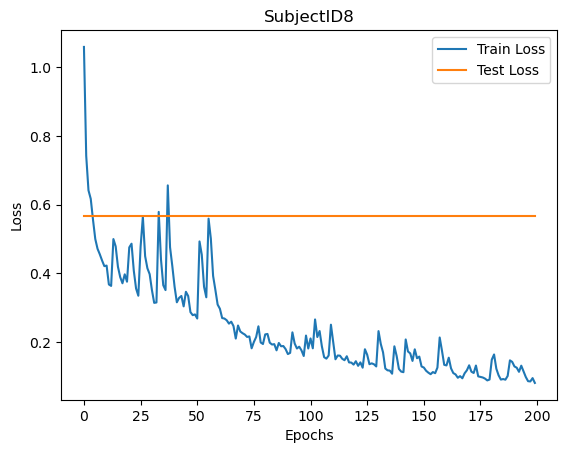

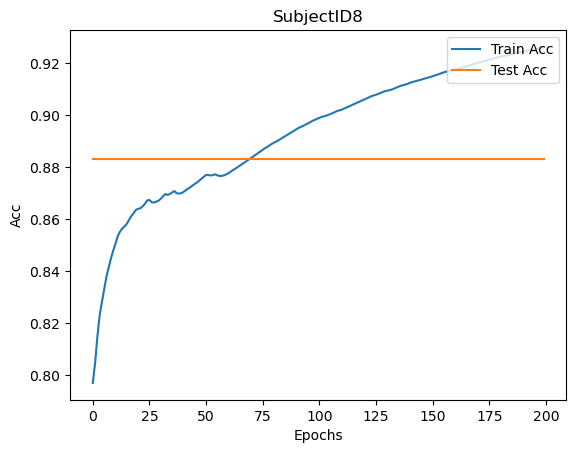


Subject 9
| epoch   0 | 0.3106 s/epoch | train loss 1.0364
| epoch   1 | 0.2262 s/epoch | train loss 0.7511
| epoch   2 | 0.5791 s/epoch | train loss 0.6235
| epoch   3 | 0.1330 s/epoch | train loss 0.6141
| epoch   4 | 0.1504 s/epoch | train loss 0.5498
| epoch   5 | 0.3079 s/epoch | train loss 0.5000
| epoch   6 | 0.4155 s/epoch | train loss 0.4598
| epoch   7 | 3.4924 s/epoch | train loss 0.4475
| epoch   8 | 0.1324 s/epoch | train loss 0.4220
| epoch   9 | 0.1294 s/epoch | train loss 0.4158
| epoch  10 | 0.1321 s/epoch | train loss 0.4360
| epoch  11 | 0.1296 s/epoch | train loss 0.5529
| epoch  12 | 0.1284 s/epoch | train loss 0.4359
| epoch  13 | 0.1280 s/epoch | train loss 0.4509
| epoch  14 | 0.1278 s/epoch | train loss 0.3962
| epoch  15 | 0.1284 s/epoch | train loss 0.4074
| epoch  16 | 0.1297 s/epoch | train loss 0.3719
| epoch  17 | 0.1281 s/epoch | train loss 0.3524
| epoch  18 | 0.1288 s/epoch | train loss 0.3395
| epoch  19 | 0.1288 s/epoch | train loss 0.3098
| epoch  

| epoch 167 | 0.1416 s/epoch | train loss 0.1622
| epoch 168 | 0.1294 s/epoch | train loss 0.1339
| epoch 169 | 0.1288 s/epoch | train loss 0.1156
| epoch 170 | 0.1301 s/epoch | train loss 0.1078
| epoch 171 | 0.1342 s/epoch | train loss 0.1212
| epoch 172 | 0.1315 s/epoch | train loss 0.1158
| epoch 173 | 0.1287 s/epoch | train loss 0.1097
| epoch 174 | 0.1285 s/epoch | train loss 0.0998
| epoch 175 | 0.1500 s/epoch | train loss 0.0959
| epoch 176 | 0.2869 s/epoch | train loss 0.0984
| epoch 177 | 0.2337 s/epoch | train loss 0.0971
| epoch 178 | 0.2500 s/epoch | train loss 0.0905
| epoch 179 | 0.2155 s/epoch | train loss 0.0965
| epoch 180 | 0.4327 s/epoch | train loss 0.1075
| epoch 181 | 0.2028 s/epoch | train loss 0.1415
| epoch 182 | 0.1984 s/epoch | train loss 0.1478
| epoch 183 | 0.1966 s/epoch | train loss 0.1549
| epoch 184 | 0.1951 s/epoch | train loss 0.1186
| epoch 185 | 0.1912 s/epoch | train loss 0.1269
| epoch 186 | 0.1971 s/epoch | train loss 0.1138
| epoch 187 | 0.1986

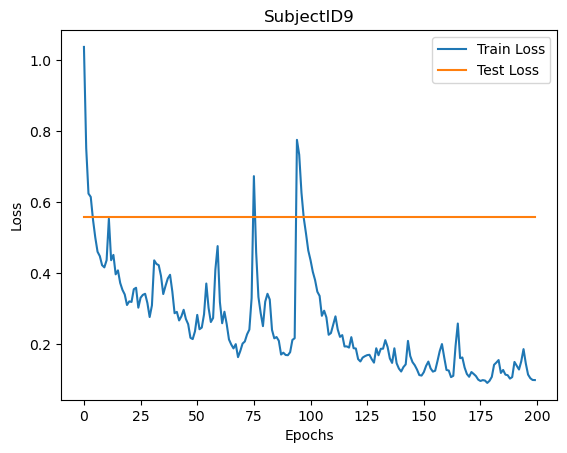

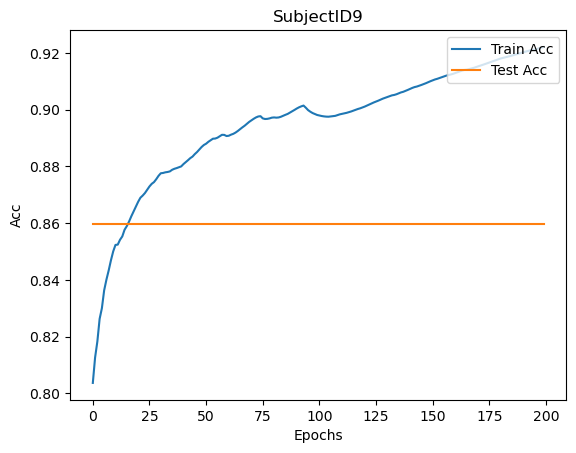


Subject 10
| epoch   0 | 0.2088 s/epoch | train loss 1.0519
| epoch   1 | 0.2038 s/epoch | train loss 0.7050
| epoch   2 | 0.2047 s/epoch | train loss 0.6761
| epoch   3 | 0.2030 s/epoch | train loss 0.5770
| epoch   4 | 0.1997 s/epoch | train loss 0.5642
| epoch   5 | 0.2038 s/epoch | train loss 0.5374
| epoch   6 | 0.1972 s/epoch | train loss 0.4935
| epoch   7 | 0.2090 s/epoch | train loss 0.4870
| epoch   8 | 0.2054 s/epoch | train loss 0.4545
| epoch   9 | 0.2041 s/epoch | train loss 0.4467
| epoch  10 | 0.2039 s/epoch | train loss 0.4255
| epoch  11 | 0.2023 s/epoch | train loss 0.4094
| epoch  12 | 0.2091 s/epoch | train loss 0.3924
| epoch  13 | 0.2034 s/epoch | train loss 0.4147
| epoch  14 | 0.2035 s/epoch | train loss 0.3826
| epoch  15 | 0.2031 s/epoch | train loss 0.3518
| epoch  16 | 0.2046 s/epoch | train loss 0.3709
| epoch  17 | 0.2084 s/epoch | train loss 0.3934
| epoch  18 | 0.2013 s/epoch | train loss 0.3319
| epoch  19 | 0.1997 s/epoch | train loss 0.3932
| epoch 

| epoch 167 | 0.1776 s/epoch | train loss 0.1512
| epoch 168 | 0.1767 s/epoch | train loss 0.1296
| epoch 169 | 0.1808 s/epoch | train loss 0.1141
| epoch 170 | 0.1758 s/epoch | train loss 0.1040
| epoch 171 | 0.1757 s/epoch | train loss 0.1145
| epoch 172 | 0.1756 s/epoch | train loss 0.1341
| epoch 173 | 0.1801 s/epoch | train loss 0.1557
| epoch 174 | 0.1747 s/epoch | train loss 0.1536
| epoch 175 | 0.1764 s/epoch | train loss 0.1380
| epoch 176 | 0.1785 s/epoch | train loss 0.1185
| epoch 177 | 0.1787 s/epoch | train loss 0.1309
| epoch 178 | 0.1776 s/epoch | train loss 0.1361
| epoch 179 | 0.1784 s/epoch | train loss 0.1490
| epoch 180 | 0.1774 s/epoch | train loss 0.1467
| epoch 181 | 0.1760 s/epoch | train loss 0.1398
| epoch 182 | 0.1770 s/epoch | train loss 0.1093
| epoch 183 | 0.1767 s/epoch | train loss 0.1016
| epoch 184 | 0.1762 s/epoch | train loss 0.0928
| epoch 185 | 0.1758 s/epoch | train loss 0.0915
| epoch 186 | 0.1763 s/epoch | train loss 0.1026
| epoch 187 | 0.1782

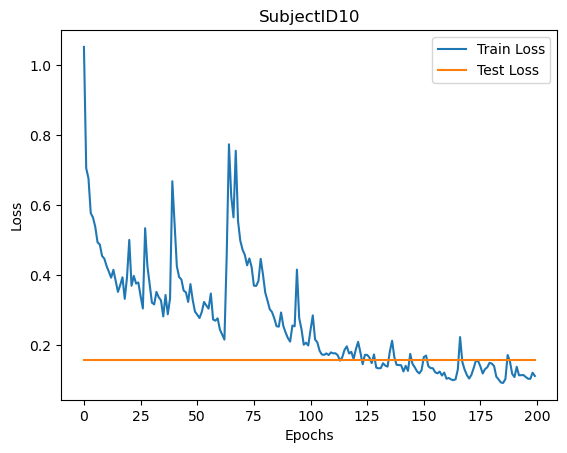

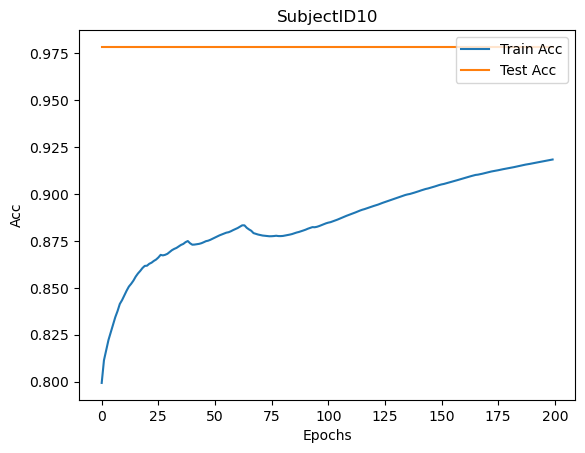


Subject 11
| epoch   0 | 0.1754 s/epoch | train loss 1.0954
| epoch   1 | 0.1753 s/epoch | train loss 0.8137
| epoch   2 | 0.1736 s/epoch | train loss 0.6748
| epoch   3 | 0.1744 s/epoch | train loss 0.6599
| epoch   4 | 0.1744 s/epoch | train loss 0.6410
| epoch   5 | 0.1743 s/epoch | train loss 0.5431
| epoch   6 | 0.1785 s/epoch | train loss 0.5251
| epoch   7 | 0.1748 s/epoch | train loss 0.4691
| epoch   8 | 0.1761 s/epoch | train loss 0.4759
| epoch   9 | 0.1727 s/epoch | train loss 0.4582
| epoch  10 | 0.1751 s/epoch | train loss 0.5171
| epoch  11 | 0.1736 s/epoch | train loss 0.4232
| epoch  12 | 0.1768 s/epoch | train loss 0.4100
| epoch  13 | 0.1768 s/epoch | train loss 0.3872
| epoch  14 | 0.1752 s/epoch | train loss 0.3843
| epoch  15 | 0.1765 s/epoch | train loss 0.3830
| epoch  16 | 0.1721 s/epoch | train loss 0.3628
| epoch  17 | 0.1797 s/epoch | train loss 0.3767
| epoch  18 | 0.1797 s/epoch | train loss 0.3419
| epoch  19 | 0.1738 s/epoch | train loss 0.3413
| epoch 

| epoch 167 | 0.1448 s/epoch | train loss 0.1185
| epoch 168 | 0.1441 s/epoch | train loss 0.0981
| epoch 169 | 0.1454 s/epoch | train loss 0.1300
| epoch 170 | 0.1452 s/epoch | train loss 0.2018
| epoch 171 | 0.1454 s/epoch | train loss 0.2006
| epoch 172 | 0.1420 s/epoch | train loss 0.1461
| epoch 173 | 0.1448 s/epoch | train loss 0.1226
| epoch 174 | 0.1436 s/epoch | train loss 0.1071
| epoch 175 | 0.1438 s/epoch | train loss 0.1003
| epoch 176 | 0.1392 s/epoch | train loss 0.1659
| epoch 177 | 0.1384 s/epoch | train loss 0.1290
| epoch 178 | 0.1385 s/epoch | train loss 0.1338
| epoch 179 | 0.1395 s/epoch | train loss 0.1185
| epoch 180 | 0.1536 s/epoch | train loss 0.0936
| epoch 181 | 0.1754 s/epoch | train loss 0.0901
| epoch 182 | 0.1800 s/epoch | train loss 0.0877
| epoch 183 | 0.1762 s/epoch | train loss 0.0865
| epoch 184 | 0.1743 s/epoch | train loss 0.0963
| epoch 185 | 0.1747 s/epoch | train loss 0.1064
| epoch 186 | 0.1749 s/epoch | train loss 0.1018
| epoch 187 | 0.1764

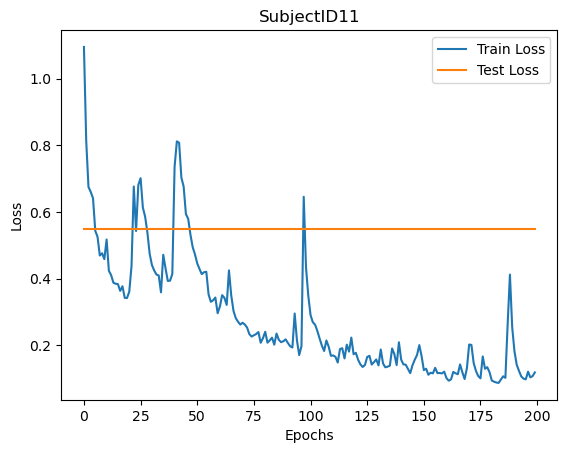

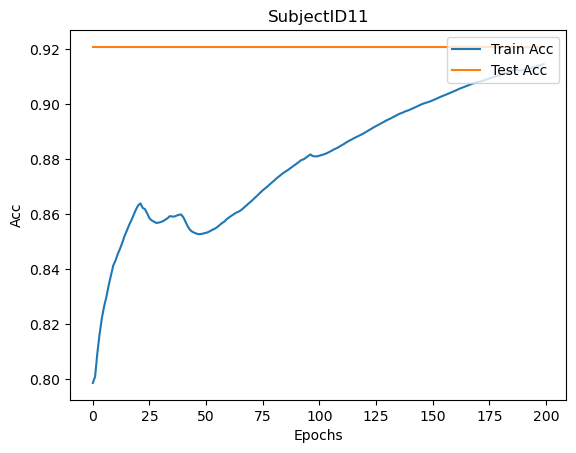


Subject 12
| epoch   0 | 0.1671 s/epoch | train loss 1.0340
| epoch   1 | 0.1646 s/epoch | train loss 0.7592
| epoch   2 | 0.1662 s/epoch | train loss 0.6453
| epoch   3 | 0.1653 s/epoch | train loss 0.6160
| epoch   4 | 0.1679 s/epoch | train loss 0.5995
| epoch   5 | 0.1682 s/epoch | train loss 0.5687
| epoch   6 | 0.1649 s/epoch | train loss 0.5022
| epoch   7 | 0.1695 s/epoch | train loss 0.5044
| epoch   8 | 0.1670 s/epoch | train loss 0.4812
| epoch   9 | 0.1658 s/epoch | train loss 0.4324
| epoch  10 | 0.1696 s/epoch | train loss 0.4740
| epoch  11 | 0.1686 s/epoch | train loss 0.4981
| epoch  12 | 0.1682 s/epoch | train loss 0.4518
| epoch  13 | 0.1657 s/epoch | train loss 0.4323
| epoch  14 | 0.1681 s/epoch | train loss 0.3848
| epoch  15 | 0.1669 s/epoch | train loss 0.3905
| epoch  16 | 0.1678 s/epoch | train loss 0.3938
| epoch  17 | 0.1674 s/epoch | train loss 0.3650
| epoch  18 | 0.1685 s/epoch | train loss 0.3390
| epoch  19 | 0.1639 s/epoch | train loss 0.3478
| epoch 

| epoch 167 | 0.1651 s/epoch | train loss 0.1830
| epoch 168 | 0.1661 s/epoch | train loss 0.1936
| epoch 169 | 0.1689 s/epoch | train loss 0.1340
| epoch 170 | 0.1648 s/epoch | train loss 0.1212
| epoch 171 | 0.1696 s/epoch | train loss 0.1105
| epoch 172 | 0.1692 s/epoch | train loss 0.1099
| epoch 173 | 0.1651 s/epoch | train loss 0.0936
| epoch 174 | 0.1666 s/epoch | train loss 0.0932
| epoch 175 | 0.1673 s/epoch | train loss 0.1027
| epoch 176 | 0.1662 s/epoch | train loss 0.0940
| epoch 177 | 0.1662 s/epoch | train loss 0.2014
| epoch 178 | 0.1659 s/epoch | train loss 0.1401
| epoch 179 | 0.1676 s/epoch | train loss 0.1942
| epoch 180 | 0.1680 s/epoch | train loss 0.1283
| epoch 181 | 0.1665 s/epoch | train loss 0.1299
| epoch 182 | 0.1703 s/epoch | train loss 0.1447
| epoch 183 | 0.1698 s/epoch | train loss 0.2124
| epoch 184 | 0.1658 s/epoch | train loss 0.1800
| epoch 185 | 0.1679 s/epoch | train loss 0.1421
| epoch 186 | 0.1658 s/epoch | train loss 0.1308
| epoch 187 | 0.1679

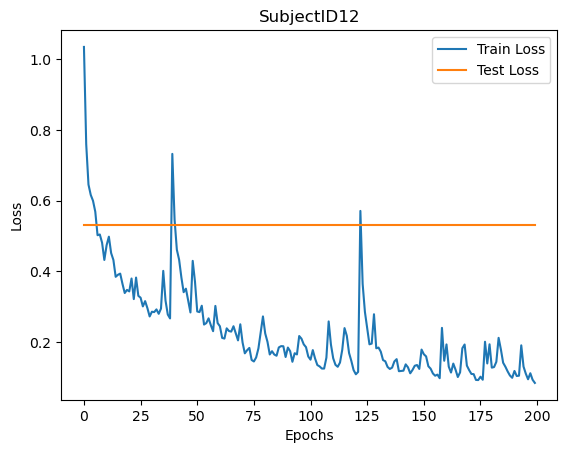

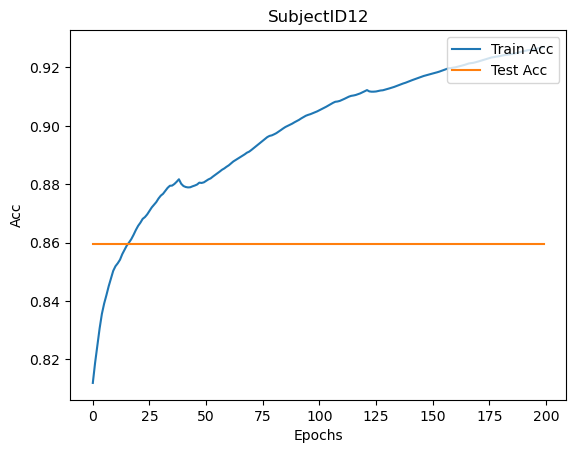


Subject 13
| epoch   0 | 0.1688 s/epoch | train loss 1.0036
| epoch   1 | 0.1669 s/epoch | train loss 0.7280
| epoch   2 | 0.1700 s/epoch | train loss 0.6665
| epoch   3 | 0.1671 s/epoch | train loss 0.5713
| epoch   4 | 0.1661 s/epoch | train loss 0.7300
| epoch   5 | 0.1689 s/epoch | train loss 0.6249
| epoch   6 | 0.1678 s/epoch | train loss 0.5894
| epoch   7 | 0.1678 s/epoch | train loss 0.5278
| epoch   8 | 0.1696 s/epoch | train loss 0.4798
| epoch   9 | 0.1669 s/epoch | train loss 0.5645
| epoch  10 | 0.1659 s/epoch | train loss 0.4804
| epoch  11 | 0.1631 s/epoch | train loss 0.4808
| epoch  12 | 0.1692 s/epoch | train loss 0.4124
| epoch  13 | 0.1666 s/epoch | train loss 0.4248
| epoch  14 | 0.1659 s/epoch | train loss 0.3889
| epoch  15 | 0.1686 s/epoch | train loss 0.3775
| epoch  16 | 0.1692 s/epoch | train loss 0.4440
| epoch  17 | 0.1660 s/epoch | train loss 0.6498
| epoch  18 | 0.1686 s/epoch | train loss 0.6249
| epoch  19 | 0.1702 s/epoch | train loss 0.5271
| epoch 

| epoch 167 | 0.1386 s/epoch | train loss 0.1321
| epoch 168 | 0.1398 s/epoch | train loss 0.1149
| epoch 169 | 0.1395 s/epoch | train loss 0.1011
| epoch 170 | 0.1376 s/epoch | train loss 0.1048
| epoch 171 | 0.1385 s/epoch | train loss 0.2046
| epoch 172 | 0.1374 s/epoch | train loss 0.1851
| epoch 173 | 0.1382 s/epoch | train loss 0.1907
| epoch 174 | 0.1396 s/epoch | train loss 0.1423
| epoch 175 | 0.1371 s/epoch | train loss 0.1172
| epoch 176 | 0.1387 s/epoch | train loss 0.1071
| epoch 177 | 0.1414 s/epoch | train loss 0.0946
| epoch 178 | 0.1405 s/epoch | train loss 0.0987
| epoch 179 | 0.1384 s/epoch | train loss 0.1006
| epoch 180 | 0.1392 s/epoch | train loss 0.0925
| epoch 181 | 0.1416 s/epoch | train loss 0.0919
| epoch 182 | 0.1380 s/epoch | train loss 0.0906
| epoch 183 | 0.1385 s/epoch | train loss 0.0912
| epoch 184 | 0.1375 s/epoch | train loss 0.0845
| epoch 185 | 0.1369 s/epoch | train loss 0.0855
| epoch 186 | 0.1397 s/epoch | train loss 0.0871
| epoch 187 | 0.1359

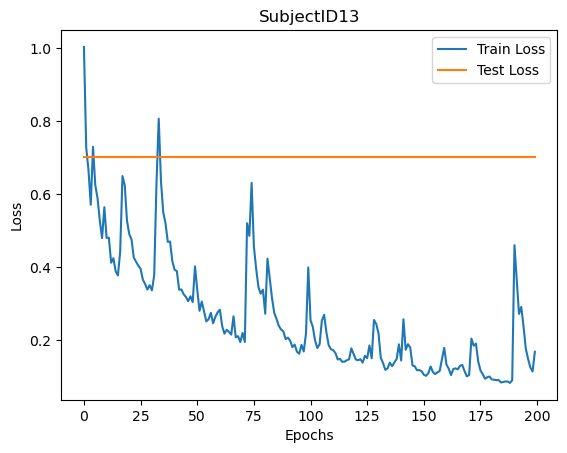

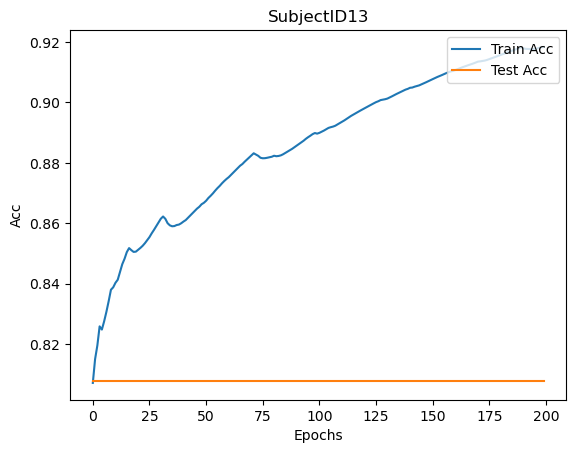


Subject 14
| epoch   0 | 0.1468 s/epoch | train loss 1.2326
| epoch   1 | 0.1378 s/epoch | train loss 1.2479
| epoch   2 | 0.1370 s/epoch | train loss 0.7756
| epoch   3 | 0.1392 s/epoch | train loss 0.6747
| epoch   4 | 0.1359 s/epoch | train loss 0.7201
| epoch   5 | 0.1586 s/epoch | train loss 0.8039
| epoch   6 | 0.1756 s/epoch | train loss 0.6300
| epoch   7 | 0.1765 s/epoch | train loss 0.5951
| epoch   8 | 0.1733 s/epoch | train loss 0.5642
| epoch   9 | 0.1715 s/epoch | train loss 0.5415
| epoch  10 | 0.1757 s/epoch | train loss 0.5021
| epoch  11 | 0.1782 s/epoch | train loss 0.5026
| epoch  12 | 0.1759 s/epoch | train loss 0.4937
| epoch  13 | 0.1739 s/epoch | train loss 0.4651
| epoch  14 | 0.1705 s/epoch | train loss 0.5266
| epoch  15 | 0.1751 s/epoch | train loss 0.4237
| epoch  16 | 0.1729 s/epoch | train loss 0.4434
| epoch  17 | 0.1707 s/epoch | train loss 0.4456
| epoch  18 | 0.1730 s/epoch | train loss 0.3892
| epoch  19 | 0.1740 s/epoch | train loss 0.4339
| epoch 

| epoch 167 | 0.1748 s/epoch | train loss 0.2346
| epoch 168 | 0.1738 s/epoch | train loss 0.2009
| epoch 169 | 0.1743 s/epoch | train loss 0.2380
| epoch 170 | 0.1729 s/epoch | train loss 0.3097
| epoch 171 | 0.1748 s/epoch | train loss 0.2195
| epoch 172 | 0.1732 s/epoch | train loss 0.2222
| epoch 173 | 0.1745 s/epoch | train loss 0.2492
| epoch 174 | 0.1750 s/epoch | train loss 0.2019
| epoch 175 | 0.1727 s/epoch | train loss 0.2000
| epoch 176 | 0.1713 s/epoch | train loss 0.2784
| epoch 177 | 0.1721 s/epoch | train loss 0.2007
| epoch 178 | 0.1722 s/epoch | train loss 0.1667
| epoch 179 | 0.1741 s/epoch | train loss 0.1801
| epoch 180 | 0.1741 s/epoch | train loss 0.1655
| epoch 181 | 0.1746 s/epoch | train loss 0.2136
| epoch 182 | 0.1720 s/epoch | train loss 0.1670
| epoch 183 | 0.1731 s/epoch | train loss 0.1496
| epoch 184 | 0.1739 s/epoch | train loss 0.1413
| epoch 185 | 0.1751 s/epoch | train loss 0.1608
| epoch 186 | 0.1730 s/epoch | train loss 0.1877
| epoch 187 | 0.1700

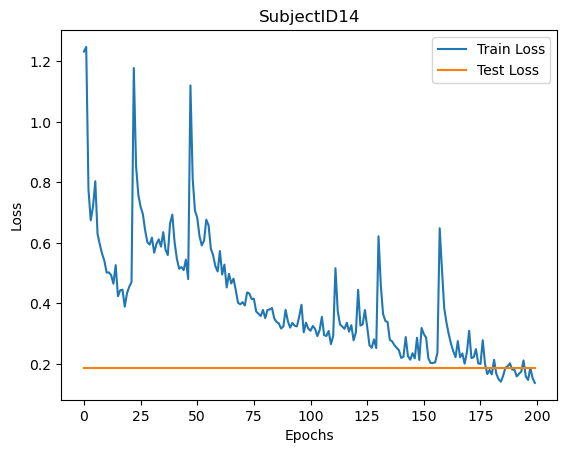

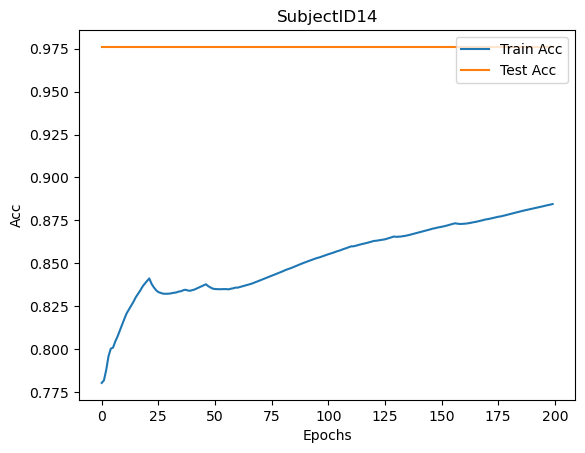


Subject 15
| epoch   0 | 0.1816 s/epoch | train loss 1.0224
| epoch   1 | 0.1815 s/epoch | train loss 0.7609
| epoch   2 | 0.1822 s/epoch | train loss 0.6334
| epoch   3 | 0.1800 s/epoch | train loss 0.5960
| epoch   4 | 0.1792 s/epoch | train loss 0.5467
| epoch   5 | 0.1818 s/epoch | train loss 0.5171
| epoch   6 | 0.1804 s/epoch | train loss 0.4945
| epoch   7 | 0.1811 s/epoch | train loss 0.4714
| epoch   8 | 0.1803 s/epoch | train loss 0.4619
| epoch   9 | 0.1796 s/epoch | train loss 0.4477
| epoch  10 | 0.1780 s/epoch | train loss 0.3831
| epoch  11 | 0.1815 s/epoch | train loss 0.3712
| epoch  12 | 0.1804 s/epoch | train loss 0.3651
| epoch  13 | 0.1817 s/epoch | train loss 0.3465
| epoch  14 | 0.1795 s/epoch | train loss 0.3324
| epoch  15 | 0.1835 s/epoch | train loss 0.3362
| epoch  16 | 0.1830 s/epoch | train loss 0.3232
| epoch  17 | 0.1793 s/epoch | train loss 0.3253
| epoch  18 | 0.1807 s/epoch | train loss 0.3116
| epoch  19 | 0.1827 s/epoch | train loss 0.3149
| epoch 

| epoch 167 | 0.1494 s/epoch | train loss 0.0767
| epoch 168 | 0.1496 s/epoch | train loss 0.0741
| epoch 169 | 0.1511 s/epoch | train loss 0.0705
| epoch 170 | 0.1465 s/epoch | train loss 0.0672
| epoch 171 | 0.1477 s/epoch | train loss 0.0676
| epoch 172 | 0.1478 s/epoch | train loss 0.0734
| epoch 173 | 0.1508 s/epoch | train loss 0.0712
| epoch 174 | 0.1501 s/epoch | train loss 0.0694
| epoch 175 | 0.1495 s/epoch | train loss 0.0802
| epoch 176 | 0.1454 s/epoch | train loss 0.0885
| epoch 177 | 0.1512 s/epoch | train loss 0.1515
| epoch 178 | 0.1483 s/epoch | train loss 0.1436
| epoch 179 | 0.1482 s/epoch | train loss 0.1287
| epoch 180 | 0.1488 s/epoch | train loss 0.2033
| epoch 181 | 0.1494 s/epoch | train loss 0.1306
| epoch 182 | 0.1491 s/epoch | train loss 0.0905
| epoch 183 | 0.1495 s/epoch | train loss 0.0888
| epoch 184 | 0.1491 s/epoch | train loss 0.1186
| epoch 185 | 0.1497 s/epoch | train loss 0.1098
| epoch 186 | 0.1514 s/epoch | train loss 0.0867
| epoch 187 | 0.1496

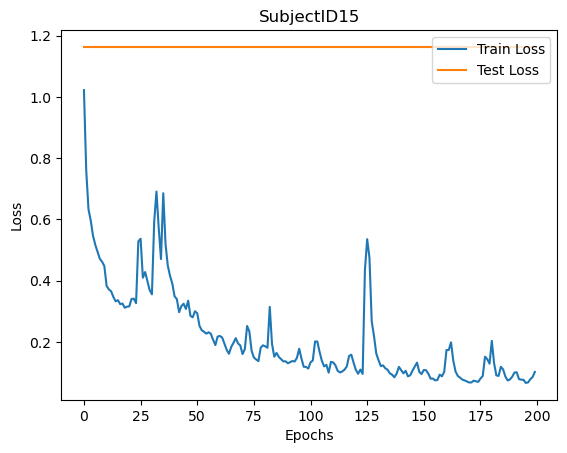

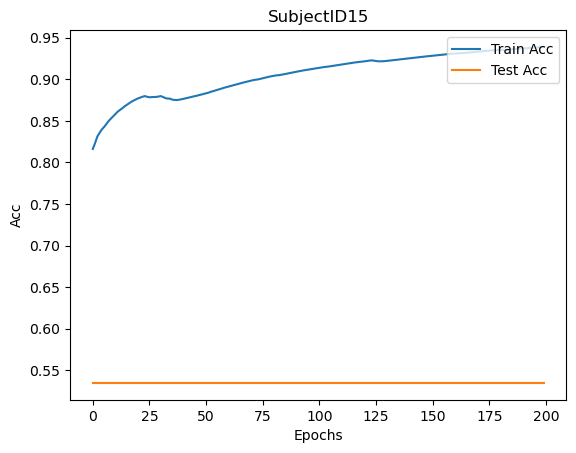

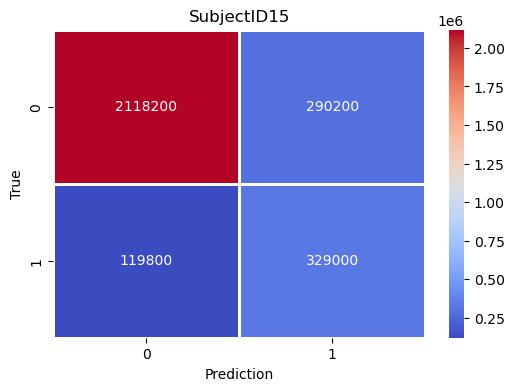

Distillation_student(CNNSmall)_Acc: 0.8565028699426012
Distillation_student(CNNSmall)_Rec: 0.7330659536541889
Distillation_student(CNNSmall)_Pre: 0.5313307493540051
Distillation_student(CNNSmall)_F1: 0.6161048689138577


<Figure size 640x480 with 0 Axes>

In [19]:
#Layer 2 Training Student
# Distillation_teacher_model = None
Distillation_teacher_model = load_checkpoint(model_teacher_student, PATH)

Distillation_student_train_preds = []
Distillation_student_train_gt = []

for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode

    ResNet_DS = Net_Teacher_Student(block, [3, 4, 23, 3], 1, 2)
    model_Distillation_student = ResNet_DS.to(device)
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher_student = torch.optim.Adam(model_Distillation_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    Layer = True
    training_teacher_student(trainloader,optimizer_teacher_student,criterion,Distillation_teacher_model,model_Distillation_student,alpha,testloader,Layer,sub)
    #testing_teacher_student(testloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student)

show_CM_teacher_student(teacher_student_train_preds, teacher_student_train_gt)
teacher_Student_eval_table = evaluation(teacher_student_train_preds, teacher_student_train_gt)    

print("Distillation_student(CNNSmall)_Acc:",teacher_Student_eval_table[0])
print("Distillation_student(CNNSmall)_Rec:",teacher_Student_eval_table[1])
print("Distillation_student(CNNSmall)_Pre:",teacher_Student_eval_table[2])
print("Distillation_student(CNNSmall)_F1:",teacher_Student_eval_table[3])



In [1]:
# print("Teacher(RestNet50)_Acc:",sum(Accuracy_teacher)/14)
# print("Teacher(RestNet50)_Rec:",sum(Recall_teacher)/11)
# print("Teacher(RestNet50)_Pre:",sum(Precision_teacher)/11)
# print("Teacher(RestNet50)_F1:",sum(F1score_teacher)/11)

# print("Original_Student(CNN)_Acc:",sum(Accuracy_student)/14)
# print("Original_Student(CNN)_Rec:",sum(Recall_student)/11)
# print("Original_Student(CNN)_Pre:",sum(Precision_student)/11)
# print("Original_Student(CNN)_F1:",sum(F1score_student)/11)

# print("Distillation_Student(CNN)_Acc:",sum(Accuracy_teacher_student)/14)
# print("Distillation_Student(CNN)_Rec:",sum(Recall_teacher_student)/11)
# print("Distillation_Student(CNN)_Pre:",sum(Precision_teacher_student)/11)
# print("Distillation_Student(CNN)_F1:",sum(F1score_teacher_student)/11)



dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher, params_teachar = profile(model_teacher,(dummy_input,))
print('\n\nflops:',flops_teacher, 'params', params_teachar)
print('flops_teacher: %.3f M, params_teachar: %.3f M' % (flops_teacher / 1000000.0, params_teachar / 1000000.0))


dummy_input = torch.randn(64,1,14,3,device=device)
flops_student, params_student = profile(model_student,(dummy_input,))
print('\nflops:',flops_student, 'params', params_student)
print('flops_student: %.3f K, params_student: %.3f K' % (flops_student / 1000.0, params_student / 1000.0))
dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher_student, params_teacher_student = profile(model_teacher_student,(dummy_input,))
print('\nflops:',flops_teacher_student, 'params', params_teacher_student)
print('flops_teacher_student: %.3f K, params_teacher_student: %.3f K' % (flops_teacher_student / 1000.0, params_teacher_student / 1000.0))

flops_Distillation_student, params_Distillation_student = profile(model_Distillation_student,(dummy_input,))
print('\nflops:',flops_Distillation_student, 'params', params_Distillation_student)
print('flops_teacher_student: %.3f K, params_teacher_student: %.3f K' % (flops_Distillation_student / 1000.0, params_Distillation_student / 1000.0))

NameError: name 'torch' is not defined